In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold

In [3]:
def PrintAll(x):
    pd.set_option('display.max_rows ',len(x))
    print(x)
    pd.set_option('display.max_rows',10)

In [4]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)
pId = testData['PassengerId']

print("Train data number : {}".format(trainData.shape[0]))
print("Test data number : {}".format(testData.shape[0])) 

Train data number : 891
Test data number : 418


In [5]:
# Check missing data
def MissingData(data):
    total = data.isnull().count()
    count = data.isnull().sum()
    missingData = pd.DataFrame({'percent(%)':count/total * 100})
    PrintAll(missingData)

In [6]:
MissingData(trainData)
MissingData(testData)

             percent(%)
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age           19.865320
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         77.104377
Embarked       0.224467
             percent(%)
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age           20.574163
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.239234
Cabin         78.229665
Embarked       0.000000


In [7]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.head()
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [8]:
# Deal with missing values
def nan_padding(data, columns):
    for c in columns:
        data[c].fillna(data[c].median(), inplace = True)
    return data

columns = ["Age","SibSp", "Parch","Fare"]
trainData = nan_padding(trainData, columns)
testData = nan_padding(testData, columns)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [9]:
# Filled Embark 
trainData['Embarked'].fillna(trainData['Embarked'].mode()[0],inplace = True)
testData['Embarked'].fillna(testData['Embarked'].mode()[0],inplace = True)

In [10]:
# Check missing test data
MissingData(trainData)
MissingData(testData)

             percent(%)
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         77.104377
Embarked       0.000000
HasCabin       0.000000
             percent(%)
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         78.229665
Embarked       0.000000
HasCabin       0.000000


In [27]:
# Print all title
def GetTitle(name):
    title = re.search(" ([A-Za-z]+)\. ",name)
    if title:        
        return title.group(1)
    else:
        return 0
# Add title
def NameToTitle(data):    
    data['Title'] = data['Title'].replace(['Mile','Ms','Lady'],'Miss')    
    data['Title'] = data['Title'].replace('Mme','Mrs')    
    data['Title'] = data["Title"].replace(['Rev','Dr','Col','Mlle','Major','Dona','Don','Countess','Capt','Sir','Jonkheer'],'Rare')    
    return data


trainData["Title"] = trainData['Name'].apply(GetTitle)
testData["Title"] =  testData['Name'].apply(GetTitle)

trainData = NameToTitle(trainData)
testData = NameToTitle(testData)

title = pd.concat([trainData['Title'],testData['Title']]).value_counts()
PrintAll(title)

Mr        757
Miss      263
Mrs       198
Master     61
Rare       30
Name: Title, dtype: int64


In [28]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

columns = ['Pclass','Embarked','Title']
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,0,0,1,0,0,0,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,1,0,0,1,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,1,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,0,1,0,0,1,0,0,1,0,0


In [29]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,...,0,0,1,0,0,0,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,1,0,0,1,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,1,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,...,0,1,0,0,1,0,0,1,0,0


In [8]:
# Family size
trainData['FamilySize'] = trainData['SibSp'] + trainData['Parch'] + 1
testData['FamilySize'] = testData['SibSp'] + testData['Parch'] + 1

trainData['IsAlone'] = trainData['FamilySize'].apply(lambda x: 1 if x==1 else 0)
testData['IsAlone'] = testData['FamilySize'].apply(lambda x: 1 if x==1 else 0)


trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,1,0,0,1,0,0,1,0,2.0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,4,1,0,0,1,0,0,1,2.0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,5,0,0,1,0,0,1,0,1.0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,4,1,0,0,0,0,1,1,2.0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,1,0,0,1,0,0,1,0,1.0,1


In [9]:
# Change age
def ConvertAge(age):
    if age <=12 :
        return 0        
    elif age<=18:
        return 1
    elif age<=60:
        return 2
    else : return 3
trainData['AgeRange'] = trainData['Age'].apply(ConvertAge)
testData['AgeRange'] = testData['Age'].apply(ConvertAge)
trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,...,0,0,1,0,0,1,0,2.0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,...,1,0,0,1,0,0,1,2.0,0,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,...,0,0,1,0,0,1,0,1.0,1,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,...,1,0,0,0,0,1,1,2.0,0,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,...,0,0,1,0,0,1,0,1.0,1,2


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,2.0,0,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,...,0,0,1,0,0,1,2.0,0,2,4
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,...,0,1,0,0,1,0,1.0,1,2,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,...,0,0,0,0,1,1,2.0,0,2,4
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,...,0,1,0,0,1,0,1.0,1,2,1


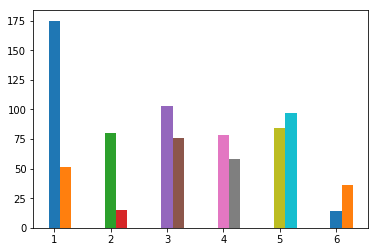

In [10]:
j = 0
k = 0
for i in [8,10,20,30,100,300]:
    k+=1
    plt.bar(k,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==0)).sum(),0.2)
    plt.bar(k+0.2,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==1)).sum(),0.2)
    j = i

# Change fare
def ConvertFare(fare):
    if fare <=8 :
        return 0    
    elif fare<=10:
        return 1
    elif fare<=20:
        return 2
    elif fare<=30:
        return 3
    elif fare<=100:
        return 4
    elif fare<=300:
        return 5
    else : return 6
trainData['FareRange'] = trainData['Fare'].apply(ConvertFare)
testData['FareRange'] = testData['Fare'].apply(ConvertFare)
trainData.head()

In [11]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


columns = ['Fare']
#trainData = NormalizeData(trainData,columns)
#testData = NormalizeData(testData,columns)

#trainData.head()

In [12]:
# Drop useless data
def DropColumn(data, columns):    
    return data.drop(columns,axis = 1)


columns = ['PassengerId','Name',"Ticket", "Cabin","Age","Fare","SibSp","Parch"]
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)

trainData.head()

,Survived,Sex,Title,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,1,0,0,1,0,2.0,0,2,0
1,1,0,4,1,0,0,1,0,0,1,2.0,0,2,4
2,1,0,5,0,0,1,0,0,1,0,1.0,1,2,0
3,1,0,4,1,0,0,0,0,1,1,2.0,0,2,4
4,0,1,1,0,0,1,0,0,1,0,1.0,1,2,1


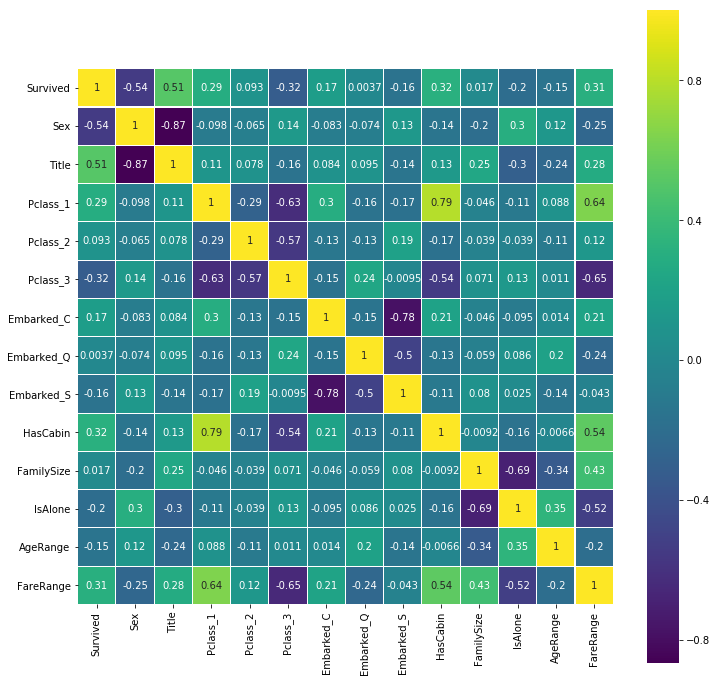

In [13]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [16]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,:].to_numpy()

In [17]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [18]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 4096, 
                              activation = 'relu', 
                              input_shape=(trainX.shape[1],), 
                              kernel_regularizer = tf.keras.regularizers.l2(0.03)),                               
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.03)),        
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.03)), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.03)),                
        tf.keras.layers.Dropout(0.2), 

        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [19]:
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              57344     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0

Train on 801 samples, validate on 90 samples
Epoch 1/1500

Epoch 00001: val_loss improved from inf to 369.05725, saving model to ./checkpoint.ckpt
801/801 - 6s - loss: 369.6276 - accuracy: 0.4469 - val_loss: 369.0573 - val_accuracy: 0.6889
Epoch 2/1500

Epoch 00002: val_loss improved from 369.05725 to 368.00838, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 368.5747 - accuracy: 0.5256 - val_loss: 368.0084 - val_accuracy: 0.8000
Epoch 3/1500

Epoch 00003: val_loss improved from 368.00838 to 366.96191, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 367.5272 - accuracy: 0.5680 - val_loss: 366.9619 - val_accuracy: 0.6889
Epoch 4/1500

Epoch 00004: val_loss improved from 366.96191 to 365.91744, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 366.4799 - accuracy: 0.6517 - val_loss: 365.9174 - val_accuracy: 0.6889
Epoch 5/1500

Epoch 00005: val_loss improved from 365.91744 to 364.87578, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 365.4356 - accuracy: 0.6754 

801/801 - 4s - loss: 329.6515 - accuracy: 0.7441 - val_loss: 329.1390 - val_accuracy: 0.7556
Epoch 42/1500

Epoch 00042: val_loss improved from 329.13899 to 328.19254, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 328.7049 - accuracy: 0.7353 - val_loss: 328.1925 - val_accuracy: 0.7556
Epoch 43/1500

Epoch 00043: val_loss improved from 328.19254 to 327.24868, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 327.7577 - accuracy: 0.7516 - val_loss: 327.2487 - val_accuracy: 0.7444
Epoch 44/1500

Epoch 00044: val_loss improved from 327.24868 to 326.30706, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 326.8143 - accuracy: 0.7291 - val_loss: 326.3071 - val_accuracy: 0.7444
Epoch 45/1500

Epoch 00045: val_loss improved from 326.30706 to 325.36634, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 325.8737 - accuracy: 0.7453 - val_loss: 325.3663 - val_accuracy: 0.7444
Epoch 46/1500

Epoch 00046: val_loss improved from 325.36634 to 324.42736, saving model to ./checkp

801/801 - 4s - loss: 292.5843 - accuracy: 0.7853 - val_loss: 292.1140 - val_accuracy: 0.7889
Epoch 83/1500

Epoch 00083: val_loss improved from 292.11397 to 291.25391, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 291.7234 - accuracy: 0.7765 - val_loss: 291.2539 - val_accuracy: 0.7889
Epoch 84/1500

Epoch 00084: val_loss improved from 291.25391 to 290.39391, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 290.8658 - accuracy: 0.7803 - val_loss: 290.3939 - val_accuracy: 0.7778
Epoch 85/1500

Epoch 00085: val_loss improved from 290.39391 to 289.53787, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 290.0072 - accuracy: 0.7778 - val_loss: 289.5379 - val_accuracy: 0.7778
Epoch 86/1500

Epoch 00086: val_loss improved from 289.53787 to 288.68423, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 289.1516 - accuracy: 0.7753 - val_loss: 288.6842 - val_accuracy: 0.7889
Epoch 87/1500

Epoch 00087: val_loss improved from 288.68423 to 287.83193, saving model to ./checkp

Epoch 123/1500

Epoch 00123: val_loss improved from 259.17260 to 258.38855, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 258.8198 - accuracy: 0.7815 - val_loss: 258.3886 - val_accuracy: 0.8000
Epoch 124/1500

Epoch 00124: val_loss improved from 258.38855 to 257.60394, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 258.0339 - accuracy: 0.7790 - val_loss: 257.6039 - val_accuracy: 0.8000
Epoch 125/1500

Epoch 00125: val_loss improved from 257.60394 to 256.82062, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 257.2492 - accuracy: 0.7865 - val_loss: 256.8206 - val_accuracy: 0.8000
Epoch 126/1500

Epoch 00126: val_loss improved from 256.82062 to 256.03883, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 256.4680 - accuracy: 0.7978 - val_loss: 256.0388 - val_accuracy: 0.8000
Epoch 127/1500

Epoch 00127: val_loss improved from 256.03883 to 255.25924, saving model to ./checkpoint.ckpt
801/801 - 6s - loss: 255.6883 - accuracy: 0.7890 - val_loss: 255.2592 - val_ac

801/801 - 4s - loss: 228.7152 - accuracy: 0.7978 - val_loss: 228.3168 - val_accuracy: 0.8222
Epoch 164/1500

Epoch 00164: val_loss improved from 228.31680 to 227.59990, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 227.9955 - accuracy: 0.7990 - val_loss: 227.5999 - val_accuracy: 0.8222
Epoch 165/1500

Epoch 00165: val_loss improved from 227.59990 to 226.88244, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 227.2784 - accuracy: 0.7978 - val_loss: 226.8824 - val_accuracy: 0.8222
Epoch 166/1500

Epoch 00166: val_loss improved from 226.88244 to 226.16756, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 226.5625 - accuracy: 0.8052 - val_loss: 226.1676 - val_accuracy: 0.8111
Epoch 167/1500

Epoch 00167: val_loss improved from 226.16756 to 225.45347, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 225.8487 - accuracy: 0.8002 - val_loss: 225.4535 - val_accuracy: 0.8111
Epoch 168/1500

Epoch 00168: val_loss improved from 225.45347 to 224.74091, saving model to ./c

Epoch 204/1500

Epoch 00204: val_loss improved from 200.79726 to 200.13877, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 200.5060 - accuracy: 0.8015 - val_loss: 200.1388 - val_accuracy: 0.8111
Epoch 205/1500

Epoch 00205: val_loss improved from 200.13877 to 199.48435, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 199.8481 - accuracy: 0.8040 - val_loss: 199.4843 - val_accuracy: 0.8111
Epoch 206/1500

Epoch 00206: val_loss improved from 199.48435 to 198.82988, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 199.1933 - accuracy: 0.8002 - val_loss: 198.8299 - val_accuracy: 0.8111
Epoch 207/1500

Epoch 00207: val_loss improved from 198.82988 to 198.18085, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 198.5406 - accuracy: 0.8015 - val_loss: 198.1809 - val_accuracy: 0.8222
Epoch 208/1500

Epoch 00208: val_loss improved from 198.18085 to 197.53078, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 197.8887 - accuracy: 0.8015 - val_loss: 197.5308 - val_ac

801/801 - 4s - loss: 175.3931 - accuracy: 0.8052 - val_loss: 175.0604 - val_accuracy: 0.8111
Epoch 245/1500

Epoch 00245: val_loss improved from 175.06038 to 174.46130, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 174.7935 - accuracy: 0.8052 - val_loss: 174.4613 - val_accuracy: 0.8111
Epoch 246/1500

Epoch 00246: val_loss improved from 174.46130 to 173.86622, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 174.1956 - accuracy: 0.8015 - val_loss: 173.8662 - val_accuracy: 0.8111
Epoch 247/1500

Epoch 00247: val_loss improved from 173.86622 to 173.27463, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 173.6009 - accuracy: 0.8027 - val_loss: 173.2746 - val_accuracy: 0.8111
Epoch 248/1500

Epoch 00248: val_loss improved from 173.27463 to 172.68058, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 173.0059 - accuracy: 0.8027 - val_loss: 172.6806 - val_accuracy: 0.8111
Epoch 249/1500

Epoch 00249: val_loss improved from 172.68058 to 172.08922, saving model to ./c

Epoch 285/1500

Epoch 00285: val_loss improved from 152.24256 to 151.70106, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 151.9941 - accuracy: 0.8002 - val_loss: 151.7011 - val_accuracy: 0.8222
Epoch 286/1500

Epoch 00286: val_loss improved from 151.70106 to 151.16018, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 151.4505 - accuracy: 0.8040 - val_loss: 151.1602 - val_accuracy: 0.8222
Epoch 287/1500

Epoch 00287: val_loss improved from 151.16018 to 150.61787, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 150.9079 - accuracy: 0.8027 - val_loss: 150.6179 - val_accuracy: 0.8222
Epoch 288/1500

Epoch 00288: val_loss improved from 150.61787 to 150.07905, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 150.3688 - accuracy: 0.8040 - val_loss: 150.0791 - val_accuracy: 0.8222
Epoch 289/1500

Epoch 00289: val_loss improved from 150.07905 to 149.54266, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 149.8309 - accuracy: 0.8015 - val_loss: 149.5427 - val_ac

801/801 - 4s - loss: 131.3233 - accuracy: 0.8002 - val_loss: 131.0551 - val_accuracy: 0.8111
Epoch 326/1500

Epoch 00326: val_loss improved from 131.05514 to 130.56922, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 130.8324 - accuracy: 0.8052 - val_loss: 130.5692 - val_accuracy: 0.8222
Epoch 327/1500

Epoch 00327: val_loss improved from 130.56922 to 130.08089, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 130.3424 - accuracy: 0.8015 - val_loss: 130.0809 - val_accuracy: 0.8222
Epoch 328/1500

Epoch 00328: val_loss improved from 130.08089 to 129.59161, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 129.8532 - accuracy: 0.8015 - val_loss: 129.5916 - val_accuracy: 0.8222
Epoch 329/1500

Epoch 00329: val_loss improved from 129.59161 to 129.10329, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 129.3669 - accuracy: 0.8027 - val_loss: 129.1033 - val_accuracy: 0.8111
Epoch 330/1500

Epoch 00330: val_loss improved from 129.10329 to 128.61906, saving model to ./c

Epoch 366/1500

Epoch 00366: val_loss improved from 112.40610 to 111.96551, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 112.2057 - accuracy: 0.8015 - val_loss: 111.9655 - val_accuracy: 0.8111
Epoch 367/1500

Epoch 00367: val_loss improved from 111.96551 to 111.52506, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 111.7642 - accuracy: 0.8015 - val_loss: 111.5251 - val_accuracy: 0.8111
Epoch 368/1500

Epoch 00368: val_loss improved from 111.52506 to 111.08597, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 111.3236 - accuracy: 0.8052 - val_loss: 111.0860 - val_accuracy: 0.8111
Epoch 369/1500

Epoch 00369: val_loss improved from 111.08597 to 110.64936, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 110.8843 - accuracy: 0.8065 - val_loss: 110.6494 - val_accuracy: 0.8111
Epoch 370/1500

Epoch 00370: val_loss improved from 110.64936 to 110.21120, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 110.4482 - accuracy: 0.8002 - val_loss: 110.2112 - val_ac

Epoch 407/1500

Epoch 00407: val_loss improved from 95.25046 to 94.85456, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 95.0708 - accuracy: 0.8052 - val_loss: 94.8546 - val_accuracy: 0.8111
Epoch 408/1500

Epoch 00408: val_loss improved from 94.85456 to 94.46312, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 94.6757 - accuracy: 0.8052 - val_loss: 94.4631 - val_accuracy: 0.8111
Epoch 409/1500

Epoch 00409: val_loss improved from 94.46312 to 94.07366, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 94.2826 - accuracy: 0.8052 - val_loss: 94.0737 - val_accuracy: 0.8111
Epoch 410/1500

Epoch 00410: val_loss improved from 94.07366 to 93.68015, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 93.8914 - accuracy: 0.7990 - val_loss: 93.6802 - val_accuracy: 0.8111
Epoch 411/1500

Epoch 00411: val_loss improved from 93.68015 to 93.28974, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 93.5020 - accuracy: 0.8027 - val_loss: 93.2897 - val_accuracy: 0.8111
Epoch

801/801 - 4s - loss: 79.8267 - accuracy: 0.8015 - val_loss: 79.6411 - val_accuracy: 0.8222
Epoch 449/1500

Epoch 00449: val_loss improved from 79.64111 to 79.29050, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 79.4755 - accuracy: 0.8052 - val_loss: 79.2905 - val_accuracy: 0.8111
Epoch 450/1500

Epoch 00450: val_loss improved from 79.29050 to 78.94230, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 79.1278 - accuracy: 0.8052 - val_loss: 78.9423 - val_accuracy: 0.8111
Epoch 451/1500

Epoch 00451: val_loss improved from 78.94230 to 78.59270, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 78.7813 - accuracy: 0.8015 - val_loss: 78.5927 - val_accuracy: 0.8111
Epoch 452/1500

Epoch 00452: val_loss improved from 78.59270 to 78.24707, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 78.4349 - accuracy: 0.8065 - val_loss: 78.2471 - val_accuracy: 0.8111
Epoch 453/1500

Epoch 00453: val_loss improved from 78.24707 to 77.90193, saving model to ./checkpoint.ckpt
801/8

Epoch 490/1500

Epoch 00490: val_loss improved from 66.18658 to 65.87732, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 66.0416 - accuracy: 0.8027 - val_loss: 65.8773 - val_accuracy: 0.8111
Epoch 491/1500

Epoch 00491: val_loss improved from 65.87732 to 65.56916, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 65.7346 - accuracy: 0.8040 - val_loss: 65.5692 - val_accuracy: 0.8111
Epoch 492/1500

Epoch 00492: val_loss improved from 65.56916 to 65.26779, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 65.4281 - accuracy: 0.8015 - val_loss: 65.2678 - val_accuracy: 0.8222
Epoch 493/1500

Epoch 00493: val_loss improved from 65.26779 to 64.96150, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 65.1231 - accuracy: 0.8040 - val_loss: 64.9615 - val_accuracy: 0.8111
Epoch 494/1500

Epoch 00494: val_loss improved from 64.96150 to 64.65670, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 64.8195 - accuracy: 0.8002 - val_loss: 64.6567 - val_accuracy: 0.8111
Epoch

801/801 - 4s - loss: 54.2574 - accuracy: 0.8040 - val_loss: 54.1188 - val_accuracy: 0.8111
Epoch 532/1500

Epoch 00532: val_loss improved from 54.11875 to 53.85383, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 53.9907 - accuracy: 0.8002 - val_loss: 53.8538 - val_accuracy: 0.8222
Epoch 533/1500

Epoch 00533: val_loss improved from 53.85383 to 53.58695, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 53.7257 - accuracy: 0.8015 - val_loss: 53.5870 - val_accuracy: 0.8222
Epoch 534/1500

Epoch 00534: val_loss improved from 53.58695 to 53.32401, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 53.4597 - accuracy: 0.8002 - val_loss: 53.3240 - val_accuracy: 0.8222
Epoch 535/1500

Epoch 00535: val_loss improved from 53.32401 to 53.05717, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 53.1945 - accuracy: 0.8040 - val_loss: 53.0572 - val_accuracy: 0.8222
Epoch 536/1500

Epoch 00536: val_loss improved from 53.05717 to 52.78907, saving model to ./checkpoint.ckpt
801/8

Epoch 573/1500

Epoch 00573: val_loss improved from 43.92389 to 43.69267, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 43.8112 - accuracy: 0.8040 - val_loss: 43.6927 - val_accuracy: 0.8222
Epoch 574/1500

Epoch 00574: val_loss improved from 43.69267 to 43.46326, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 43.5793 - accuracy: 0.8027 - val_loss: 43.4633 - val_accuracy: 0.8222
Epoch 575/1500

Epoch 00575: val_loss improved from 43.46326 to 43.23618, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 43.3514 - accuracy: 0.8015 - val_loss: 43.2362 - val_accuracy: 0.8222
Epoch 576/1500

Epoch 00576: val_loss improved from 43.23618 to 43.00708, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 43.1238 - accuracy: 0.8015 - val_loss: 43.0071 - val_accuracy: 0.8222
Epoch 577/1500

Epoch 00577: val_loss improved from 43.00708 to 42.77944, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 42.8956 - accuracy: 0.8002 - val_loss: 42.7794 - val_accuracy: 0.8222
Epoch

801/801 - 4s - loss: 35.0663 - accuracy: 0.8002 - val_loss: 34.9644 - val_accuracy: 0.8222
Epoch 615/1500

Epoch 00615: val_loss improved from 34.96440 to 34.76762, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 34.8675 - accuracy: 0.8027 - val_loss: 34.7676 - val_accuracy: 0.8222
Epoch 616/1500

Epoch 00616: val_loss improved from 34.76762 to 34.57418, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 34.6711 - accuracy: 0.7990 - val_loss: 34.5742 - val_accuracy: 0.8222
Epoch 617/1500

Epoch 00617: val_loss improved from 34.57418 to 34.38063, saving model to ./checkpoint.ckpt
801/801 - 5s - loss: 34.4765 - accuracy: 0.7990 - val_loss: 34.3806 - val_accuracy: 0.8222
Epoch 618/1500

Epoch 00618: val_loss improved from 34.38063 to 34.18553, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 34.2827 - accuracy: 0.8027 - val_loss: 34.1855 - val_accuracy: 0.8222
Epoch 619/1500

Epoch 00619: val_loss improved from 34.18553 to 33.99034, saving model to ./checkpoint.ckpt
801/8

Epoch 656/1500

Epoch 00656: val_loss improved from 27.54916 to 27.38636, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 27.4668 - accuracy: 0.8027 - val_loss: 27.3864 - val_accuracy: 0.8222
Epoch 657/1500

Epoch 00657: val_loss improved from 27.38636 to 27.22109, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 27.3030 - accuracy: 0.8015 - val_loss: 27.2211 - val_accuracy: 0.8222
Epoch 658/1500

Epoch 00658: val_loss improved from 27.22109 to 27.05822, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 27.1395 - accuracy: 0.8027 - val_loss: 27.0582 - val_accuracy: 0.8222
Epoch 659/1500

Epoch 00659: val_loss improved from 27.05822 to 26.89385, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 26.9754 - accuracy: 0.8065 - val_loss: 26.8938 - val_accuracy: 0.8222
Epoch 660/1500

Epoch 00660: val_loss improved from 26.89385 to 26.73190, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 26.8129 - accuracy: 0.8015 - val_loss: 26.7319 - val_accuracy: 0.8222
Epoch

801/801 - 4s - loss: 21.2726 - accuracy: 0.8040 - val_loss: 21.2022 - val_accuracy: 0.8111
Epoch 698/1500

Epoch 00698: val_loss improved from 21.20215 to 21.06899, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 21.1362 - accuracy: 0.8015 - val_loss: 21.0690 - val_accuracy: 0.8222
Epoch 699/1500

Epoch 00699: val_loss improved from 21.06899 to 20.93153, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 20.9991 - accuracy: 0.8027 - val_loss: 20.9315 - val_accuracy: 0.8111
Epoch 700/1500

Epoch 00700: val_loss improved from 20.93153 to 20.80101, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 20.8649 - accuracy: 0.8027 - val_loss: 20.8010 - val_accuracy: 0.8222
Epoch 701/1500

Epoch 00701: val_loss improved from 20.80101 to 20.66829, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 20.7275 - accuracy: 0.8015 - val_loss: 20.6683 - val_accuracy: 0.8222
Epoch 702/1500

Epoch 00702: val_loss improved from 20.66829 to 20.53286, saving model to ./checkpoint.ckpt
801/8

Epoch 739/1500

Epoch 00739: val_loss improved from 16.11403 to 16.00266, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 16.0536 - accuracy: 0.8015 - val_loss: 16.0027 - val_accuracy: 0.8222
Epoch 740/1500

Epoch 00740: val_loss improved from 16.00266 to 15.89104, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 15.9445 - accuracy: 0.8015 - val_loss: 15.8910 - val_accuracy: 0.8222
Epoch 741/1500

Epoch 00741: val_loss improved from 15.89104 to 15.78462, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 15.8348 - accuracy: 0.8052 - val_loss: 15.7846 - val_accuracy: 0.8222
Epoch 742/1500

Epoch 00742: val_loss improved from 15.78462 to 15.67350, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 15.7234 - accuracy: 0.8002 - val_loss: 15.6735 - val_accuracy: 0.8222
Epoch 743/1500

Epoch 00743: val_loss improved from 15.67350 to 15.56591, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 15.6135 - accuracy: 0.8015 - val_loss: 15.5659 - val_accuracy: 0.8222
Epoch

801/801 - 4s - loss: 11.9426 - accuracy: 0.8040 - val_loss: 11.9049 - val_accuracy: 0.8222
Epoch 781/1500

Epoch 00781: val_loss improved from 11.90494 to 11.81731, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 11.8531 - accuracy: 0.8027 - val_loss: 11.8173 - val_accuracy: 0.8222
Epoch 782/1500

Epoch 00782: val_loss improved from 11.81731 to 11.72918, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 11.7650 - accuracy: 0.8002 - val_loss: 11.7292 - val_accuracy: 0.8222
Epoch 783/1500

Epoch 00783: val_loss improved from 11.72918 to 11.63794, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 11.6771 - accuracy: 0.8015 - val_loss: 11.6379 - val_accuracy: 0.8222
Epoch 784/1500

Epoch 00784: val_loss improved from 11.63794 to 11.54678, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 11.5890 - accuracy: 0.8002 - val_loss: 11.5468 - val_accuracy: 0.8111
Epoch 785/1500

Epoch 00785: val_loss improved from 11.54678 to 11.46047, saving model to ./checkpoint.ckpt
801/8

801/801 - 4s - loss: 8.6081 - accuracy: 0.8027 - val_loss: 8.5838 - val_accuracy: 0.8222
Epoch 823/1500

Epoch 00823: val_loss improved from 8.58385 to 8.51207, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 8.5404 - accuracy: 0.8015 - val_loss: 8.5121 - val_accuracy: 0.8222
Epoch 824/1500

Epoch 00824: val_loss improved from 8.51207 to 8.44227, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 8.4690 - accuracy: 0.8027 - val_loss: 8.4423 - val_accuracy: 0.8222
Epoch 825/1500

Epoch 00825: val_loss improved from 8.44227 to 8.37376, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 8.4027 - accuracy: 0.8015 - val_loss: 8.3738 - val_accuracy: 0.8222
Epoch 826/1500

Epoch 00826: val_loss improved from 8.37376 to 8.30553, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 8.3334 - accuracy: 0.8052 - val_loss: 8.3055 - val_accuracy: 0.8222
Epoch 827/1500

Epoch 00827: val_loss improved from 8.30553 to 8.23819, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 8.26

Epoch 865/1500

Epoch 00865: val_loss improved from 6.02846 to 5.97390, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 5.9951 - accuracy: 0.8040 - val_loss: 5.9739 - val_accuracy: 0.8111
Epoch 866/1500

Epoch 00866: val_loss improved from 5.97390 to 5.91947, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 5.9430 - accuracy: 0.8065 - val_loss: 5.9195 - val_accuracy: 0.8111
Epoch 867/1500

Epoch 00867: val_loss improved from 5.91947 to 5.86822, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 5.8913 - accuracy: 0.8052 - val_loss: 5.8682 - val_accuracy: 0.8111
Epoch 868/1500

Epoch 00868: val_loss improved from 5.86822 to 5.81923, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 5.8396 - accuracy: 0.8002 - val_loss: 5.8192 - val_accuracy: 0.8111
Epoch 869/1500

Epoch 00869: val_loss improved from 5.81923 to 5.76865, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 5.7887 - accuracy: 0.8065 - val_loss: 5.7687 - val_accuracy: 0.8111
Epoch 870/1500

Epoch 008


Epoch 00907: val_loss improved from 4.14446 to 4.10308, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 4.1145 - accuracy: 0.8002 - val_loss: 4.1031 - val_accuracy: 0.8222
Epoch 908/1500

Epoch 00908: val_loss improved from 4.10308 to 4.06161, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 4.0755 - accuracy: 0.8052 - val_loss: 4.0616 - val_accuracy: 0.8111
Epoch 909/1500

Epoch 00909: val_loss improved from 4.06161 to 4.02692, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 4.0391 - accuracy: 0.8015 - val_loss: 4.0269 - val_accuracy: 0.8222
Epoch 910/1500

Epoch 00910: val_loss improved from 4.02692 to 3.99071, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 4.0012 - accuracy: 0.8065 - val_loss: 3.9907 - val_accuracy: 0.8222
Epoch 911/1500

Epoch 00911: val_loss improved from 3.99071 to 3.95515, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 3.9654 - accuracy: 0.8040 - val_loss: 3.9552 - val_accuracy: 0.8222
Epoch 912/1500

Epoch 00912: val_loss im

801/801 - 4s - loss: 2.7831 - accuracy: 0.8002 - val_loss: 2.7745 - val_accuracy: 0.8222
Epoch 950/1500

Epoch 00950: val_loss improved from 2.77452 to 2.74941, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 2.7576 - accuracy: 0.8052 - val_loss: 2.7494 - val_accuracy: 0.8222
Epoch 951/1500

Epoch 00951: val_loss improved from 2.74941 to 2.72320, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 2.7303 - accuracy: 0.8040 - val_loss: 2.7232 - val_accuracy: 0.8222
Epoch 952/1500

Epoch 00952: val_loss improved from 2.72320 to 2.69772, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 2.7066 - accuracy: 0.8102 - val_loss: 2.6977 - val_accuracy: 0.8222
Epoch 953/1500

Epoch 00953: val_loss improved from 2.69772 to 2.67406, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 2.6793 - accuracy: 0.8040 - val_loss: 2.6741 - val_accuracy: 0.8222
Epoch 954/1500

Epoch 00954: val_loss improved from 2.67406 to 2.64980, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 2.65

Epoch 992/1500

Epoch 00992: val_loss improved from 1.88205 to 1.86768, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.8706 - accuracy: 0.8052 - val_loss: 1.8677 - val_accuracy: 0.8222
Epoch 993/1500

Epoch 00993: val_loss improved from 1.86768 to 1.85223, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.8522 - accuracy: 0.8065 - val_loss: 1.8522 - val_accuracy: 0.8222
Epoch 994/1500

Epoch 00994: val_loss improved from 1.85223 to 1.83649, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.8366 - accuracy: 0.8027 - val_loss: 1.8365 - val_accuracy: 0.8222
Epoch 995/1500

Epoch 00995: val_loss improved from 1.83649 to 1.81726, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.8192 - accuracy: 0.8027 - val_loss: 1.8173 - val_accuracy: 0.8111
Epoch 996/1500

Epoch 00996: val_loss improved from 1.81726 to 1.80353, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.8041 - accuracy: 0.8027 - val_loss: 1.8035 - val_accuracy: 0.8222
Epoch 997/1500

Epoch 009

Epoch 1034/1500

Epoch 01034: val_loss improved from 1.32706 to 1.31501, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.3167 - accuracy: 0.8065 - val_loss: 1.3150 - val_accuracy: 0.8111
Epoch 1035/1500

Epoch 01035: val_loss improved from 1.31501 to 1.31154, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.3067 - accuracy: 0.8040 - val_loss: 1.3115 - val_accuracy: 0.8222
Epoch 1036/1500

Epoch 01036: val_loss improved from 1.31154 to 1.30772, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.2965 - accuracy: 0.7978 - val_loss: 1.3077 - val_accuracy: 0.8333
Epoch 1037/1500

Epoch 01037: val_loss improved from 1.30772 to 1.29335, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.2875 - accuracy: 0.7965 - val_loss: 1.2934 - val_accuracy: 0.8222
Epoch 1038/1500

Epoch 01038: val_loss improved from 1.29335 to 1.28665, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.2794 - accuracy: 0.7990 - val_loss: 1.2867 - val_accuracy: 0.8222
Epoch 1039/1500

Epo

Epoch 1076/1500

Epoch 01076: val_loss improved from 1.01588 to 1.00818, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.0055 - accuracy: 0.8027 - val_loss: 1.0082 - val_accuracy: 0.8111
Epoch 1077/1500

Epoch 01077: val_loss improved from 1.00818 to 1.00539, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 1.0010 - accuracy: 0.8027 - val_loss: 1.0054 - val_accuracy: 0.8222
Epoch 1078/1500

Epoch 01078: val_loss improved from 1.00539 to 1.00268, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.9960 - accuracy: 0.8002 - val_loss: 1.0027 - val_accuracy: 0.8222
Epoch 1079/1500

Epoch 01079: val_loss improved from 1.00268 to 0.99307, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.9904 - accuracy: 0.8052 - val_loss: 0.9931 - val_accuracy: 0.8111
Epoch 1080/1500

Epoch 01080: val_loss improved from 0.99307 to 0.98607, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.9859 - accuracy: 0.8027 - val_loss: 0.9861 - val_accuracy: 0.8111
Epoch 1081/1500

Epo

Epoch 1118/1500

Epoch 01118: val_loss improved from 0.85996 to 0.85562, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.8448 - accuracy: 0.8065 - val_loss: 0.8556 - val_accuracy: 0.8222
Epoch 1119/1500

Epoch 01119: val_loss improved from 0.85562 to 0.85220, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.8423 - accuracy: 0.8002 - val_loss: 0.8522 - val_accuracy: 0.8222
Epoch 1120/1500

Epoch 01120: val_loss improved from 0.85220 to 0.85005, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.8398 - accuracy: 0.8027 - val_loss: 0.8500 - val_accuracy: 0.8222
Epoch 1121/1500

Epoch 01121: val_loss improved from 0.85005 to 0.84635, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.8375 - accuracy: 0.8027 - val_loss: 0.8464 - val_accuracy: 0.8222
Epoch 1122/1500

Epoch 01122: val_loss improved from 0.84635 to 0.84366, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.8357 - accuracy: 0.8015 - val_loss: 0.8437 - val_accuracy: 0.8222
Epoch 1123/1500

Epo

Epoch 1161/1500

Epoch 01161: val_loss did not improve from 0.77101
801/801 - 1s - loss: 0.7637 - accuracy: 0.8065 - val_loss: 0.7728 - val_accuracy: 0.8222
Epoch 1162/1500

Epoch 01162: val_loss did not improve from 0.77101
801/801 - 1s - loss: 0.7625 - accuracy: 0.8052 - val_loss: 0.7711 - val_accuracy: 0.8222
Epoch 1163/1500

Epoch 01163: val_loss improved from 0.77101 to 0.76755, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.7620 - accuracy: 0.8052 - val_loss: 0.7675 - val_accuracy: 0.8111
Epoch 1164/1500

Epoch 01164: val_loss did not improve from 0.76755
801/801 - 1s - loss: 0.7603 - accuracy: 0.8027 - val_loss: 0.7717 - val_accuracy: 0.8222
Epoch 1165/1500

Epoch 01165: val_loss did not improve from 0.76755
801/801 - 1s - loss: 0.7595 - accuracy: 0.7978 - val_loss: 0.7705 - val_accuracy: 0.8222
Epoch 1166/1500

Epoch 01166: val_loss did not improve from 0.76755
801/801 - 1s - loss: 0.7584 - accuracy: 0.8052 - val_loss: 0.7691 - val_accuracy: 0.8222
Epoch 1167/1500

Ep

Epoch 1209/1500

Epoch 01209: val_loss did not improve from 0.72469
801/801 - 1s - loss: 0.7189 - accuracy: 0.8040 - val_loss: 0.7267 - val_accuracy: 0.8222
Epoch 1210/1500

Epoch 01210: val_loss did not improve from 0.72469
801/801 - 1s - loss: 0.7181 - accuracy: 0.8040 - val_loss: 0.7266 - val_accuracy: 0.8222
Epoch 1211/1500

Epoch 01211: val_loss did not improve from 0.72469
801/801 - 1s - loss: 0.7179 - accuracy: 0.8002 - val_loss: 0.7266 - val_accuracy: 0.8222
Epoch 1212/1500

Epoch 01212: val_loss did not improve from 0.72469
801/801 - 1s - loss: 0.7173 - accuracy: 0.8040 - val_loss: 0.7264 - val_accuracy: 0.8222
Epoch 1213/1500

Epoch 01213: val_loss improved from 0.72469 to 0.72283, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.7153 - accuracy: 0.8052 - val_loss: 0.7228 - val_accuracy: 0.8222
Epoch 1214/1500

Epoch 01214: val_loss did not improve from 0.72283
801/801 - 1s - loss: 0.7153 - accuracy: 0.8040 - val_loss: 0.7256 - val_accuracy: 0.8222
Epoch 1215/1500

Ep

Epoch 1258/1500

Epoch 01258: val_loss did not improve from 0.69856
801/801 - 1s - loss: 0.6908 - accuracy: 0.8040 - val_loss: 0.7018 - val_accuracy: 0.8222
Epoch 1259/1500

Epoch 01259: val_loss did not improve from 0.69856
801/801 - 1s - loss: 0.6891 - accuracy: 0.8040 - val_loss: 0.6987 - val_accuracy: 0.8222
Epoch 1260/1500

Epoch 01260: val_loss improved from 0.69856 to 0.69429, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.6896 - accuracy: 0.8027 - val_loss: 0.6943 - val_accuracy: 0.8111
Epoch 1261/1500

Epoch 01261: val_loss improved from 0.69429 to 0.69304, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.6897 - accuracy: 0.8090 - val_loss: 0.6930 - val_accuracy: 0.8111
Epoch 1262/1500

Epoch 01262: val_loss did not improve from 0.69304
801/801 - 1s - loss: 0.6886 - accuracy: 0.8015 - val_loss: 0.6981 - val_accuracy: 0.8222
Epoch 1263/1500

Epoch 01263: val_loss did not improve from 0.69304
801/801 - 1s - loss: 0.6883 - accuracy: 0.8002 - val_loss: 0.6988 - v

Epoch 1308/1500

Epoch 01308: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6703 - accuracy: 0.8015 - val_loss: 0.6783 - val_accuracy: 0.8222
Epoch 1309/1500

Epoch 01309: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6696 - accuracy: 0.8052 - val_loss: 0.6800 - val_accuracy: 0.8222
Epoch 1310/1500

Epoch 01310: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6694 - accuracy: 0.8052 - val_loss: 0.6776 - val_accuracy: 0.8222
Epoch 1311/1500

Epoch 01311: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6698 - accuracy: 0.8027 - val_loss: 0.6779 - val_accuracy: 0.8222
Epoch 1312/1500

Epoch 01312: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6696 - accuracy: 0.7990 - val_loss: 0.6783 - val_accuracy: 0.8222
Epoch 1313/1500

Epoch 01313: val_loss did not improve from 0.67697
801/801 - 1s - loss: 0.6689 - accuracy: 0.8040 - val_loss: 0.6782 - val_accuracy: 0.8222
Epoch 1314/1500

Epoch 01314: val_loss did not improve fro

Epoch 1359/1500

Epoch 01359: val_loss improved from 0.66411 to 0.66361, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.6556 - accuracy: 0.8040 - val_loss: 0.6636 - val_accuracy: 0.8222
Epoch 1360/1500

Epoch 01360: val_loss did not improve from 0.66361
801/801 - 1s - loss: 0.6552 - accuracy: 0.8027 - val_loss: 0.6650 - val_accuracy: 0.8222
Epoch 1361/1500

Epoch 01361: val_loss did not improve from 0.66361
801/801 - 1s - loss: 0.6549 - accuracy: 0.8027 - val_loss: 0.6665 - val_accuracy: 0.8222
Epoch 1362/1500

Epoch 01362: val_loss did not improve from 0.66361
801/801 - 1s - loss: 0.6561 - accuracy: 0.8002 - val_loss: 0.6667 - val_accuracy: 0.8222
Epoch 1363/1500

Epoch 01363: val_loss did not improve from 0.66361
801/801 - 1s - loss: 0.6565 - accuracy: 0.7978 - val_loss: 0.6663 - val_accuracy: 0.8222
Epoch 1364/1500

Epoch 01364: val_loss improved from 0.66361 to 0.65973, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.6545 - accuracy: 0.8015 - val_loss: 0.6597 - v

801/801 - 4s - loss: 0.6449 - accuracy: 0.8040 - val_loss: 0.6500 - val_accuracy: 0.8111
Epoch 1410/1500

Epoch 01410: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6452 - accuracy: 0.8052 - val_loss: 0.6507 - val_accuracy: 0.8222
Epoch 1411/1500

Epoch 01411: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6427 - accuracy: 0.8040 - val_loss: 0.6517 - val_accuracy: 0.8222
Epoch 1412/1500

Epoch 01412: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6433 - accuracy: 0.8027 - val_loss: 0.6527 - val_accuracy: 0.8222
Epoch 1413/1500

Epoch 01413: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6418 - accuracy: 0.8015 - val_loss: 0.6525 - val_accuracy: 0.8222
Epoch 1414/1500

Epoch 01414: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6435 - accuracy: 0.8015 - val_loss: 0.6526 - val_accuracy: 0.8222
Epoch 1415/1500

Epoch 01415: val_loss did not improve from 0.65001
801/801 - 1s - loss: 0.6434 - accuracy: 0.8015 - val_loss:

Epoch 1461/1500

Epoch 01461: val_loss did not improve from 0.64275
801/801 - 1s - loss: 0.6335 - accuracy: 0.8015 - val_loss: 0.6457 - val_accuracy: 0.8222
Epoch 1462/1500

Epoch 01462: val_loss did not improve from 0.64275
801/801 - 1s - loss: 0.6338 - accuracy: 0.8052 - val_loss: 0.6449 - val_accuracy: 0.8222
Epoch 1463/1500

Epoch 01463: val_loss did not improve from 0.64275
801/801 - 1s - loss: 0.6320 - accuracy: 0.8040 - val_loss: 0.6448 - val_accuracy: 0.8222
Epoch 1464/1500

Epoch 01464: val_loss improved from 0.64275 to 0.64029, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 0.6331 - accuracy: 0.8052 - val_loss: 0.6403 - val_accuracy: 0.8111
Epoch 1465/1500

Epoch 01465: val_loss did not improve from 0.64029
801/801 - 1s - loss: 0.6321 - accuracy: 0.8040 - val_loss: 0.6415 - val_accuracy: 0.8222
Epoch 1466/1500

Epoch 01466: val_loss did not improve from 0.64029
801/801 - 1s - loss: 0.6326 - accuracy: 0.8015 - val_loss: 0.6453 - val_accuracy: 0.8222
Epoch 1467/1500

Ep

Epoch 11/1500

Epoch 00011: val_loss did not improve from 0.63525
802/802 - 1s - loss: 359.2117 - accuracy: 0.7207 - val_loss: 358.6529 - val_accuracy: 0.7640
Epoch 12/1500

Epoch 00012: val_loss did not improve from 0.63525
802/802 - 1s - loss: 358.1854 - accuracy: 0.7294 - val_loss: 357.6294 - val_accuracy: 0.7528
Epoch 13/1500

Epoch 00013: val_loss did not improve from 0.63525
802/802 - 1s - loss: 357.1657 - accuracy: 0.7195 - val_loss: 356.6080 - val_accuracy: 0.7528
Epoch 14/1500

Epoch 00014: val_loss did not improve from 0.63525
802/802 - 1s - loss: 356.1460 - accuracy: 0.7157 - val_loss: 355.5896 - val_accuracy: 0.7640
Epoch 15/1500

Epoch 00015: val_loss did not improve from 0.63525
802/802 - 1s - loss: 355.1299 - accuracy: 0.7132 - val_loss: 354.5742 - val_accuracy: 0.7640
Epoch 16/1500

Epoch 00016: val_loss did not improve from 0.63525
802/802 - 1s - loss: 354.1148 - accuracy: 0.7282 - val_loss: 353.5610 - val_accuracy: 0.7640
Epoch 17/1500

Epoch 00017: val_loss did not i

Epoch 63/1500

Epoch 00063: val_loss did not improve from 0.63525
802/802 - 1s - loss: 309.2053 - accuracy: 0.7743 - val_loss: 308.6921 - val_accuracy: 0.7753
Epoch 64/1500

Epoch 00064: val_loss did not improve from 0.63525
802/802 - 1s - loss: 308.3058 - accuracy: 0.7768 - val_loss: 307.7914 - val_accuracy: 0.7753
Epoch 65/1500

Epoch 00065: val_loss did not improve from 0.63525
802/802 - 1s - loss: 307.4053 - accuracy: 0.7768 - val_loss: 306.8931 - val_accuracy: 0.7753
Epoch 66/1500

Epoch 00066: val_loss did not improve from 0.63525
802/802 - 1s - loss: 306.5077 - accuracy: 0.7768 - val_loss: 305.9968 - val_accuracy: 0.7753
Epoch 67/1500

Epoch 00067: val_loss did not improve from 0.63525
802/802 - 1s - loss: 305.6130 - accuracy: 0.7855 - val_loss: 305.1026 - val_accuracy: 0.7753
Epoch 68/1500

Epoch 00068: val_loss did not improve from 0.63525
802/802 - 1s - loss: 304.7197 - accuracy: 0.7805 - val_loss: 304.2105 - val_accuracy: 0.7753
Epoch 69/1500

Epoch 00069: val_loss did not i

Epoch 115/1500

Epoch 00115: val_loss did not improve from 0.63525
802/802 - 1s - loss: 264.9774 - accuracy: 0.7843 - val_loss: 264.5085 - val_accuracy: 0.7978
Epoch 116/1500

Epoch 00116: val_loss did not improve from 0.63525
802/802 - 1s - loss: 264.1755 - accuracy: 0.7893 - val_loss: 263.7088 - val_accuracy: 0.7978
Epoch 117/1500

Epoch 00117: val_loss did not improve from 0.63525
802/802 - 1s - loss: 263.3780 - accuracy: 0.7943 - val_loss: 262.9110 - val_accuracy: 0.7753
Epoch 118/1500

Epoch 00118: val_loss did not improve from 0.63525
802/802 - 1s - loss: 262.5811 - accuracy: 0.7930 - val_loss: 262.1148 - val_accuracy: 0.7753
Epoch 119/1500

Epoch 00119: val_loss did not improve from 0.63525
802/802 - 1s - loss: 261.7862 - accuracy: 0.7905 - val_loss: 261.3204 - val_accuracy: 0.7753
Epoch 120/1500

Epoch 00120: val_loss did not improve from 0.63525
802/802 - 1s - loss: 260.9924 - accuracy: 0.7943 - val_loss: 260.5280 - val_accuracy: 0.7753
Epoch 121/1500

Epoch 00121: val_loss di

Epoch 167/1500

Epoch 00167: val_loss did not improve from 0.63525
802/802 - 1s - loss: 225.6132 - accuracy: 0.7980 - val_loss: 225.1932 - val_accuracy: 0.7978
Epoch 168/1500

Epoch 00168: val_loss did not improve from 0.63525
802/802 - 1s - loss: 224.9005 - accuracy: 0.8030 - val_loss: 224.4805 - val_accuracy: 0.7978
Epoch 169/1500

Epoch 00169: val_loss did not improve from 0.63525
802/802 - 1s - loss: 224.1870 - accuracy: 0.7930 - val_loss: 223.7693 - val_accuracy: 0.7978
Epoch 170/1500

Epoch 00170: val_loss did not improve from 0.63525
802/802 - 1s - loss: 223.4779 - accuracy: 0.7955 - val_loss: 223.0597 - val_accuracy: 0.7978
Epoch 171/1500

Epoch 00171: val_loss did not improve from 0.63525
802/802 - 1s - loss: 222.7679 - accuracy: 0.8030 - val_loss: 222.3519 - val_accuracy: 0.7978
Epoch 172/1500

Epoch 00172: val_loss did not improve from 0.63525
802/802 - 1s - loss: 222.0630 - accuracy: 0.8005 - val_loss: 221.6455 - val_accuracy: 0.7978
Epoch 173/1500

Epoch 00173: val_loss di

Epoch 219/1500

Epoch 00219: val_loss did not improve from 0.63525
802/802 - 1s - loss: 190.5434 - accuracy: 0.8005 - val_loss: 190.1684 - val_accuracy: 0.7978
Epoch 220/1500

Epoch 00220: val_loss did not improve from 0.63525
802/802 - 1s - loss: 189.9069 - accuracy: 0.8017 - val_loss: 189.5343 - val_accuracy: 0.7978
Epoch 221/1500

Epoch 00221: val_loss did not improve from 0.63525
802/802 - 1s - loss: 189.2755 - accuracy: 0.7980 - val_loss: 188.9019 - val_accuracy: 0.8090
Epoch 222/1500

Epoch 00222: val_loss did not improve from 0.63525
802/802 - 1s - loss: 188.6432 - accuracy: 0.8055 - val_loss: 188.2706 - val_accuracy: 0.7978
Epoch 223/1500

Epoch 00223: val_loss did not improve from 0.63525
802/802 - 1s - loss: 188.0139 - accuracy: 0.8030 - val_loss: 187.6411 - val_accuracy: 0.7978
Epoch 224/1500

Epoch 00224: val_loss did not improve from 0.63525
802/802 - 1s - loss: 187.3840 - accuracy: 0.8030 - val_loss: 187.0130 - val_accuracy: 0.7978
Epoch 225/1500

Epoch 00225: val_loss di

Epoch 271/1500

Epoch 00271: val_loss did not improve from 0.63525
802/802 - 1s - loss: 159.4098 - accuracy: 0.7993 - val_loss: 159.0751 - val_accuracy: 0.8090
Epoch 272/1500

Epoch 00272: val_loss did not improve from 0.63525
802/802 - 1s - loss: 158.8466 - accuracy: 0.8055 - val_loss: 158.5138 - val_accuracy: 0.7978
Epoch 273/1500

Epoch 00273: val_loss did not improve from 0.63525
802/802 - 1s - loss: 158.2853 - accuracy: 0.8067 - val_loss: 157.9537 - val_accuracy: 0.7978
Epoch 274/1500

Epoch 00274: val_loss did not improve from 0.63525
802/802 - 1s - loss: 157.7260 - accuracy: 0.8080 - val_loss: 157.3951 - val_accuracy: 0.7978
Epoch 275/1500

Epoch 00275: val_loss did not improve from 0.63525
802/802 - 1s - loss: 157.1700 - accuracy: 0.8042 - val_loss: 156.8379 - val_accuracy: 0.7978
Epoch 276/1500

Epoch 00276: val_loss did not improve from 0.63525
802/802 - 1s - loss: 156.6121 - accuracy: 0.8042 - val_loss: 156.2820 - val_accuracy: 0.7978
Epoch 277/1500

Epoch 00277: val_loss di

Epoch 323/1500

Epoch 00323: val_loss did not improve from 0.63525
802/802 - 1s - loss: 131.9451 - accuracy: 0.8055 - val_loss: 131.6492 - val_accuracy: 0.7978
Epoch 324/1500

Epoch 00324: val_loss did not improve from 0.63525
802/802 - 1s - loss: 131.4516 - accuracy: 0.8105 - val_loss: 131.1561 - val_accuracy: 0.7978
Epoch 325/1500

Epoch 00325: val_loss did not improve from 0.63525
802/802 - 1s - loss: 130.9586 - accuracy: 0.8030 - val_loss: 130.6642 - val_accuracy: 0.7978
Epoch 326/1500

Epoch 00326: val_loss did not improve from 0.63525
802/802 - 1s - loss: 130.4680 - accuracy: 0.8042 - val_loss: 130.1735 - val_accuracy: 0.7978
Epoch 327/1500

Epoch 00327: val_loss did not improve from 0.63525
802/802 - 1s - loss: 129.9779 - accuracy: 0.8055 - val_loss: 129.6840 - val_accuracy: 0.7978
Epoch 328/1500

Epoch 00328: val_loss did not improve from 0.63525
802/802 - 1s - loss: 129.4877 - accuracy: 0.7993 - val_loss: 129.1957 - val_accuracy: 0.7978
Epoch 329/1500

Epoch 00329: val_loss di

Epoch 375/1500

Epoch 00375: val_loss did not improve from 0.63525
802/802 - 1s - loss: 107.8966 - accuracy: 0.8017 - val_loss: 107.6352 - val_accuracy: 0.7978
Epoch 376/1500

Epoch 00376: val_loss did not improve from 0.63525
802/802 - 1s - loss: 107.4638 - accuracy: 0.8055 - val_loss: 107.2052 - val_accuracy: 0.7978
Epoch 377/1500

Epoch 00377: val_loss did not improve from 0.63525
802/802 - 1s - loss: 107.0359 - accuracy: 0.8067 - val_loss: 106.7763 - val_accuracy: 0.7978
Epoch 378/1500

Epoch 00378: val_loss did not improve from 0.63525
802/802 - 1s - loss: 106.6078 - accuracy: 0.8067 - val_loss: 106.3488 - val_accuracy: 0.7978
Epoch 379/1500

Epoch 00379: val_loss did not improve from 0.63525
802/802 - 1s - loss: 106.1808 - accuracy: 0.8042 - val_loss: 105.9225 - val_accuracy: 0.7978
Epoch 380/1500

Epoch 00380: val_loss did not improve from 0.63525
802/802 - 1s - loss: 105.7550 - accuracy: 0.7993 - val_loss: 105.4972 - val_accuracy: 0.7978
Epoch 381/1500

Epoch 00381: val_loss di

Epoch 427/1500

Epoch 00427: val_loss did not improve from 0.63525
802/802 - 1s - loss: 87.0269 - accuracy: 0.8005 - val_loss: 86.7992 - val_accuracy: 0.7978
Epoch 428/1500

Epoch 00428: val_loss did not improve from 0.63525
802/802 - 1s - loss: 86.6551 - accuracy: 0.8067 - val_loss: 86.4281 - val_accuracy: 0.7978
Epoch 429/1500

Epoch 00429: val_loss did not improve from 0.63525
802/802 - 1s - loss: 86.2867 - accuracy: 0.8080 - val_loss: 86.0581 - val_accuracy: 0.7978
Epoch 430/1500

Epoch 00430: val_loss did not improve from 0.63525
802/802 - 1s - loss: 85.9167 - accuracy: 0.8055 - val_loss: 85.6893 - val_accuracy: 0.7978
Epoch 431/1500

Epoch 00431: val_loss did not improve from 0.63525
802/802 - 1s - loss: 85.5478 - accuracy: 0.8080 - val_loss: 85.3215 - val_accuracy: 0.7978
Epoch 432/1500

Epoch 00432: val_loss did not improve from 0.63525
802/802 - 1s - loss: 85.1808 - accuracy: 0.8067 - val_loss: 84.9548 - val_accuracy: 0.7978
Epoch 433/1500

Epoch 00433: val_loss did not improv

Epoch 479/1500

Epoch 00479: val_loss did not improve from 0.63525
802/802 - 1s - loss: 69.1160 - accuracy: 0.7993 - val_loss: 68.9181 - val_accuracy: 0.8090
Epoch 480/1500

Epoch 00480: val_loss did not improve from 0.63525
802/802 - 1s - loss: 68.7996 - accuracy: 0.8030 - val_loss: 68.6012 - val_accuracy: 0.7978
Epoch 481/1500

Epoch 00481: val_loss did not improve from 0.63525
802/802 - 1s - loss: 68.4838 - accuracy: 0.8030 - val_loss: 68.2861 - val_accuracy: 0.7978
Epoch 482/1500

Epoch 00482: val_loss did not improve from 0.63525
802/802 - 1s - loss: 68.1685 - accuracy: 0.8080 - val_loss: 67.9717 - val_accuracy: 0.7978
Epoch 483/1500

Epoch 00483: val_loss did not improve from 0.63525
802/802 - 1s - loss: 67.8562 - accuracy: 0.8055 - val_loss: 67.6583 - val_accuracy: 0.7978
Epoch 484/1500

Epoch 00484: val_loss did not improve from 0.63525
802/802 - 1s - loss: 67.5411 - accuracy: 0.8055 - val_loss: 67.3458 - val_accuracy: 0.7978
Epoch 485/1500

Epoch 00485: val_loss did not improv

Epoch 531/1500

Epoch 00531: val_loss did not improve from 0.63525
802/802 - 1s - loss: 53.9409 - accuracy: 0.8005 - val_loss: 53.7695 - val_accuracy: 0.7978
Epoch 532/1500

Epoch 00532: val_loss did not improve from 0.63525
802/802 - 1s - loss: 53.6747 - accuracy: 0.8042 - val_loss: 53.5042 - val_accuracy: 0.7978
Epoch 533/1500

Epoch 00533: val_loss did not improve from 0.63525
802/802 - 1s - loss: 53.4104 - accuracy: 0.8067 - val_loss: 53.2387 - val_accuracy: 0.7978
Epoch 534/1500

Epoch 00534: val_loss did not improve from 0.63525
802/802 - 1s - loss: 53.1458 - accuracy: 0.8067 - val_loss: 52.9747 - val_accuracy: 0.7978
Epoch 535/1500

Epoch 00535: val_loss did not improve from 0.63525
802/802 - 1s - loss: 52.8794 - accuracy: 0.8092 - val_loss: 52.7118 - val_accuracy: 0.7978
Epoch 536/1500

Epoch 00536: val_loss did not improve from 0.63525
802/802 - 1s - loss: 52.6179 - accuracy: 0.8080 - val_loss: 52.4494 - val_accuracy: 0.7978
Epoch 537/1500

Epoch 00537: val_loss did not improv

Epoch 583/1500

Epoch 00583: val_loss did not improve from 0.63525
802/802 - 1s - loss: 41.2617 - accuracy: 0.8042 - val_loss: 41.1163 - val_accuracy: 0.7978
Epoch 584/1500

Epoch 00584: val_loss did not improve from 0.63525
802/802 - 1s - loss: 41.0420 - accuracy: 0.8067 - val_loss: 40.8957 - val_accuracy: 0.7978
Epoch 585/1500

Epoch 00585: val_loss did not improve from 0.63525
802/802 - 1s - loss: 40.8213 - accuracy: 0.8092 - val_loss: 40.6759 - val_accuracy: 0.7978
Epoch 586/1500

Epoch 00586: val_loss did not improve from 0.63525
802/802 - 1s - loss: 40.6003 - accuracy: 0.8017 - val_loss: 40.4570 - val_accuracy: 0.7978
Epoch 587/1500

Epoch 00587: val_loss did not improve from 0.63525
802/802 - 1s - loss: 40.3844 - accuracy: 0.8055 - val_loss: 40.2394 - val_accuracy: 0.7978
Epoch 588/1500

Epoch 00588: val_loss did not improve from 0.63525
802/802 - 1s - loss: 40.1650 - accuracy: 0.8042 - val_loss: 40.0220 - val_accuracy: 0.7978
Epoch 589/1500

Epoch 00589: val_loss did not improv

Epoch 635/1500

Epoch 00635: val_loss did not improve from 0.63525
802/802 - 1s - loss: 30.8346 - accuracy: 0.8055 - val_loss: 30.7107 - val_accuracy: 0.7978
Epoch 636/1500

Epoch 00636: val_loss did not improve from 0.63525
802/802 - 1s - loss: 30.6543 - accuracy: 0.8005 - val_loss: 30.5312 - val_accuracy: 0.7978
Epoch 637/1500

Epoch 00637: val_loss did not improve from 0.63525
802/802 - 1s - loss: 30.4744 - accuracy: 0.8042 - val_loss: 30.3523 - val_accuracy: 0.7978
Epoch 638/1500

Epoch 00638: val_loss did not improve from 0.63525
802/802 - 1s - loss: 30.2963 - accuracy: 0.8042 - val_loss: 30.1741 - val_accuracy: 0.7978
Epoch 639/1500

Epoch 00639: val_loss did not improve from 0.63525
802/802 - 1s - loss: 30.1189 - accuracy: 0.8030 - val_loss: 29.9967 - val_accuracy: 0.7978
Epoch 640/1500

Epoch 00640: val_loss did not improve from 0.63525
802/802 - 1s - loss: 29.9435 - accuracy: 0.8067 - val_loss: 29.8202 - val_accuracy: 0.7978
Epoch 641/1500

Epoch 00641: val_loss did not improv

Epoch 687/1500

Epoch 00687: val_loss did not improve from 0.63525
802/802 - 1s - loss: 22.4324 - accuracy: 0.8017 - val_loss: 22.3286 - val_accuracy: 0.7978
Epoch 688/1500

Epoch 00688: val_loss did not improve from 0.63525
802/802 - 1s - loss: 22.2889 - accuracy: 0.8042 - val_loss: 22.1855 - val_accuracy: 0.7978
Epoch 689/1500

Epoch 00689: val_loss did not improve from 0.63525
802/802 - 1s - loss: 22.1487 - accuracy: 0.8042 - val_loss: 22.0439 - val_accuracy: 0.7978
Epoch 690/1500

Epoch 00690: val_loss did not improve from 0.63525
802/802 - 1s - loss: 22.0056 - accuracy: 0.8055 - val_loss: 21.9023 - val_accuracy: 0.7978
Epoch 691/1500

Epoch 00691: val_loss did not improve from 0.63525
802/802 - 1s - loss: 21.8637 - accuracy: 0.8042 - val_loss: 21.7612 - val_accuracy: 0.7978
Epoch 692/1500

Epoch 00692: val_loss did not improve from 0.63525
802/802 - 1s - loss: 21.7244 - accuracy: 0.8042 - val_loss: 21.6212 - val_accuracy: 0.7978
Epoch 693/1500

Epoch 00693: val_loss did not improv

Epoch 739/1500

Epoch 00739: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.8205 - accuracy: 0.7993 - val_loss: 15.7339 - val_accuracy: 0.7978
Epoch 740/1500

Epoch 00740: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.7101 - accuracy: 0.8030 - val_loss: 15.6230 - val_accuracy: 0.7978
Epoch 741/1500

Epoch 00741: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.6004 - accuracy: 0.8030 - val_loss: 15.5129 - val_accuracy: 0.7978
Epoch 742/1500

Epoch 00742: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.4893 - accuracy: 0.8017 - val_loss: 15.4034 - val_accuracy: 0.7978
Epoch 743/1500

Epoch 00743: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.3805 - accuracy: 0.8067 - val_loss: 15.2945 - val_accuracy: 0.7978
Epoch 744/1500

Epoch 00744: val_loss did not improve from 0.63525
802/802 - 1s - loss: 15.2727 - accuracy: 0.8055 - val_loss: 15.1859 - val_accuracy: 0.7978
Epoch 745/1500

Epoch 00745: val_loss did not improv

Epoch 791/1500

Epoch 00791: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.7655 - accuracy: 0.8042 - val_loss: 10.6937 - val_accuracy: 0.7978
Epoch 792/1500

Epoch 00792: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.6815 - accuracy: 0.8030 - val_loss: 10.6107 - val_accuracy: 0.7978
Epoch 793/1500

Epoch 00793: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.5992 - accuracy: 0.8055 - val_loss: 10.5277 - val_accuracy: 0.7978
Epoch 794/1500

Epoch 00794: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.5158 - accuracy: 0.8005 - val_loss: 10.4457 - val_accuracy: 0.7978
Epoch 795/1500

Epoch 00795: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.4320 - accuracy: 0.8030 - val_loss: 10.3640 - val_accuracy: 0.7978
Epoch 796/1500

Epoch 00796: val_loss did not improve from 0.63525
802/802 - 1s - loss: 10.3519 - accuracy: 0.8042 - val_loss: 10.2827 - val_accuracy: 0.7978
Epoch 797/1500

Epoch 00797: val_loss did not improv

Epoch 844/1500

Epoch 00844: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.9783 - accuracy: 0.8030 - val_loss: 6.9200 - val_accuracy: 0.7978
Epoch 845/1500

Epoch 00845: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.9189 - accuracy: 0.8055 - val_loss: 6.8609 - val_accuracy: 0.7978
Epoch 846/1500

Epoch 00846: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.8617 - accuracy: 0.8030 - val_loss: 6.8019 - val_accuracy: 0.7978
Epoch 847/1500

Epoch 00847: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.7997 - accuracy: 0.8080 - val_loss: 6.7431 - val_accuracy: 0.7978
Epoch 848/1500

Epoch 00848: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.7425 - accuracy: 0.8030 - val_loss: 6.6848 - val_accuracy: 0.7978
Epoch 849/1500

Epoch 00849: val_loss did not improve from 0.63525
802/802 - 1s - loss: 6.6857 - accuracy: 0.8105 - val_loss: 6.6268 - val_accuracy: 0.7978
Epoch 850/1500

Epoch 00850: val_loss did not improve from 0.635

Epoch 897/1500

Epoch 00897: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.3412 - accuracy: 0.8017 - val_loss: 4.2914 - val_accuracy: 0.7978
Epoch 898/1500

Epoch 00898: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.2998 - accuracy: 0.8055 - val_loss: 4.2513 - val_accuracy: 0.7978
Epoch 899/1500

Epoch 00899: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.2591 - accuracy: 0.8055 - val_loss: 4.2113 - val_accuracy: 0.7978
Epoch 900/1500

Epoch 00900: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.2204 - accuracy: 0.8042 - val_loss: 4.1720 - val_accuracy: 0.7978
Epoch 901/1500

Epoch 00901: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.1809 - accuracy: 0.7980 - val_loss: 4.1330 - val_accuracy: 0.7978
Epoch 902/1500

Epoch 00902: val_loss did not improve from 0.63525
802/802 - 1s - loss: 4.1420 - accuracy: 0.8042 - val_loss: 4.0943 - val_accuracy: 0.7978
Epoch 903/1500

Epoch 00903: val_loss did not improve from 0.635

Epoch 950/1500

Epoch 00950: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.6171 - accuracy: 0.8055 - val_loss: 2.5761 - val_accuracy: 0.7978
Epoch 951/1500

Epoch 00951: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.5911 - accuracy: 0.8067 - val_loss: 2.5515 - val_accuracy: 0.8090
Epoch 952/1500

Epoch 00952: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.5648 - accuracy: 0.8005 - val_loss: 2.5260 - val_accuracy: 0.7978
Epoch 953/1500

Epoch 00953: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.5434 - accuracy: 0.8055 - val_loss: 2.5014 - val_accuracy: 0.7978
Epoch 954/1500

Epoch 00954: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.5175 - accuracy: 0.8042 - val_loss: 2.4773 - val_accuracy: 0.7978
Epoch 955/1500

Epoch 00955: val_loss did not improve from 0.63525
802/802 - 1s - loss: 2.4932 - accuracy: 0.8055 - val_loss: 2.4534 - val_accuracy: 0.7978
Epoch 956/1500

Epoch 00956: val_loss did not improve from 0.635

Epoch 1003/1500

Epoch 01003: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5859 - accuracy: 0.8055 - val_loss: 1.5526 - val_accuracy: 0.7978
Epoch 1004/1500

Epoch 01004: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5720 - accuracy: 0.8005 - val_loss: 1.5386 - val_accuracy: 0.7978
Epoch 1005/1500

Epoch 01005: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5587 - accuracy: 0.8067 - val_loss: 1.5247 - val_accuracy: 0.7978
Epoch 1006/1500

Epoch 01006: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5461 - accuracy: 0.8055 - val_loss: 1.5111 - val_accuracy: 0.7978
Epoch 1007/1500

Epoch 01007: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5305 - accuracy: 0.8017 - val_loss: 1.4974 - val_accuracy: 0.7978
Epoch 1008/1500

Epoch 01008: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.5183 - accuracy: 0.8042 - val_loss: 1.4840 - val_accuracy: 0.7978
Epoch 1009/1500

Epoch 01009: val_loss did not improve fro

Epoch 1056/1500

Epoch 01056: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0447 - accuracy: 0.8055 - val_loss: 1.0150 - val_accuracy: 0.7978
Epoch 1057/1500

Epoch 01057: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0393 - accuracy: 0.8067 - val_loss: 1.0086 - val_accuracy: 0.7978
Epoch 1058/1500

Epoch 01058: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0310 - accuracy: 0.8030 - val_loss: 1.0016 - val_accuracy: 0.7978
Epoch 1059/1500

Epoch 01059: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0251 - accuracy: 0.8042 - val_loss: 0.9948 - val_accuracy: 0.7978
Epoch 1060/1500

Epoch 01060: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0178 - accuracy: 0.8055 - val_loss: 0.9884 - val_accuracy: 0.7978
Epoch 1061/1500

Epoch 01061: val_loss did not improve from 0.63525
802/802 - 1s - loss: 1.0124 - accuracy: 0.8030 - val_loss: 0.9824 - val_accuracy: 0.7978
Epoch 1062/1500

Epoch 01062: val_loss did not improve fro

Epoch 1109/1500

Epoch 01109: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.8039 - accuracy: 0.8030 - val_loss: 0.7755 - val_accuracy: 0.8202
Epoch 1110/1500

Epoch 01110: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7994 - accuracy: 0.8055 - val_loss: 0.7720 - val_accuracy: 0.7978
Epoch 1111/1500

Epoch 01111: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7986 - accuracy: 0.8042 - val_loss: 0.7695 - val_accuracy: 0.7978
Epoch 1112/1500

Epoch 01112: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7943 - accuracy: 0.8005 - val_loss: 0.7671 - val_accuracy: 0.7978
Epoch 1113/1500

Epoch 01113: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7936 - accuracy: 0.7993 - val_loss: 0.7648 - val_accuracy: 0.8090
Epoch 1114/1500

Epoch 01114: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7889 - accuracy: 0.8067 - val_loss: 0.7615 - val_accuracy: 0.7978
Epoch 1115/1500

Epoch 01115: val_loss did not improve fro

Epoch 1162/1500

Epoch 01162: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7118 - accuracy: 0.8105 - val_loss: 0.6840 - val_accuracy: 0.7978
Epoch 1163/1500

Epoch 01163: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7112 - accuracy: 0.8030 - val_loss: 0.6831 - val_accuracy: 0.7978
Epoch 1164/1500

Epoch 01164: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7078 - accuracy: 0.8017 - val_loss: 0.6822 - val_accuracy: 0.8090
Epoch 1165/1500

Epoch 01165: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7081 - accuracy: 0.8042 - val_loss: 0.6812 - val_accuracy: 0.8090
Epoch 1166/1500

Epoch 01166: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7071 - accuracy: 0.8055 - val_loss: 0.6803 - val_accuracy: 0.8090
Epoch 1167/1500

Epoch 01167: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.7068 - accuracy: 0.8055 - val_loss: 0.6795 - val_accuracy: 0.8090
Epoch 1168/1500

Epoch 01168: val_loss did not improve fro

Epoch 1215/1500

Epoch 01215: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6746 - accuracy: 0.8017 - val_loss: 0.6484 - val_accuracy: 0.7978
Epoch 1216/1500

Epoch 01216: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6761 - accuracy: 0.8030 - val_loss: 0.6477 - val_accuracy: 0.7978
Epoch 1217/1500

Epoch 01217: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6732 - accuracy: 0.8042 - val_loss: 0.6475 - val_accuracy: 0.7978
Epoch 1218/1500

Epoch 01218: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6736 - accuracy: 0.8042 - val_loss: 0.6468 - val_accuracy: 0.7978
Epoch 1219/1500

Epoch 01219: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6748 - accuracy: 0.8030 - val_loss: 0.6466 - val_accuracy: 0.7978
Epoch 1220/1500

Epoch 01220: val_loss did not improve from 0.63525
802/802 - 1s - loss: 0.6733 - accuracy: 0.8030 - val_loss: 0.6460 - val_accuracy: 0.7978
Epoch 1221/1500

Epoch 01221: val_loss did not improve fro

Epoch 1265/1500

Epoch 01265: val_loss improved from 0.63029 to 0.62925, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6563 - accuracy: 0.8080 - val_loss: 0.6292 - val_accuracy: 0.7978
Epoch 1266/1500

Epoch 01266: val_loss improved from 0.62925 to 0.62887, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6562 - accuracy: 0.8042 - val_loss: 0.6289 - val_accuracy: 0.7978
Epoch 1267/1500

Epoch 01267: val_loss improved from 0.62887 to 0.62855, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6563 - accuracy: 0.8067 - val_loss: 0.6286 - val_accuracy: 0.7978
Epoch 1268/1500

Epoch 01268: val_loss improved from 0.62855 to 0.62837, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6550 - accuracy: 0.8080 - val_loss: 0.6284 - val_accuracy: 0.7978
Epoch 1269/1500

Epoch 01269: val_loss improved from 0.62837 to 0.62813, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6553 - accuracy: 0.8042 - val_loss: 0.6281 - val_accuracy: 0.7978
Epoch 1270/1500

Epo

Epoch 1309/1500

Epoch 01309: val_loss improved from 0.61729 to 0.61708, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6434 - accuracy: 0.8042 - val_loss: 0.6171 - val_accuracy: 0.8090
Epoch 1310/1500

Epoch 01310: val_loss improved from 0.61708 to 0.61706, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6439 - accuracy: 0.8067 - val_loss: 0.6171 - val_accuracy: 0.8202
Epoch 1311/1500

Epoch 01311: val_loss improved from 0.61706 to 0.61647, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6423 - accuracy: 0.8067 - val_loss: 0.6165 - val_accuracy: 0.7978
Epoch 1312/1500

Epoch 01312: val_loss improved from 0.61647 to 0.61594, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6431 - accuracy: 0.8042 - val_loss: 0.6159 - val_accuracy: 0.7978
Epoch 1313/1500

Epoch 01313: val_loss improved from 0.61594 to 0.61577, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6415 - accuracy: 0.8030 - val_loss: 0.6158 - val_accuracy: 0.7978
Epoch 1314/1500

Epo

Epoch 1354/1500

Epoch 01354: val_loss improved from 0.60666 to 0.60641, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6338 - accuracy: 0.8042 - val_loss: 0.6064 - val_accuracy: 0.7978
Epoch 1355/1500

Epoch 01355: val_loss improved from 0.60641 to 0.60633, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6336 - accuracy: 0.8017 - val_loss: 0.6063 - val_accuracy: 0.7978
Epoch 1356/1500

Epoch 01356: val_loss did not improve from 0.60633
802/802 - 1s - loss: 0.6321 - accuracy: 0.8030 - val_loss: 0.6063 - val_accuracy: 0.7978
Epoch 1357/1500

Epoch 01357: val_loss did not improve from 0.60633
802/802 - 1s - loss: 0.6330 - accuracy: 0.8067 - val_loss: 0.6063 - val_accuracy: 0.8090
Epoch 1358/1500

Epoch 01358: val_loss did not improve from 0.60633
802/802 - 1s - loss: 0.6337 - accuracy: 0.8055 - val_loss: 0.6068 - val_accuracy: 0.8202
Epoch 1359/1500

Epoch 01359: val_loss did not improve from 0.60633
802/802 - 1s - loss: 0.6328 - accuracy: 0.8042 - val_loss: 0.6064 - v

802/802 - 4s - loss: 0.6259 - accuracy: 0.8055 - val_loss: 0.5986 - val_accuracy: 0.7978
Epoch 1400/1500

Epoch 01400: val_loss did not improve from 0.59861
802/802 - 1s - loss: 0.6245 - accuracy: 0.8055 - val_loss: 0.5990 - val_accuracy: 0.8090
Epoch 1401/1500

Epoch 01401: val_loss improved from 0.59861 to 0.59848, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6256 - accuracy: 0.8042 - val_loss: 0.5985 - val_accuracy: 0.7978
Epoch 1402/1500

Epoch 01402: val_loss improved from 0.59848 to 0.59831, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6246 - accuracy: 0.8067 - val_loss: 0.5983 - val_accuracy: 0.7978
Epoch 1403/1500

Epoch 01403: val_loss improved from 0.59831 to 0.59799, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6247 - accuracy: 0.8055 - val_loss: 0.5980 - val_accuracy: 0.7978
Epoch 1404/1500

Epoch 01404: val_loss improved from 0.59799 to 0.59784, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6246 - accuracy: 0.8017 - val_loss: 

Epoch 1444/1500

Epoch 01444: val_loss improved from 0.59244 to 0.59238, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6184 - accuracy: 0.8030 - val_loss: 0.5924 - val_accuracy: 0.8090
Epoch 1445/1500

Epoch 01445: val_loss did not improve from 0.59238
802/802 - 1s - loss: 0.6190 - accuracy: 0.8030 - val_loss: 0.5924 - val_accuracy: 0.8090
Epoch 1446/1500

Epoch 01446: val_loss improved from 0.59238 to 0.59201, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6183 - accuracy: 0.8092 - val_loss: 0.5920 - val_accuracy: 0.7978
Epoch 1447/1500

Epoch 01447: val_loss did not improve from 0.59201
802/802 - 1s - loss: 0.6194 - accuracy: 0.8030 - val_loss: 0.5922 - val_accuracy: 0.8090
Epoch 1448/1500

Epoch 01448: val_loss improved from 0.59201 to 0.59162, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6205 - accuracy: 0.8017 - val_loss: 0.5916 - val_accuracy: 0.7978
Epoch 1449/1500

Epoch 01449: val_loss improved from 0.59162 to 0.59149, saving model to ./checkpo

Epoch 1488/1500

Epoch 01488: val_loss improved from 0.58690 to 0.58689, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6131 - accuracy: 0.8030 - val_loss: 0.5869 - val_accuracy: 0.8090
Epoch 1489/1500

Epoch 01489: val_loss improved from 0.58689 to 0.58663, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6130 - accuracy: 0.8030 - val_loss: 0.5866 - val_accuracy: 0.7978
Epoch 1490/1500

Epoch 01490: val_loss did not improve from 0.58663
802/802 - 1s - loss: 0.6142 - accuracy: 0.8017 - val_loss: 0.5873 - val_accuracy: 0.8202
Epoch 1491/1500

Epoch 01491: val_loss did not improve from 0.58663
802/802 - 1s - loss: 0.6130 - accuracy: 0.8030 - val_loss: 0.5870 - val_accuracy: 0.8090
Epoch 1492/1500

Epoch 01492: val_loss did not improve from 0.58663
802/802 - 1s - loss: 0.6131 - accuracy: 0.8030 - val_loss: 0.5871 - val_accuracy: 0.8202
Epoch 1493/1500

Epoch 01493: val_loss did not improve from 0.58663
802/802 - 1s - loss: 0.6131 - accuracy: 0.8055 - val_loss: 0.5870 - v

Epoch 38/1500

Epoch 00038: val_loss did not improve from 0.58565
802/802 - 1s - loss: 332.4633 - accuracy: 0.7419 - val_loss: 331.9349 - val_accuracy: 0.7640
Epoch 39/1500

Epoch 00039: val_loss did not improve from 0.58565
802/802 - 1s - loss: 331.5083 - accuracy: 0.7394 - val_loss: 330.9794 - val_accuracy: 0.7753
Epoch 40/1500

Epoch 00040: val_loss did not improve from 0.58565
802/802 - 1s - loss: 330.5540 - accuracy: 0.7344 - val_loss: 330.0263 - val_accuracy: 0.7753
Epoch 41/1500

Epoch 00041: val_loss did not improve from 0.58565
802/802 - 1s - loss: 329.6030 - accuracy: 0.7294 - val_loss: 329.0755 - val_accuracy: 0.7753
Epoch 42/1500

Epoch 00042: val_loss did not improve from 0.58565
802/802 - 1s - loss: 328.6537 - accuracy: 0.7444 - val_loss: 328.1269 - val_accuracy: 0.7753
Epoch 43/1500

Epoch 00043: val_loss did not improve from 0.58565
802/802 - 1s - loss: 327.7053 - accuracy: 0.7569 - val_loss: 327.1806 - val_accuracy: 0.7865
Epoch 44/1500

Epoch 00044: val_loss did not i

Epoch 90/1500

Epoch 00090: val_loss did not improve from 0.58565
802/802 - 1s - loss: 285.6189 - accuracy: 0.7855 - val_loss: 285.1273 - val_accuracy: 0.8539
Epoch 91/1500

Epoch 00091: val_loss did not improve from 0.58565
802/802 - 1s - loss: 284.7724 - accuracy: 0.7756 - val_loss: 284.2810 - val_accuracy: 0.8539
Epoch 92/1500

Epoch 00092: val_loss did not improve from 0.58565
802/802 - 1s - loss: 283.9265 - accuracy: 0.7756 - val_loss: 283.4367 - val_accuracy: 0.8427
Epoch 93/1500

Epoch 00093: val_loss did not improve from 0.58565
802/802 - 1s - loss: 283.0845 - accuracy: 0.7743 - val_loss: 282.5945 - val_accuracy: 0.8539
Epoch 94/1500

Epoch 00094: val_loss did not improve from 0.58565
802/802 - 1s - loss: 282.2427 - accuracy: 0.7731 - val_loss: 281.7542 - val_accuracy: 0.8539
Epoch 95/1500

Epoch 00095: val_loss did not improve from 0.58565
802/802 - 1s - loss: 281.4032 - accuracy: 0.7693 - val_loss: 280.9156 - val_accuracy: 0.8539
Epoch 96/1500

Epoch 00096: val_loss did not i

Epoch 142/1500

Epoch 00142: val_loss did not improve from 0.58565
802/802 - 1s - loss: 243.9968 - accuracy: 0.7968 - val_loss: 243.5413 - val_accuracy: 0.8539
Epoch 143/1500

Epoch 00143: val_loss did not improve from 0.58565
802/802 - 1s - loss: 243.2431 - accuracy: 0.7980 - val_loss: 242.7878 - val_accuracy: 0.8539
Epoch 144/1500

Epoch 00144: val_loss did not improve from 0.58565
802/802 - 1s - loss: 242.4905 - accuracy: 0.7893 - val_loss: 242.0356 - val_accuracy: 0.8539
Epoch 145/1500

Epoch 00145: val_loss did not improve from 0.58565
802/802 - 1s - loss: 241.7391 - accuracy: 0.7980 - val_loss: 241.2857 - val_accuracy: 0.8539
Epoch 146/1500

Epoch 00146: val_loss did not improve from 0.58565
802/802 - 1s - loss: 240.9900 - accuracy: 0.7968 - val_loss: 240.5370 - val_accuracy: 0.8539
Epoch 147/1500

Epoch 00147: val_loss did not improve from 0.58565
802/802 - 1s - loss: 240.2426 - accuracy: 0.7943 - val_loss: 239.7898 - val_accuracy: 0.8539
Epoch 148/1500

Epoch 00148: val_loss di

Epoch 194/1500

Epoch 00194: val_loss did not improve from 0.58565
802/802 - 1s - loss: 206.9069 - accuracy: 0.8005 - val_loss: 206.4899 - val_accuracy: 0.8539
Epoch 195/1500

Epoch 00195: val_loss did not improve from 0.58565
802/802 - 1s - loss: 206.2360 - accuracy: 0.7993 - val_loss: 205.8185 - val_accuracy: 0.8539
Epoch 196/1500

Epoch 00196: val_loss did not improve from 0.58565
802/802 - 1s - loss: 205.5674 - accuracy: 0.8017 - val_loss: 205.1484 - val_accuracy: 0.8539
Epoch 197/1500

Epoch 00197: val_loss did not improve from 0.58565
802/802 - 1s - loss: 204.8967 - accuracy: 0.7980 - val_loss: 204.4805 - val_accuracy: 0.8539
Epoch 198/1500

Epoch 00198: val_loss did not improve from 0.58565
802/802 - 1s - loss: 204.2290 - accuracy: 0.7993 - val_loss: 203.8137 - val_accuracy: 0.8539
Epoch 199/1500

Epoch 00199: val_loss did not improve from 0.58565
802/802 - 1s - loss: 203.5620 - accuracy: 0.8055 - val_loss: 203.1485 - val_accuracy: 0.8539
Epoch 200/1500

Epoch 00200: val_loss di

Epoch 246/1500

Epoch 00246: val_loss did not improve from 0.58565
802/802 - 1s - loss: 173.9221 - accuracy: 0.7993 - val_loss: 173.5420 - val_accuracy: 0.8539
Epoch 247/1500

Epoch 00247: val_loss did not improve from 0.58565
802/802 - 1s - loss: 173.3267 - accuracy: 0.7993 - val_loss: 172.9465 - val_accuracy: 0.8539
Epoch 248/1500

Epoch 00248: val_loss did not improve from 0.58565
802/802 - 1s - loss: 172.7314 - accuracy: 0.7968 - val_loss: 172.3525 - val_accuracy: 0.8539
Epoch 249/1500

Epoch 00249: val_loss did not improve from 0.58565
802/802 - 1s - loss: 172.1394 - accuracy: 0.7980 - val_loss: 171.7594 - val_accuracy: 0.8539
Epoch 250/1500

Epoch 00250: val_loss did not improve from 0.58565
802/802 - 1s - loss: 171.5444 - accuracy: 0.8017 - val_loss: 171.1682 - val_accuracy: 0.8539
Epoch 251/1500

Epoch 00251: val_loss did not improve from 0.58565
802/802 - 1s - loss: 170.9547 - accuracy: 0.7980 - val_loss: 170.5783 - val_accuracy: 0.8539
Epoch 252/1500

Epoch 00252: val_loss di

Epoch 298/1500

Epoch 00298: val_loss did not improve from 0.58565
802/802 - 1s - loss: 144.7245 - accuracy: 0.8017 - val_loss: 144.3813 - val_accuracy: 0.8539
Epoch 299/1500

Epoch 00299: val_loss did not improve from 0.58565
802/802 - 1s - loss: 144.1985 - accuracy: 0.8005 - val_loss: 143.8565 - val_accuracy: 0.8539
Epoch 300/1500

Epoch 00300: val_loss did not improve from 0.58565
802/802 - 1s - loss: 143.6738 - accuracy: 0.8017 - val_loss: 143.3322 - val_accuracy: 0.8539
Epoch 301/1500

Epoch 00301: val_loss did not improve from 0.58565
802/802 - 1s - loss: 143.1508 - accuracy: 0.7980 - val_loss: 142.8084 - val_accuracy: 0.8539
Epoch 302/1500

Epoch 00302: val_loss did not improve from 0.58565
802/802 - 1s - loss: 142.6288 - accuracy: 0.7993 - val_loss: 142.2867 - val_accuracy: 0.8539
Epoch 303/1500

Epoch 00303: val_loss did not improve from 0.58565
802/802 - 1s - loss: 142.1070 - accuracy: 0.7993 - val_loss: 141.7667 - val_accuracy: 0.8539
Epoch 304/1500

Epoch 00304: val_loss di

Epoch 350/1500

Epoch 00350: val_loss did not improve from 0.58565
802/802 - 1s - loss: 119.0499 - accuracy: 0.8017 - val_loss: 118.7393 - val_accuracy: 0.8539
Epoch 351/1500

Epoch 00351: val_loss did not improve from 0.58565
802/802 - 1s - loss: 118.5890 - accuracy: 0.7980 - val_loss: 118.2793 - val_accuracy: 0.8539
Epoch 352/1500

Epoch 00352: val_loss did not improve from 0.58565
802/802 - 1s - loss: 118.1301 - accuracy: 0.7993 - val_loss: 117.8208 - val_accuracy: 0.8539
Epoch 353/1500

Epoch 00353: val_loss did not improve from 0.58565
802/802 - 1s - loss: 117.6706 - accuracy: 0.7993 - val_loss: 117.3631 - val_accuracy: 0.8539
Epoch 354/1500

Epoch 00354: val_loss did not improve from 0.58565
802/802 - 1s - loss: 117.2139 - accuracy: 0.7980 - val_loss: 116.9061 - val_accuracy: 0.8652
Epoch 355/1500

Epoch 00355: val_loss did not improve from 0.58565
802/802 - 1s - loss: 116.7593 - accuracy: 0.7968 - val_loss: 116.4509 - val_accuracy: 0.8652
Epoch 356/1500

Epoch 00356: val_loss di

Epoch 402/1500

Epoch 00402: val_loss did not improve from 0.58565
802/802 - 1s - loss: 96.6748 - accuracy: 0.7980 - val_loss: 96.3982 - val_accuracy: 0.8539
Epoch 403/1500

Epoch 00403: val_loss did not improve from 0.58565
802/802 - 1s - loss: 96.2753 - accuracy: 0.7955 - val_loss: 95.9997 - val_accuracy: 0.8539
Epoch 404/1500

Epoch 00404: val_loss did not improve from 0.58565
802/802 - 1s - loss: 95.8766 - accuracy: 0.7968 - val_loss: 95.6022 - val_accuracy: 0.8539
Epoch 405/1500

Epoch 00405: val_loss did not improve from 0.58565
802/802 - 1s - loss: 95.4807 - accuracy: 0.7980 - val_loss: 95.2062 - val_accuracy: 0.8539
Epoch 406/1500

Epoch 00406: val_loss did not improve from 0.58565
802/802 - 1s - loss: 95.0837 - accuracy: 0.8005 - val_loss: 94.8104 - val_accuracy: 0.8539
Epoch 407/1500

Epoch 00407: val_loss did not improve from 0.58565
802/802 - 1s - loss: 94.6896 - accuracy: 0.7955 - val_loss: 94.4159 - val_accuracy: 0.8539
Epoch 408/1500

Epoch 00408: val_loss did not improv

Epoch 454/1500

Epoch 00454: val_loss did not improve from 0.58565
802/802 - 1s - loss: 77.3819 - accuracy: 0.7955 - val_loss: 77.1348 - val_accuracy: 0.8539
Epoch 455/1500

Epoch 00455: val_loss did not improve from 0.58565
802/802 - 1s - loss: 77.0392 - accuracy: 0.7980 - val_loss: 76.7930 - val_accuracy: 0.8539
Epoch 456/1500

Epoch 00456: val_loss did not improve from 0.58565
802/802 - 1s - loss: 76.6963 - accuracy: 0.7968 - val_loss: 76.4520 - val_accuracy: 0.8539
Epoch 457/1500

Epoch 00457: val_loss did not improve from 0.58565
802/802 - 1s - loss: 76.3567 - accuracy: 0.7955 - val_loss: 76.1121 - val_accuracy: 0.8539
Epoch 458/1500

Epoch 00458: val_loss did not improve from 0.58565
802/802 - 1s - loss: 76.0171 - accuracy: 0.7980 - val_loss: 75.7725 - val_accuracy: 0.8652
Epoch 459/1500

Epoch 00459: val_loss did not improve from 0.58565
802/802 - 1s - loss: 75.6799 - accuracy: 0.7980 - val_loss: 75.4363 - val_accuracy: 0.8539
Epoch 460/1500

Epoch 00460: val_loss did not improv

Epoch 506/1500

Epoch 00506: val_loss did not improve from 0.58565
802/802 - 1s - loss: 60.9227 - accuracy: 0.7993 - val_loss: 60.7036 - val_accuracy: 0.8652
Epoch 507/1500

Epoch 00507: val_loss did not improve from 0.58565
802/802 - 1s - loss: 60.6318 - accuracy: 0.8017 - val_loss: 60.4140 - val_accuracy: 0.8652
Epoch 508/1500

Epoch 00508: val_loss did not improve from 0.58565
802/802 - 1s - loss: 60.3425 - accuracy: 0.7943 - val_loss: 60.1253 - val_accuracy: 0.8652
Epoch 509/1500

Epoch 00509: val_loss did not improve from 0.58565
802/802 - 1s - loss: 60.0540 - accuracy: 0.7955 - val_loss: 59.8376 - val_accuracy: 0.8652
Epoch 510/1500

Epoch 00510: val_loss did not improve from 0.58565
802/802 - 1s - loss: 59.7681 - accuracy: 0.8005 - val_loss: 59.5503 - val_accuracy: 0.8652
Epoch 511/1500

Epoch 00511: val_loss did not improve from 0.58565
802/802 - 1s - loss: 59.4825 - accuracy: 0.7943 - val_loss: 59.2652 - val_accuracy: 0.8539
Epoch 512/1500

Epoch 00512: val_loss did not improv

Epoch 558/1500

Epoch 00558: val_loss did not improve from 0.58565
802/802 - 1s - loss: 47.0660 - accuracy: 0.7968 - val_loss: 46.8743 - val_accuracy: 0.8652
Epoch 559/1500

Epoch 00559: val_loss did not improve from 0.58565
802/802 - 1s - loss: 46.8260 - accuracy: 0.7943 - val_loss: 46.6339 - val_accuracy: 0.8539
Epoch 560/1500

Epoch 00560: val_loss did not improve from 0.58565
802/802 - 1s - loss: 46.5824 - accuracy: 0.8005 - val_loss: 46.3919 - val_accuracy: 0.8539
Epoch 561/1500

Epoch 00561: val_loss did not improve from 0.58565
802/802 - 1s - loss: 46.3419 - accuracy: 0.7930 - val_loss: 46.1513 - val_accuracy: 0.8652
Epoch 562/1500

Epoch 00562: val_loss did not improve from 0.58565
802/802 - 1s - loss: 46.1014 - accuracy: 0.7968 - val_loss: 45.9116 - val_accuracy: 0.8652
Epoch 563/1500

Epoch 00563: val_loss did not improve from 0.58565
802/802 - 1s - loss: 45.8615 - accuracy: 0.7980 - val_loss: 45.6744 - val_accuracy: 0.8539
Epoch 564/1500

Epoch 00564: val_loss did not improv

Epoch 610/1500

Epoch 00610: val_loss did not improve from 0.58565
802/802 - 1s - loss: 35.5736 - accuracy: 0.7955 - val_loss: 35.4075 - val_accuracy: 0.8652
Epoch 611/1500

Epoch 00611: val_loss did not improve from 0.58565
802/802 - 1s - loss: 35.3759 - accuracy: 0.7968 - val_loss: 35.2088 - val_accuracy: 0.8652
Epoch 612/1500

Epoch 00612: val_loss did not improve from 0.58565
802/802 - 1s - loss: 35.1770 - accuracy: 0.7955 - val_loss: 35.0103 - val_accuracy: 0.8652
Epoch 613/1500

Epoch 00613: val_loss did not improve from 0.58565
802/802 - 1s - loss: 34.9785 - accuracy: 0.7993 - val_loss: 34.8135 - val_accuracy: 0.8652
Epoch 614/1500

Epoch 00614: val_loss did not improve from 0.58565
802/802 - 1s - loss: 34.7839 - accuracy: 0.7918 - val_loss: 34.6178 - val_accuracy: 0.8539
Epoch 615/1500

Epoch 00615: val_loss did not improve from 0.58565
802/802 - 1s - loss: 34.5855 - accuracy: 0.7968 - val_loss: 34.4220 - val_accuracy: 0.8539
Epoch 616/1500

Epoch 00616: val_loss did not improv

Epoch 662/1500

Epoch 00662: val_loss did not improve from 0.58565
802/802 - 1s - loss: 26.2173 - accuracy: 0.7993 - val_loss: 26.0718 - val_accuracy: 0.8652
Epoch 663/1500

Epoch 00663: val_loss did not improve from 0.58565
802/802 - 1s - loss: 26.0567 - accuracy: 0.7955 - val_loss: 25.9116 - val_accuracy: 0.8539
Epoch 664/1500

Epoch 00664: val_loss did not improve from 0.58565
802/802 - 1s - loss: 25.8983 - accuracy: 0.7980 - val_loss: 25.7534 - val_accuracy: 0.8539
Epoch 665/1500

Epoch 00665: val_loss did not improve from 0.58565
802/802 - 1s - loss: 25.7380 - accuracy: 0.7955 - val_loss: 25.5931 - val_accuracy: 0.8652
Epoch 666/1500

Epoch 00666: val_loss did not improve from 0.58565
802/802 - 1s - loss: 25.5817 - accuracy: 0.7943 - val_loss: 25.4354 - val_accuracy: 0.8652
Epoch 667/1500

Epoch 00667: val_loss did not improve from 0.58565
802/802 - 1s - loss: 25.4233 - accuracy: 0.7993 - val_loss: 25.2778 - val_accuracy: 0.8652
Epoch 668/1500

Epoch 00668: val_loss did not improv

Epoch 714/1500

Epoch 00714: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.7736 - accuracy: 0.7955 - val_loss: 18.6477 - val_accuracy: 0.8539
Epoch 715/1500

Epoch 00715: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.6506 - accuracy: 0.7943 - val_loss: 18.5198 - val_accuracy: 0.8652
Epoch 716/1500

Epoch 00716: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.5240 - accuracy: 0.7918 - val_loss: 18.3942 - val_accuracy: 0.8652
Epoch 717/1500

Epoch 00717: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.3987 - accuracy: 0.7930 - val_loss: 18.2698 - val_accuracy: 0.8652
Epoch 718/1500

Epoch 00718: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.2743 - accuracy: 0.7943 - val_loss: 18.1454 - val_accuracy: 0.8652
Epoch 719/1500

Epoch 00719: val_loss did not improve from 0.58565
802/802 - 1s - loss: 18.1502 - accuracy: 0.7955 - val_loss: 18.0232 - val_accuracy: 0.8652
Epoch 720/1500

Epoch 00720: val_loss did not improv

Epoch 766/1500

Epoch 00766: val_loss did not improve from 0.58565
802/802 - 1s - loss: 13.0035 - accuracy: 0.7993 - val_loss: 12.8884 - val_accuracy: 0.8652
Epoch 767/1500

Epoch 00767: val_loss did not improve from 0.58565
802/802 - 1s - loss: 12.9065 - accuracy: 0.7943 - val_loss: 12.7925 - val_accuracy: 0.8652
Epoch 768/1500

Epoch 00768: val_loss did not improve from 0.58565
802/802 - 1s - loss: 12.8109 - accuracy: 0.8005 - val_loss: 12.6972 - val_accuracy: 0.8652
Epoch 769/1500

Epoch 00769: val_loss did not improve from 0.58565
802/802 - 1s - loss: 12.7155 - accuracy: 0.7993 - val_loss: 12.6040 - val_accuracy: 0.8652
Epoch 770/1500

Epoch 00770: val_loss did not improve from 0.58565
802/802 - 1s - loss: 12.6208 - accuracy: 0.7955 - val_loss: 12.5095 - val_accuracy: 0.8652
Epoch 771/1500

Epoch 00771: val_loss did not improve from 0.58565
802/802 - 1s - loss: 12.5265 - accuracy: 0.7930 - val_loss: 12.4157 - val_accuracy: 0.8652
Epoch 772/1500

Epoch 00772: val_loss did not improv


Epoch 00818: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.6721 - accuracy: 0.7980 - val_loss: 8.5716 - val_accuracy: 0.8652
Epoch 819/1500

Epoch 00819: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.6000 - accuracy: 0.7968 - val_loss: 8.5010 - val_accuracy: 0.8652
Epoch 820/1500

Epoch 00820: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.5305 - accuracy: 0.7980 - val_loss: 8.4309 - val_accuracy: 0.8652
Epoch 821/1500

Epoch 00821: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.4618 - accuracy: 0.8005 - val_loss: 8.3634 - val_accuracy: 0.8539
Epoch 822/1500

Epoch 00822: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.3906 - accuracy: 0.7980 - val_loss: 8.2941 - val_accuracy: 0.8539
Epoch 823/1500

Epoch 00823: val_loss did not improve from 0.58565
802/802 - 1s - loss: 8.3221 - accuracy: 0.7993 - val_loss: 8.2242 - val_accuracy: 0.8539
Epoch 824/1500

Epoch 00824: val_loss did not improve from 0.58565
802/802 - 1s

Epoch 871/1500

Epoch 00871: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.5008 - accuracy: 0.7980 - val_loss: 5.4104 - val_accuracy: 0.8652
Epoch 872/1500

Epoch 00872: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.4513 - accuracy: 0.7918 - val_loss: 5.3623 - val_accuracy: 0.8652
Epoch 873/1500

Epoch 00873: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.4024 - accuracy: 0.7943 - val_loss: 5.3137 - val_accuracy: 0.8652
Epoch 874/1500

Epoch 00874: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.3533 - accuracy: 0.7980 - val_loss: 5.2650 - val_accuracy: 0.8652
Epoch 875/1500

Epoch 00875: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.3047 - accuracy: 0.7980 - val_loss: 5.2178 - val_accuracy: 0.8539
Epoch 876/1500

Epoch 00876: val_loss did not improve from 0.58565
802/802 - 1s - loss: 5.2577 - accuracy: 0.7918 - val_loss: 5.1690 - val_accuracy: 0.8652
Epoch 877/1500

Epoch 00877: val_loss did not improve from 0.585

Epoch 924/1500

Epoch 00924: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.3591 - accuracy: 0.7980 - val_loss: 3.2808 - val_accuracy: 0.8539
Epoch 925/1500

Epoch 00925: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.3272 - accuracy: 0.7968 - val_loss: 3.2488 - val_accuracy: 0.8539
Epoch 926/1500

Epoch 00926: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.2956 - accuracy: 0.7955 - val_loss: 3.2166 - val_accuracy: 0.8652
Epoch 927/1500

Epoch 00927: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.2643 - accuracy: 0.7955 - val_loss: 3.1850 - val_accuracy: 0.8652
Epoch 928/1500

Epoch 00928: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.2326 - accuracy: 0.7943 - val_loss: 3.1552 - val_accuracy: 0.8539
Epoch 929/1500

Epoch 00929: val_loss did not improve from 0.58565
802/802 - 1s - loss: 3.2015 - accuracy: 0.7918 - val_loss: 3.1232 - val_accuracy: 0.8652
Epoch 930/1500

Epoch 00930: val_loss did not improve from 0.585

Epoch 977/1500

Epoch 00977: val_loss did not improve from 0.58565
802/802 - 1s - loss: 2.0182 - accuracy: 0.7905 - val_loss: 1.9474 - val_accuracy: 0.8539
Epoch 978/1500

Epoch 00978: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.9983 - accuracy: 0.7955 - val_loss: 1.9271 - val_accuracy: 0.8652
Epoch 979/1500

Epoch 00979: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.9800 - accuracy: 0.7993 - val_loss: 1.9080 - val_accuracy: 0.8652
Epoch 980/1500

Epoch 00980: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.9613 - accuracy: 0.7918 - val_loss: 1.8897 - val_accuracy: 0.8539
Epoch 981/1500

Epoch 00981: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.9431 - accuracy: 0.7918 - val_loss: 1.8711 - val_accuracy: 0.8652
Epoch 982/1500

Epoch 00982: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.9256 - accuracy: 0.7980 - val_loss: 1.8532 - val_accuracy: 0.8539
Epoch 983/1500

Epoch 00983: val_loss did not improve from 0.585

Epoch 1030/1500

Epoch 01030: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2613 - accuracy: 0.7968 - val_loss: 1.1925 - val_accuracy: 0.8539
Epoch 1031/1500

Epoch 01031: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2516 - accuracy: 0.7943 - val_loss: 1.1821 - val_accuracy: 0.8652
Epoch 1032/1500

Epoch 01032: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2396 - accuracy: 0.7943 - val_loss: 1.1722 - val_accuracy: 0.8652
Epoch 1033/1500

Epoch 01033: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2317 - accuracy: 0.7943 - val_loss: 1.1628 - val_accuracy: 0.8652
Epoch 1034/1500

Epoch 01034: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2211 - accuracy: 0.7955 - val_loss: 1.1526 - val_accuracy: 0.8652
Epoch 1035/1500

Epoch 01035: val_loss did not improve from 0.58565
802/802 - 1s - loss: 1.2126 - accuracy: 0.7968 - val_loss: 1.1431 - val_accuracy: 0.8652
Epoch 1036/1500

Epoch 01036: val_loss did not improve fro

Epoch 1083/1500

Epoch 01083: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8940 - accuracy: 0.7943 - val_loss: 0.8275 - val_accuracy: 0.8539
Epoch 1084/1500

Epoch 01084: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8879 - accuracy: 0.7943 - val_loss: 0.8224 - val_accuracy: 0.8652
Epoch 1085/1500

Epoch 01085: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8851 - accuracy: 0.7955 - val_loss: 0.8178 - val_accuracy: 0.8652
Epoch 1086/1500

Epoch 01086: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8805 - accuracy: 0.7955 - val_loss: 0.8126 - val_accuracy: 0.8652
Epoch 1087/1500

Epoch 01087: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8760 - accuracy: 0.7918 - val_loss: 0.8086 - val_accuracy: 0.8652
Epoch 1088/1500

Epoch 01088: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.8724 - accuracy: 0.7968 - val_loss: 0.8063 - val_accuracy: 0.8539
Epoch 1089/1500

Epoch 01089: val_loss did not improve fro

Epoch 1136/1500

Epoch 01136: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7435 - accuracy: 0.7993 - val_loss: 0.6791 - val_accuracy: 0.8652
Epoch 1137/1500

Epoch 01137: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7422 - accuracy: 0.7980 - val_loss: 0.6778 - val_accuracy: 0.8652
Epoch 1138/1500

Epoch 01138: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7401 - accuracy: 0.7980 - val_loss: 0.6755 - val_accuracy: 0.8652
Epoch 1139/1500

Epoch 01139: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7385 - accuracy: 0.7993 - val_loss: 0.6732 - val_accuracy: 0.8652
Epoch 1140/1500

Epoch 01140: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7393 - accuracy: 0.7943 - val_loss: 0.6718 - val_accuracy: 0.8652
Epoch 1141/1500

Epoch 01141: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.7370 - accuracy: 0.7955 - val_loss: 0.6710 - val_accuracy: 0.8652
Epoch 1142/1500

Epoch 01142: val_loss did not improve fro

Epoch 1189/1500

Epoch 01189: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6897 - accuracy: 0.7968 - val_loss: 0.6228 - val_accuracy: 0.8652
Epoch 1190/1500

Epoch 01190: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6899 - accuracy: 0.7943 - val_loss: 0.6236 - val_accuracy: 0.8652
Epoch 1191/1500

Epoch 01191: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6891 - accuracy: 0.7968 - val_loss: 0.6216 - val_accuracy: 0.8652
Epoch 1192/1500

Epoch 01192: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6876 - accuracy: 0.7943 - val_loss: 0.6213 - val_accuracy: 0.8652
Epoch 1193/1500

Epoch 01193: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6873 - accuracy: 0.7955 - val_loss: 0.6211 - val_accuracy: 0.8652
Epoch 1194/1500

Epoch 01194: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6879 - accuracy: 0.7993 - val_loss: 0.6200 - val_accuracy: 0.8652
Epoch 1195/1500

Epoch 01195: val_loss did not improve fro

Epoch 1242/1500

Epoch 01242: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6635 - accuracy: 0.7943 - val_loss: 0.5974 - val_accuracy: 0.8652
Epoch 1243/1500

Epoch 01243: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6624 - accuracy: 0.7993 - val_loss: 0.5963 - val_accuracy: 0.8652
Epoch 1244/1500

Epoch 01244: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6633 - accuracy: 0.7980 - val_loss: 0.5958 - val_accuracy: 0.8652
Epoch 1245/1500

Epoch 01245: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6630 - accuracy: 0.7905 - val_loss: 0.5954 - val_accuracy: 0.8652
Epoch 1246/1500

Epoch 01246: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6637 - accuracy: 0.7980 - val_loss: 0.5945 - val_accuracy: 0.8652
Epoch 1247/1500

Epoch 01247: val_loss did not improve from 0.58565
802/802 - 1s - loss: 0.6623 - accuracy: 0.7955 - val_loss: 0.5949 - val_accuracy: 0.8652
Epoch 1248/1500

Epoch 01248: val_loss did not improve fro

Epoch 1293/1500

Epoch 01293: val_loss improved from 0.58223 to 0.58081, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6479 - accuracy: 0.7943 - val_loss: 0.5808 - val_accuracy: 0.8652
Epoch 1294/1500

Epoch 01294: val_loss did not improve from 0.58081
802/802 - 1s - loss: 0.6482 - accuracy: 0.7968 - val_loss: 0.5810 - val_accuracy: 0.8652
Epoch 1295/1500

Epoch 01295: val_loss did not improve from 0.58081
802/802 - 1s - loss: 0.6475 - accuracy: 0.7943 - val_loss: 0.5827 - val_accuracy: 0.8652
Epoch 1296/1500

Epoch 01296: val_loss did not improve from 0.58081
802/802 - 1s - loss: 0.6472 - accuracy: 0.7968 - val_loss: 0.5814 - val_accuracy: 0.8652
Epoch 1297/1500

Epoch 01297: val_loss improved from 0.58081 to 0.58031, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6469 - accuracy: 0.7955 - val_loss: 0.5803 - val_accuracy: 0.8652
Epoch 1298/1500

Epoch 01298: val_loss improved from 0.58031 to 0.58025, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6467 - 

Epoch 1341/1500

Epoch 01341: val_loss improved from 0.56965 to 0.56888, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6364 - accuracy: 0.7980 - val_loss: 0.5689 - val_accuracy: 0.8652
Epoch 1342/1500

Epoch 01342: val_loss did not improve from 0.56888
802/802 - 1s - loss: 0.6363 - accuracy: 0.7943 - val_loss: 0.5697 - val_accuracy: 0.8652
Epoch 1343/1500

Epoch 01343: val_loss did not improve from 0.56888
802/802 - 1s - loss: 0.6361 - accuracy: 0.7968 - val_loss: 0.5708 - val_accuracy: 0.8539
Epoch 1344/1500

Epoch 01344: val_loss did not improve from 0.56888
802/802 - 1s - loss: 0.6352 - accuracy: 0.7943 - val_loss: 0.5691 - val_accuracy: 0.8652
Epoch 1345/1500

Epoch 01345: val_loss improved from 0.56888 to 0.56836, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6360 - accuracy: 0.7980 - val_loss: 0.5684 - val_accuracy: 0.8652
Epoch 1346/1500

Epoch 01346: val_loss did not improve from 0.56836
802/802 - 1s - loss: 0.6363 - accuracy: 0.7993 - val_loss: 0.5690 - v

Epoch 1389/1500

Epoch 01389: val_loss did not improve from 0.56061
802/802 - 1s - loss: 0.6287 - accuracy: 0.7930 - val_loss: 0.5613 - val_accuracy: 0.8652
Epoch 1390/1500

Epoch 01390: val_loss did not improve from 0.56061
802/802 - 1s - loss: 0.6273 - accuracy: 0.7943 - val_loss: 0.5614 - val_accuracy: 0.8652
Epoch 1391/1500

Epoch 01391: val_loss did not improve from 0.56061
802/802 - 1s - loss: 0.6276 - accuracy: 0.7905 - val_loss: 0.5609 - val_accuracy: 0.8652
Epoch 1392/1500

Epoch 01392: val_loss did not improve from 0.56061
802/802 - 1s - loss: 0.6272 - accuracy: 0.7968 - val_loss: 0.5615 - val_accuracy: 0.8652
Epoch 1393/1500

Epoch 01393: val_loss did not improve from 0.56061
802/802 - 1s - loss: 0.6270 - accuracy: 0.7968 - val_loss: 0.5608 - val_accuracy: 0.8652
Epoch 1394/1500

Epoch 01394: val_loss improved from 0.56061 to 0.56001, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6266 - accuracy: 0.7943 - val_loss: 0.5600 - val_accuracy: 0.8652
Epoch 1395/1500

Ep

Epoch 1439/1500

Epoch 01439: val_loss did not improve from 0.55359
802/802 - 1s - loss: 0.6201 - accuracy: 0.7943 - val_loss: 0.5541 - val_accuracy: 0.8652
Epoch 1440/1500

Epoch 01440: val_loss did not improve from 0.55359
802/802 - 1s - loss: 0.6209 - accuracy: 0.7943 - val_loss: 0.5539 - val_accuracy: 0.8652
Epoch 1441/1500

Epoch 01441: val_loss improved from 0.55359 to 0.55287, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6206 - accuracy: 0.7918 - val_loss: 0.5529 - val_accuracy: 0.8652
Epoch 1442/1500

Epoch 01442: val_loss did not improve from 0.55287
802/802 - 1s - loss: 0.6206 - accuracy: 0.7943 - val_loss: 0.5532 - val_accuracy: 0.8652
Epoch 1443/1500

Epoch 01443: val_loss did not improve from 0.55287
802/802 - 1s - loss: 0.6207 - accuracy: 0.7955 - val_loss: 0.5541 - val_accuracy: 0.8652
Epoch 1444/1500

Epoch 01444: val_loss did not improve from 0.55287
802/802 - 1s - loss: 0.6193 - accuracy: 0.7968 - val_loss: 0.5542 - val_accuracy: 0.8652
Epoch 1445/1500

Ep

Epoch 1489/1500

Epoch 01489: val_loss did not improve from 0.54801
802/802 - 1s - loss: 0.6153 - accuracy: 0.7955 - val_loss: 0.5490 - val_accuracy: 0.8652
Epoch 1490/1500

Epoch 01490: val_loss did not improve from 0.54801
802/802 - 1s - loss: 0.6160 - accuracy: 0.7955 - val_loss: 0.5482 - val_accuracy: 0.8652
Epoch 1491/1500

Epoch 01491: val_loss did not improve from 0.54801
802/802 - 1s - loss: 0.6150 - accuracy: 0.7955 - val_loss: 0.5484 - val_accuracy: 0.8652
Epoch 1492/1500

Epoch 01492: val_loss did not improve from 0.54801
802/802 - 1s - loss: 0.6144 - accuracy: 0.7955 - val_loss: 0.5488 - val_accuracy: 0.8652
Epoch 1493/1500

Epoch 01493: val_loss did not improve from 0.54801
802/802 - 1s - loss: 0.6144 - accuracy: 0.7943 - val_loss: 0.5485 - val_accuracy: 0.8652
Epoch 1494/1500

Epoch 01494: val_loss improved from 0.54801 to 0.54761, saving model to ./checkpoint.ckpt
802/802 - 4s - loss: 0.6144 - accuracy: 0.7943 - val_loss: 0.5476 - val_accuracy: 0.8652
Epoch 1495/1500

Ep

Epoch 40/1500

Epoch 00040: val_loss did not improve from 0.54704
802/802 - 1s - loss: 330.5473 - accuracy: 0.7793 - val_loss: 330.0204 - val_accuracy: 0.7753
Epoch 41/1500

Epoch 00041: val_loss did not improve from 0.54704
802/802 - 1s - loss: 329.5946 - accuracy: 0.7756 - val_loss: 329.0692 - val_accuracy: 0.7753
Epoch 42/1500

Epoch 00042: val_loss did not improve from 0.54704
802/802 - 1s - loss: 328.6455 - accuracy: 0.7830 - val_loss: 328.1210 - val_accuracy: 0.7753
Epoch 43/1500

Epoch 00043: val_loss did not improve from 0.54704
802/802 - 1s - loss: 327.6976 - accuracy: 0.7656 - val_loss: 327.1737 - val_accuracy: 0.7753
Epoch 44/1500

Epoch 00044: val_loss did not improve from 0.54704
802/802 - 1s - loss: 326.7525 - accuracy: 0.7731 - val_loss: 326.2289 - val_accuracy: 0.7753
Epoch 45/1500

Epoch 00045: val_loss did not improve from 0.54704
802/802 - 1s - loss: 325.8100 - accuracy: 0.7706 - val_loss: 325.2876 - val_accuracy: 0.7753
Epoch 46/1500

Epoch 00046: val_loss did not i

Epoch 92/1500

Epoch 00092: val_loss did not improve from 0.54704
802/802 - 1s - loss: 283.9179 - accuracy: 0.7993 - val_loss: 283.4495 - val_accuracy: 0.7978
Epoch 93/1500

Epoch 00093: val_loss did not improve from 0.54704
802/802 - 1s - loss: 283.0759 - accuracy: 0.8042 - val_loss: 282.6071 - val_accuracy: 0.7978
Epoch 94/1500

Epoch 00094: val_loss did not improve from 0.54704
802/802 - 1s - loss: 282.2330 - accuracy: 0.8055 - val_loss: 281.7668 - val_accuracy: 0.7978
Epoch 95/1500

Epoch 00095: val_loss did not improve from 0.54704
802/802 - 1s - loss: 281.3945 - accuracy: 0.7955 - val_loss: 280.9272 - val_accuracy: 0.7978
Epoch 96/1500

Epoch 00096: val_loss did not improve from 0.54704
802/802 - 1s - loss: 280.5569 - accuracy: 0.8092 - val_loss: 280.0917 - val_accuracy: 0.7978
Epoch 97/1500

Epoch 00097: val_loss did not improve from 0.54704
802/802 - 1s - loss: 279.7223 - accuracy: 0.8005 - val_loss: 279.2558 - val_accuracy: 0.7978
Epoch 98/1500

Epoch 00098: val_loss did not i

Epoch 144/1500

Epoch 00144: val_loss did not improve from 0.54704
802/802 - 1s - loss: 242.4890 - accuracy: 0.8067 - val_loss: 242.0741 - val_accuracy: 0.7978
Epoch 145/1500

Epoch 00145: val_loss did not improve from 0.54704
802/802 - 1s - loss: 241.7361 - accuracy: 0.8055 - val_loss: 241.3253 - val_accuracy: 0.7978
Epoch 146/1500

Epoch 00146: val_loss did not improve from 0.54704
802/802 - 1s - loss: 240.9882 - accuracy: 0.8055 - val_loss: 240.5756 - val_accuracy: 0.7978
Epoch 147/1500

Epoch 00147: val_loss did not improve from 0.54704
802/802 - 1s - loss: 240.2413 - accuracy: 0.8030 - val_loss: 239.8308 - val_accuracy: 0.7978
Epoch 148/1500

Epoch 00148: val_loss did not improve from 0.54704
802/802 - 1s - loss: 239.4969 - accuracy: 0.8042 - val_loss: 239.0847 - val_accuracy: 0.7978
Epoch 149/1500

Epoch 00149: val_loss did not improve from 0.54704
802/802 - 1s - loss: 238.7515 - accuracy: 0.8055 - val_loss: 238.3415 - val_accuracy: 0.7978
Epoch 150/1500

Epoch 00150: val_loss di

Epoch 196/1500

Epoch 00196: val_loss did not improve from 0.54704
802/802 - 1s - loss: 205.5740 - accuracy: 0.8055 - val_loss: 205.2100 - val_accuracy: 0.7978
Epoch 197/1500

Epoch 00197: val_loss did not improve from 0.54704
802/802 - 1s - loss: 204.9066 - accuracy: 0.8005 - val_loss: 204.5438 - val_accuracy: 0.7978
Epoch 198/1500

Epoch 00198: val_loss did not improve from 0.54704
802/802 - 1s - loss: 204.2393 - accuracy: 0.8105 - val_loss: 203.8762 - val_accuracy: 0.7978
Epoch 199/1500

Epoch 00199: val_loss did not improve from 0.54704
802/802 - 1s - loss: 203.5744 - accuracy: 0.8042 - val_loss: 203.2108 - val_accuracy: 0.7978
Epoch 200/1500

Epoch 00200: val_loss did not improve from 0.54704
802/802 - 1s - loss: 202.9096 - accuracy: 0.8092 - val_loss: 202.5484 - val_accuracy: 0.7978
Epoch 201/1500

Epoch 00201: val_loss did not improve from 0.54704
802/802 - 1s - loss: 202.2480 - accuracy: 0.8105 - val_loss: 201.8853 - val_accuracy: 0.7978
Epoch 202/1500

Epoch 00202: val_loss di

Epoch 248/1500

Epoch 00248: val_loss did not improve from 0.54704
802/802 - 1s - loss: 172.7341 - accuracy: 0.8092 - val_loss: 172.4116 - val_accuracy: 0.7978
Epoch 249/1500

Epoch 00249: val_loss did not improve from 0.54704
802/802 - 1s - loss: 172.1400 - accuracy: 0.8080 - val_loss: 171.8179 - val_accuracy: 0.7978
Epoch 250/1500

Epoch 00250: val_loss did not improve from 0.54704
802/802 - 1s - loss: 171.5480 - accuracy: 0.8067 - val_loss: 171.2268 - val_accuracy: 0.7978
Epoch 251/1500

Epoch 00251: val_loss did not improve from 0.54704
802/802 - 1s - loss: 170.9576 - accuracy: 0.8105 - val_loss: 170.6373 - val_accuracy: 0.7978
Epoch 252/1500

Epoch 00252: val_loss did not improve from 0.54704
802/802 - 1s - loss: 170.3683 - accuracy: 0.8030 - val_loss: 170.0484 - val_accuracy: 0.7978
Epoch 253/1500

Epoch 00253: val_loss did not improve from 0.54704
802/802 - 1s - loss: 169.7807 - accuracy: 0.8055 - val_loss: 169.4600 - val_accuracy: 0.7978
Epoch 254/1500

Epoch 00254: val_loss di

Epoch 300/1500

Epoch 00300: val_loss did not improve from 0.54704
802/802 - 1s - loss: 143.6728 - accuracy: 0.8055 - val_loss: 143.3913 - val_accuracy: 0.7978
Epoch 301/1500

Epoch 00301: val_loss did not improve from 0.54704
802/802 - 1s - loss: 143.1496 - accuracy: 0.8080 - val_loss: 142.8686 - val_accuracy: 0.7978
Epoch 302/1500

Epoch 00302: val_loss did not improve from 0.54704
802/802 - 1s - loss: 142.6278 - accuracy: 0.8067 - val_loss: 142.3487 - val_accuracy: 0.7978
Epoch 303/1500

Epoch 00303: val_loss did not improve from 0.54704
802/802 - 1s - loss: 142.1061 - accuracy: 0.8005 - val_loss: 141.8291 - val_accuracy: 0.7978
Epoch 304/1500

Epoch 00304: val_loss did not improve from 0.54704
802/802 - 1s - loss: 141.5877 - accuracy: 0.8042 - val_loss: 141.3090 - val_accuracy: 0.7978
Epoch 305/1500

Epoch 00305: val_loss did not improve from 0.54704
802/802 - 1s - loss: 141.0688 - accuracy: 0.8055 - val_loss: 140.7934 - val_accuracy: 0.7978
Epoch 306/1500

Epoch 00306: val_loss di

Epoch 352/1500

Epoch 00352: val_loss did not improve from 0.54704
802/802 - 1s - loss: 118.1432 - accuracy: 0.8067 - val_loss: 117.9007 - val_accuracy: 0.7978
Epoch 353/1500

Epoch 00353: val_loss did not improve from 0.54704
802/802 - 1s - loss: 117.6860 - accuracy: 0.8080 - val_loss: 117.4434 - val_accuracy: 0.7978
Epoch 354/1500

Epoch 00354: val_loss did not improve from 0.54704
802/802 - 1s - loss: 117.2300 - accuracy: 0.8055 - val_loss: 116.9854 - val_accuracy: 0.7978
Epoch 355/1500

Epoch 00355: val_loss did not improve from 0.54704
802/802 - 1s - loss: 116.7735 - accuracy: 0.8067 - val_loss: 116.5323 - val_accuracy: 0.7978
Epoch 356/1500

Epoch 00356: val_loss did not improve from 0.54704
802/802 - 1s - loss: 116.3186 - accuracy: 0.8080 - val_loss: 116.0787 - val_accuracy: 0.7978
Epoch 357/1500

Epoch 00357: val_loss did not improve from 0.54704
802/802 - 1s - loss: 115.8670 - accuracy: 0.8080 - val_loss: 115.6250 - val_accuracy: 0.7978
Epoch 358/1500

Epoch 00358: val_loss di

Epoch 404/1500

Epoch 00404: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.9006 - accuracy: 0.8030 - val_loss: 95.6928 - val_accuracy: 0.7978
Epoch 405/1500

Epoch 00405: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.5020 - accuracy: 0.8080 - val_loss: 95.2959 - val_accuracy: 0.7978
Epoch 406/1500

Epoch 00406: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.1069 - accuracy: 0.8042 - val_loss: 94.8999 - val_accuracy: 0.7978
Epoch 407/1500

Epoch 00407: val_loss did not improve from 0.54704
802/802 - 1s - loss: 94.7123 - accuracy: 0.8067 - val_loss: 94.5055 - val_accuracy: 0.7978
Epoch 408/1500

Epoch 00408: val_loss did not improve from 0.54704
802/802 - 1s - loss: 94.3175 - accuracy: 0.8055 - val_loss: 94.1118 - val_accuracy: 0.7978
Epoch 409/1500

Epoch 00409: val_loss did not improve from 0.54704
802/802 - 1s - loss: 93.9251 - accuracy: 0.8105 - val_loss: 93.7197 - val_accuracy: 0.7978
Epoch 410/1500

Epoch 00410: val_loss did not improv

Epoch 456/1500

Epoch 00456: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.7038 - accuracy: 0.8030 - val_loss: 76.5249 - val_accuracy: 0.7978
Epoch 457/1500

Epoch 00457: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.3626 - accuracy: 0.8080 - val_loss: 76.1868 - val_accuracy: 0.7978
Epoch 458/1500

Epoch 00458: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.0232 - accuracy: 0.8055 - val_loss: 75.8465 - val_accuracy: 0.7978
Epoch 459/1500

Epoch 00459: val_loss did not improve from 0.54704
802/802 - 1s - loss: 75.6860 - accuracy: 0.8017 - val_loss: 75.5080 - val_accuracy: 0.7978
Epoch 460/1500

Epoch 00460: val_loss did not improve from 0.54704
802/802 - 1s - loss: 75.3493 - accuracy: 0.8042 - val_loss: 75.1719 - val_accuracy: 0.7978
Epoch 461/1500

Epoch 00461: val_loss did not improve from 0.54704
802/802 - 1s - loss: 75.0109 - accuracy: 0.8092 - val_loss: 74.8383 - val_accuracy: 0.7978
Epoch 462/1500

Epoch 00462: val_loss did not improv

Epoch 508/1500

Epoch 00508: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.3447 - accuracy: 0.8055 - val_loss: 60.1938 - val_accuracy: 0.7978
Epoch 509/1500

Epoch 00509: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.0572 - accuracy: 0.8042 - val_loss: 59.9057 - val_accuracy: 0.7978
Epoch 510/1500

Epoch 00510: val_loss did not improve from 0.54704
802/802 - 1s - loss: 59.7690 - accuracy: 0.8042 - val_loss: 59.6177 - val_accuracy: 0.7978
Epoch 511/1500

Epoch 00511: val_loss did not improve from 0.54704
802/802 - 1s - loss: 59.4821 - accuracy: 0.8067 - val_loss: 59.3331 - val_accuracy: 0.7978
Epoch 512/1500

Epoch 00512: val_loss did not improve from 0.54704
802/802 - 1s - loss: 59.1982 - accuracy: 0.8042 - val_loss: 59.0511 - val_accuracy: 0.7978
Epoch 513/1500

Epoch 00513: val_loss did not improve from 0.54704
802/802 - 1s - loss: 58.9117 - accuracy: 0.8055 - val_loss: 58.7662 - val_accuracy: 0.7978
Epoch 514/1500

Epoch 00514: val_loss did not improv

Epoch 560/1500

Epoch 00560: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.5882 - accuracy: 0.8042 - val_loss: 46.4665 - val_accuracy: 0.7978
Epoch 561/1500

Epoch 00561: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.3478 - accuracy: 0.8042 - val_loss: 46.2279 - val_accuracy: 0.7978
Epoch 562/1500

Epoch 00562: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.1083 - accuracy: 0.8067 - val_loss: 45.9870 - val_accuracy: 0.7978
Epoch 563/1500

Epoch 00563: val_loss did not improve from 0.54704
802/802 - 1s - loss: 45.8698 - accuracy: 0.8017 - val_loss: 45.7489 - val_accuracy: 0.7978
Epoch 564/1500

Epoch 00564: val_loss did not improve from 0.54704
802/802 - 1s - loss: 45.6314 - accuracy: 0.8042 - val_loss: 45.5125 - val_accuracy: 0.7978
Epoch 565/1500

Epoch 00565: val_loss did not improve from 0.54704
802/802 - 1s - loss: 45.3950 - accuracy: 0.8030 - val_loss: 45.2742 - val_accuracy: 0.7978
Epoch 566/1500

Epoch 00566: val_loss did not improv

Epoch 612/1500

Epoch 00612: val_loss did not improve from 0.54704
802/802 - 1s - loss: 35.1924 - accuracy: 0.8055 - val_loss: 35.0943 - val_accuracy: 0.7978
Epoch 613/1500

Epoch 00613: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.9935 - accuracy: 0.8067 - val_loss: 34.8934 - val_accuracy: 0.8090
Epoch 614/1500

Epoch 00614: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.7971 - accuracy: 0.8042 - val_loss: 34.6998 - val_accuracy: 0.7978
Epoch 615/1500

Epoch 00615: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.6012 - accuracy: 0.8067 - val_loss: 34.5047 - val_accuracy: 0.7978
Epoch 616/1500

Epoch 00616: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.4051 - accuracy: 0.8042 - val_loss: 34.3089 - val_accuracy: 0.7978
Epoch 617/1500

Epoch 00617: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.2110 - accuracy: 0.8117 - val_loss: 34.1185 - val_accuracy: 0.7865
Epoch 618/1500

Epoch 00618: val_loss did not improv

Epoch 664/1500

Epoch 00664: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.9266 - accuracy: 0.8105 - val_loss: 25.8509 - val_accuracy: 0.7978
Epoch 665/1500

Epoch 00665: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.7665 - accuracy: 0.8067 - val_loss: 25.6887 - val_accuracy: 0.7978
Epoch 666/1500

Epoch 00666: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.6092 - accuracy: 0.8055 - val_loss: 25.5299 - val_accuracy: 0.7978
Epoch 667/1500

Epoch 00667: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.4524 - accuracy: 0.8055 - val_loss: 25.3737 - val_accuracy: 0.7978
Epoch 668/1500

Epoch 00668: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.2952 - accuracy: 0.8067 - val_loss: 25.2157 - val_accuracy: 0.8090
Epoch 669/1500

Epoch 00669: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.1392 - accuracy: 0.8030 - val_loss: 25.0628 - val_accuracy: 0.7978
Epoch 670/1500

Epoch 00670: val_loss did not improv

Epoch 716/1500

Epoch 00716: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.5499 - accuracy: 0.8067 - val_loss: 18.4905 - val_accuracy: 0.7978
Epoch 717/1500

Epoch 00717: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.4236 - accuracy: 0.8080 - val_loss: 18.3669 - val_accuracy: 0.7978
Epoch 718/1500

Epoch 00718: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.2996 - accuracy: 0.8067 - val_loss: 18.2450 - val_accuracy: 0.7865
Epoch 719/1500

Epoch 00719: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.1760 - accuracy: 0.8105 - val_loss: 18.1203 - val_accuracy: 0.7978
Epoch 720/1500

Epoch 00720: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.0534 - accuracy: 0.8067 - val_loss: 17.9959 - val_accuracy: 0.7978
Epoch 721/1500

Epoch 00721: val_loss did not improve from 0.54704
802/802 - 1s - loss: 17.9305 - accuracy: 0.8067 - val_loss: 17.8745 - val_accuracy: 0.7978
Epoch 722/1500

Epoch 00722: val_loss did not improv

Epoch 768/1500

Epoch 00768: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.8300 - accuracy: 0.8042 - val_loss: 12.7830 - val_accuracy: 0.8090
Epoch 769/1500

Epoch 00769: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.7343 - accuracy: 0.8017 - val_loss: 12.6902 - val_accuracy: 0.8090
Epoch 770/1500

Epoch 00770: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.6389 - accuracy: 0.8092 - val_loss: 12.6000 - val_accuracy: 0.7865
Epoch 771/1500

Epoch 00771: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.5455 - accuracy: 0.8067 - val_loss: 12.5054 - val_accuracy: 0.7978
Epoch 772/1500

Epoch 00772: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.4513 - accuracy: 0.8067 - val_loss: 12.4132 - val_accuracy: 0.7865
Epoch 773/1500

Epoch 00773: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.3578 - accuracy: 0.8080 - val_loss: 12.3200 - val_accuracy: 0.7978
Epoch 774/1500

Epoch 00774: val_loss did not improv


Epoch 00820: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.5427 - accuracy: 0.8067 - val_loss: 8.5151 - val_accuracy: 0.7978
Epoch 821/1500

Epoch 00821: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.4734 - accuracy: 0.8067 - val_loss: 8.4448 - val_accuracy: 0.7978
Epoch 822/1500

Epoch 00822: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.4037 - accuracy: 0.8055 - val_loss: 8.3741 - val_accuracy: 0.7978
Epoch 823/1500

Epoch 00823: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.3325 - accuracy: 0.8067 - val_loss: 8.3056 - val_accuracy: 0.7978
Epoch 824/1500

Epoch 00824: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.2637 - accuracy: 0.8067 - val_loss: 8.2394 - val_accuracy: 0.7978
Epoch 825/1500

Epoch 00825: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.1984 - accuracy: 0.8055 - val_loss: 8.1699 - val_accuracy: 0.7978
Epoch 826/1500

Epoch 00826: val_loss did not improve from 0.54704
802/802 - 1s

Epoch 873/1500

Epoch 00873: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.4115 - accuracy: 0.8067 - val_loss: 5.3964 - val_accuracy: 0.7978
Epoch 874/1500

Epoch 00874: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.3616 - accuracy: 0.8080 - val_loss: 5.3482 - val_accuracy: 0.7978
Epoch 875/1500

Epoch 00875: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.3153 - accuracy: 0.8080 - val_loss: 5.3025 - val_accuracy: 0.7865
Epoch 876/1500

Epoch 00876: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.2671 - accuracy: 0.8017 - val_loss: 5.2520 - val_accuracy: 0.7978
Epoch 877/1500

Epoch 00877: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.2191 - accuracy: 0.8092 - val_loss: 5.2025 - val_accuracy: 0.7978
Epoch 878/1500

Epoch 00878: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.1723 - accuracy: 0.8042 - val_loss: 5.1557 - val_accuracy: 0.7978
Epoch 879/1500

Epoch 00879: val_loss did not improve from 0.547

Epoch 926/1500

Epoch 00926: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2973 - accuracy: 0.8105 - val_loss: 3.2905 - val_accuracy: 0.7978
Epoch 927/1500

Epoch 00927: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2637 - accuracy: 0.8092 - val_loss: 3.2597 - val_accuracy: 0.7865
Epoch 928/1500

Epoch 00928: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2333 - accuracy: 0.8080 - val_loss: 3.2278 - val_accuracy: 0.7978
Epoch 929/1500

Epoch 00929: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2022 - accuracy: 0.8080 - val_loss: 3.1950 - val_accuracy: 0.7978
Epoch 930/1500

Epoch 00930: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.1699 - accuracy: 0.8067 - val_loss: 3.1650 - val_accuracy: 0.7978
Epoch 931/1500

Epoch 00931: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.1410 - accuracy: 0.8092 - val_loss: 3.1362 - val_accuracy: 0.7978
Epoch 932/1500

Epoch 00932: val_loss did not improve from 0.547

Epoch 979/1500

Epoch 00979: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9766 - accuracy: 0.8080 - val_loss: 1.9791 - val_accuracy: 0.7978
Epoch 980/1500

Epoch 00980: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9586 - accuracy: 0.8055 - val_loss: 1.9587 - val_accuracy: 0.7978
Epoch 981/1500

Epoch 00981: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9401 - accuracy: 0.8067 - val_loss: 1.9413 - val_accuracy: 0.7978
Epoch 982/1500

Epoch 00982: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9197 - accuracy: 0.8067 - val_loss: 1.9251 - val_accuracy: 0.7865
Epoch 983/1500

Epoch 00983: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9033 - accuracy: 0.8092 - val_loss: 1.9063 - val_accuracy: 0.7865
Epoch 984/1500

Epoch 00984: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.8833 - accuracy: 0.8080 - val_loss: 1.8862 - val_accuracy: 0.7978
Epoch 985/1500

Epoch 00985: val_loss did not improve from 0.547

Epoch 1032/1500

Epoch 01032: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2358 - accuracy: 0.8080 - val_loss: 1.2428 - val_accuracy: 0.7865
Epoch 1033/1500

Epoch 01033: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2258 - accuracy: 0.8105 - val_loss: 1.2310 - val_accuracy: 0.7978
Epoch 1034/1500

Epoch 01034: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2160 - accuracy: 0.8067 - val_loss: 1.2203 - val_accuracy: 0.7978
Epoch 1035/1500

Epoch 01035: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2049 - accuracy: 0.8067 - val_loss: 1.2108 - val_accuracy: 0.7978
Epoch 1036/1500

Epoch 01036: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1960 - accuracy: 0.8055 - val_loss: 1.2023 - val_accuracy: 0.7978
Epoch 1037/1500

Epoch 01037: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1869 - accuracy: 0.8017 - val_loss: 1.1960 - val_accuracy: 0.7865
Epoch 1038/1500

Epoch 01038: val_loss did not improve fro

Epoch 1085/1500

Epoch 01085: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8781 - accuracy: 0.8067 - val_loss: 0.8886 - val_accuracy: 0.7865
Epoch 1086/1500

Epoch 01086: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8727 - accuracy: 0.8030 - val_loss: 0.8858 - val_accuracy: 0.7865
Epoch 1087/1500

Epoch 01087: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8689 - accuracy: 0.8080 - val_loss: 0.8803 - val_accuracy: 0.7865
Epoch 1088/1500

Epoch 01088: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8657 - accuracy: 0.8067 - val_loss: 0.8737 - val_accuracy: 0.7978
Epoch 1089/1500

Epoch 01089: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8606 - accuracy: 0.8067 - val_loss: 0.8698 - val_accuracy: 0.7978
Epoch 1090/1500

Epoch 01090: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8571 - accuracy: 0.8067 - val_loss: 0.8660 - val_accuracy: 0.7978
Epoch 1091/1500

Epoch 01091: val_loss did not improve fro

Epoch 1138/1500

Epoch 01138: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7359 - accuracy: 0.8005 - val_loss: 0.7511 - val_accuracy: 0.7865
Epoch 1139/1500

Epoch 01139: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7336 - accuracy: 0.8030 - val_loss: 0.7442 - val_accuracy: 0.8090
Epoch 1140/1500

Epoch 01140: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7323 - accuracy: 0.8067 - val_loss: 0.7435 - val_accuracy: 0.7978
Epoch 1141/1500

Epoch 01141: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7314 - accuracy: 0.8030 - val_loss: 0.7438 - val_accuracy: 0.7865
Epoch 1142/1500

Epoch 01142: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7283 - accuracy: 0.8067 - val_loss: 0.7410 - val_accuracy: 0.7865
Epoch 1143/1500

Epoch 01143: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7280 - accuracy: 0.8067 - val_loss: 0.7365 - val_accuracy: 0.8090
Epoch 1144/1500

Epoch 01144: val_loss did not improve fro

Epoch 1191/1500

Epoch 01191: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6839 - accuracy: 0.8030 - val_loss: 0.6946 - val_accuracy: 0.7978
Epoch 1192/1500

Epoch 01192: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6832 - accuracy: 0.8005 - val_loss: 0.6933 - val_accuracy: 0.8090
Epoch 1193/1500

Epoch 01193: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6832 - accuracy: 0.8080 - val_loss: 0.6977 - val_accuracy: 0.7865
Epoch 1194/1500

Epoch 01194: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6813 - accuracy: 0.8067 - val_loss: 0.6974 - val_accuracy: 0.7865
Epoch 1195/1500

Epoch 01195: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6807 - accuracy: 0.8067 - val_loss: 0.6948 - val_accuracy: 0.7865
Epoch 1196/1500

Epoch 01196: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6824 - accuracy: 0.8030 - val_loss: 0.6977 - val_accuracy: 0.7753
Epoch 1197/1500

Epoch 01197: val_loss did not improve fro

Epoch 1244/1500

Epoch 01244: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6583 - accuracy: 0.8067 - val_loss: 0.6710 - val_accuracy: 0.7865
Epoch 1245/1500

Epoch 01245: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6587 - accuracy: 0.8067 - val_loss: 0.6716 - val_accuracy: 0.7865
Epoch 1246/1500

Epoch 01246: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6570 - accuracy: 0.8055 - val_loss: 0.6701 - val_accuracy: 0.7865
Epoch 1247/1500

Epoch 01247: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6569 - accuracy: 0.8042 - val_loss: 0.6696 - val_accuracy: 0.7865
Epoch 1248/1500

Epoch 01248: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6561 - accuracy: 0.8092 - val_loss: 0.6696 - val_accuracy: 0.7865
Epoch 1249/1500

Epoch 01249: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6563 - accuracy: 0.8092 - val_loss: 0.6691 - val_accuracy: 0.7865
Epoch 1250/1500

Epoch 01250: val_loss did not improve fro

Epoch 1297/1500

Epoch 01297: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6425 - accuracy: 0.8042 - val_loss: 0.6564 - val_accuracy: 0.7865
Epoch 1298/1500

Epoch 01298: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6418 - accuracy: 0.8042 - val_loss: 0.6538 - val_accuracy: 0.7865
Epoch 1299/1500

Epoch 01299: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6400 - accuracy: 0.8042 - val_loss: 0.6526 - val_accuracy: 0.7978
Epoch 1300/1500

Epoch 01300: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6393 - accuracy: 0.8067 - val_loss: 0.6529 - val_accuracy: 0.7865
Epoch 1301/1500

Epoch 01301: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6387 - accuracy: 0.8067 - val_loss: 0.6515 - val_accuracy: 0.7978
Epoch 1302/1500

Epoch 01302: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6405 - accuracy: 0.8080 - val_loss: 0.6541 - val_accuracy: 0.7865
Epoch 1303/1500

Epoch 01303: val_loss did not improve fro

Epoch 1350/1500

Epoch 01350: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6305 - accuracy: 0.8030 - val_loss: 0.6451 - val_accuracy: 0.7865
Epoch 1351/1500

Epoch 01351: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6283 - accuracy: 0.8055 - val_loss: 0.6421 - val_accuracy: 0.7865
Epoch 1352/1500

Epoch 01352: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6276 - accuracy: 0.8080 - val_loss: 0.6413 - val_accuracy: 0.7865
Epoch 1353/1500

Epoch 01353: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6297 - accuracy: 0.7993 - val_loss: 0.6388 - val_accuracy: 0.8090
Epoch 1354/1500

Epoch 01354: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6278 - accuracy: 0.8055 - val_loss: 0.6407 - val_accuracy: 0.7865
Epoch 1355/1500

Epoch 01355: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6287 - accuracy: 0.8042 - val_loss: 0.6434 - val_accuracy: 0.7865
Epoch 1356/1500

Epoch 01356: val_loss did not improve fro

Epoch 1403/1500

Epoch 01403: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6193 - accuracy: 0.8055 - val_loss: 0.6347 - val_accuracy: 0.7865
Epoch 1404/1500

Epoch 01404: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6208 - accuracy: 0.8055 - val_loss: 0.6321 - val_accuracy: 0.7978
Epoch 1405/1500

Epoch 01405: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6199 - accuracy: 0.8080 - val_loss: 0.6346 - val_accuracy: 0.7865
Epoch 1406/1500

Epoch 01406: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6193 - accuracy: 0.8042 - val_loss: 0.6329 - val_accuracy: 0.7865
Epoch 1407/1500

Epoch 01407: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6199 - accuracy: 0.8080 - val_loss: 0.6321 - val_accuracy: 0.7865
Epoch 1408/1500

Epoch 01408: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6192 - accuracy: 0.8067 - val_loss: 0.6323 - val_accuracy: 0.7865
Epoch 1409/1500

Epoch 01409: val_loss did not improve fro

Epoch 1456/1500

Epoch 01456: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6130 - accuracy: 0.8055 - val_loss: 0.6274 - val_accuracy: 0.7865
Epoch 1457/1500

Epoch 01457: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6127 - accuracy: 0.8055 - val_loss: 0.6293 - val_accuracy: 0.7865
Epoch 1458/1500

Epoch 01458: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6134 - accuracy: 0.8067 - val_loss: 0.6263 - val_accuracy: 0.7865
Epoch 1459/1500

Epoch 01459: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6121 - accuracy: 0.8067 - val_loss: 0.6284 - val_accuracy: 0.7865
Epoch 1460/1500

Epoch 01460: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6128 - accuracy: 0.8055 - val_loss: 0.6257 - val_accuracy: 0.7865
Epoch 1461/1500

Epoch 01461: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6129 - accuracy: 0.8067 - val_loss: 0.6285 - val_accuracy: 0.7865
Epoch 1462/1500

Epoch 01462: val_loss did not improve fro

Epoch 8/1500

Epoch 00008: val_loss did not improve from 0.54704
802/802 - 1s - loss: 362.3284 - accuracy: 0.6584 - val_loss: 361.7728 - val_accuracy: 0.6292
Epoch 9/1500

Epoch 00009: val_loss did not improve from 0.54704
802/802 - 1s - loss: 361.2960 - accuracy: 0.6446 - val_loss: 360.7412 - val_accuracy: 0.6292
Epoch 10/1500

Epoch 00010: val_loss did not improve from 0.54704
802/802 - 1s - loss: 360.2646 - accuracy: 0.6484 - val_loss: 359.7123 - val_accuracy: 0.6292
Epoch 11/1500

Epoch 00011: val_loss did not improve from 0.54704
802/802 - 1s - loss: 359.2376 - accuracy: 0.6409 - val_loss: 358.6861 - val_accuracy: 0.6292
Epoch 12/1500

Epoch 00012: val_loss did not improve from 0.54704
802/802 - 1s - loss: 358.2117 - accuracy: 0.6658 - val_loss: 357.6627 - val_accuracy: 0.6742
Epoch 13/1500

Epoch 00013: val_loss did not improve from 0.54704
802/802 - 1s - loss: 357.1891 - accuracy: 0.6721 - val_loss: 356.6420 - val_accuracy: 0.6742
Epoch 14/1500

Epoch 00014: val_loss did not imp

Epoch 60/1500

Epoch 00060: val_loss did not improve from 0.54704
802/802 - 1s - loss: 311.9517 - accuracy: 0.7756 - val_loss: 311.4625 - val_accuracy: 0.7416
Epoch 61/1500

Epoch 00061: val_loss did not improve from 0.54704
802/802 - 1s - loss: 311.0446 - accuracy: 0.7768 - val_loss: 310.5561 - val_accuracy: 0.7528
Epoch 62/1500

Epoch 00062: val_loss did not improve from 0.54704
802/802 - 1s - loss: 310.1386 - accuracy: 0.7768 - val_loss: 309.6517 - val_accuracy: 0.7528
Epoch 63/1500

Epoch 00063: val_loss did not improve from 0.54704
802/802 - 1s - loss: 309.2347 - accuracy: 0.7768 - val_loss: 308.7496 - val_accuracy: 0.7528
Epoch 64/1500

Epoch 00064: val_loss did not improve from 0.54704
802/802 - 1s - loss: 308.3334 - accuracy: 0.7731 - val_loss: 307.8495 - val_accuracy: 0.7528
Epoch 65/1500

Epoch 00065: val_loss did not improve from 0.54704
802/802 - 1s - loss: 307.4349 - accuracy: 0.7743 - val_loss: 306.9517 - val_accuracy: 0.7528
Epoch 66/1500

Epoch 00066: val_loss did not i

Epoch 112/1500

Epoch 00112: val_loss did not improve from 0.54704
802/802 - 1s - loss: 267.4298 - accuracy: 0.8017 - val_loss: 267.0024 - val_accuracy: 0.7753
Epoch 113/1500

Epoch 00113: val_loss did not improve from 0.54704
802/802 - 1s - loss: 266.6238 - accuracy: 0.8055 - val_loss: 266.1980 - val_accuracy: 0.7753
Epoch 114/1500

Epoch 00114: val_loss did not improve from 0.54704
802/802 - 1s - loss: 265.8205 - accuracy: 0.7980 - val_loss: 265.3955 - val_accuracy: 0.7753
Epoch 115/1500

Epoch 00115: val_loss did not improve from 0.54704
802/802 - 1s - loss: 265.0190 - accuracy: 0.8005 - val_loss: 264.5946 - val_accuracy: 0.7753
Epoch 116/1500

Epoch 00116: val_loss did not improve from 0.54704
802/802 - 1s - loss: 264.2181 - accuracy: 0.7993 - val_loss: 263.7957 - val_accuracy: 0.7753
Epoch 117/1500

Epoch 00117: val_loss did not improve from 0.54704
802/802 - 1s - loss: 263.4198 - accuracy: 0.7955 - val_loss: 262.9985 - val_accuracy: 0.7753
Epoch 118/1500

Epoch 00118: val_loss di

Epoch 164/1500

Epoch 00164: val_loss did not improve from 0.54704
802/802 - 1s - loss: 227.8133 - accuracy: 0.8092 - val_loss: 227.4415 - val_accuracy: 0.7753
Epoch 165/1500

Epoch 00165: val_loss did not improve from 0.54704
802/802 - 1s - loss: 227.0957 - accuracy: 0.8092 - val_loss: 226.7244 - val_accuracy: 0.7865
Epoch 166/1500

Epoch 00166: val_loss did not improve from 0.54704
802/802 - 1s - loss: 226.3777 - accuracy: 0.8055 - val_loss: 226.0090 - val_accuracy: 0.7865
Epoch 167/1500

Epoch 00167: val_loss did not improve from 0.54704
802/802 - 1s - loss: 225.6632 - accuracy: 0.8080 - val_loss: 225.2952 - val_accuracy: 0.7753
Epoch 168/1500

Epoch 00168: val_loss did not improve from 0.54704
802/802 - 1s - loss: 224.9494 - accuracy: 0.8092 - val_loss: 224.5828 - val_accuracy: 0.7640
Epoch 169/1500

Epoch 00169: val_loss did not improve from 0.54704
802/802 - 1s - loss: 224.2390 - accuracy: 0.8067 - val_loss: 223.8720 - val_accuracy: 0.7640
Epoch 170/1500

Epoch 00170: val_loss di

Epoch 216/1500

Epoch 00216: val_loss did not improve from 0.54704
802/802 - 1s - loss: 192.5143 - accuracy: 0.8080 - val_loss: 192.1891 - val_accuracy: 0.7753
Epoch 217/1500

Epoch 00217: val_loss did not improve from 0.54704
802/802 - 1s - loss: 191.8748 - accuracy: 0.8080 - val_loss: 191.5510 - val_accuracy: 0.7640
Epoch 218/1500

Epoch 00218: val_loss did not improve from 0.54704
802/802 - 1s - loss: 191.2368 - accuracy: 0.8055 - val_loss: 190.9142 - val_accuracy: 0.7753
Epoch 219/1500

Epoch 00219: val_loss did not improve from 0.54704
802/802 - 1s - loss: 190.6025 - accuracy: 0.8055 - val_loss: 190.2788 - val_accuracy: 0.7753
Epoch 220/1500

Epoch 00220: val_loss did not improve from 0.54704
802/802 - 1s - loss: 189.9670 - accuracy: 0.8080 - val_loss: 189.6447 - val_accuracy: 0.7753
Epoch 221/1500

Epoch 00221: val_loss did not improve from 0.54704
802/802 - 1s - loss: 189.3343 - accuracy: 0.8067 - val_loss: 189.0121 - val_accuracy: 0.7753
Epoch 222/1500

Epoch 00222: val_loss di

Epoch 268/1500

Epoch 00268: val_loss did not improve from 0.54704
802/802 - 1s - loss: 161.1605 - accuracy: 0.8067 - val_loss: 160.8775 - val_accuracy: 0.7753
Epoch 269/1500

Epoch 00269: val_loss did not improve from 0.54704
802/802 - 1s - loss: 160.5938 - accuracy: 0.8080 - val_loss: 160.3122 - val_accuracy: 0.7640
Epoch 270/1500

Epoch 00270: val_loss did not improve from 0.54704
802/802 - 1s - loss: 160.0281 - accuracy: 0.8117 - val_loss: 159.7481 - val_accuracy: 0.7753
Epoch 271/1500

Epoch 00271: val_loss did not improve from 0.54704
802/802 - 1s - loss: 159.4664 - accuracy: 0.8067 - val_loss: 159.1854 - val_accuracy: 0.7640
Epoch 272/1500

Epoch 00272: val_loss did not improve from 0.54704
802/802 - 1s - loss: 158.9050 - accuracy: 0.8080 - val_loss: 158.6242 - val_accuracy: 0.7640
Epoch 273/1500

Epoch 00273: val_loss did not improve from 0.54704
802/802 - 1s - loss: 158.3436 - accuracy: 0.8067 - val_loss: 158.0639 - val_accuracy: 0.7865
Epoch 274/1500

Epoch 00274: val_loss di

Epoch 320/1500

Epoch 00320: val_loss did not improve from 0.54704
802/802 - 1s - loss: 133.4883 - accuracy: 0.8117 - val_loss: 133.2421 - val_accuracy: 0.7865
Epoch 321/1500

Epoch 00321: val_loss did not improve from 0.54704
802/802 - 1s - loss: 132.9911 - accuracy: 0.8042 - val_loss: 132.7451 - val_accuracy: 0.7865
Epoch 322/1500

Epoch 00322: val_loss did not improve from 0.54704
802/802 - 1s - loss: 132.4945 - accuracy: 0.8067 - val_loss: 132.2493 - val_accuracy: 0.7865
Epoch 323/1500

Epoch 00323: val_loss did not improve from 0.54704
802/802 - 1s - loss: 131.9966 - accuracy: 0.8067 - val_loss: 131.7549 - val_accuracy: 0.7753
Epoch 324/1500

Epoch 00324: val_loss did not improve from 0.54704
802/802 - 1s - loss: 131.5036 - accuracy: 0.8067 - val_loss: 131.2617 - val_accuracy: 0.7865
Epoch 325/1500

Epoch 00325: val_loss did not improve from 0.54704
802/802 - 1s - loss: 131.0107 - accuracy: 0.8080 - val_loss: 130.7700 - val_accuracy: 0.7640
Epoch 326/1500

Epoch 00326: val_loss di

Epoch 372/1500

Epoch 00372: val_loss did not improve from 0.54704
802/802 - 1s - loss: 109.2583 - accuracy: 0.8092 - val_loss: 109.0490 - val_accuracy: 0.7753
Epoch 373/1500

Epoch 00373: val_loss did not improve from 0.54704
802/802 - 1s - loss: 108.8242 - accuracy: 0.8105 - val_loss: 108.6158 - val_accuracy: 0.7753
Epoch 374/1500

Epoch 00374: val_loss did not improve from 0.54704
802/802 - 1s - loss: 108.3916 - accuracy: 0.8105 - val_loss: 108.1835 - val_accuracy: 0.7865
Epoch 375/1500

Epoch 00375: val_loss did not improve from 0.54704
802/802 - 1s - loss: 107.9589 - accuracy: 0.8067 - val_loss: 107.7525 - val_accuracy: 0.7753
Epoch 376/1500

Epoch 00376: val_loss did not improve from 0.54704
802/802 - 1s - loss: 107.5291 - accuracy: 0.8067 - val_loss: 107.3229 - val_accuracy: 0.7865
Epoch 377/1500

Epoch 00377: val_loss did not improve from 0.54704
802/802 - 1s - loss: 107.0994 - accuracy: 0.8092 - val_loss: 106.8944 - val_accuracy: 0.7753
Epoch 378/1500

Epoch 00378: val_loss di

Epoch 424/1500

Epoch 00424: val_loss did not improve from 0.54704
802/802 - 1s - loss: 88.2260 - accuracy: 0.8105 - val_loss: 88.0513 - val_accuracy: 0.7753
Epoch 425/1500

Epoch 00425: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.8507 - accuracy: 0.8080 - val_loss: 87.6769 - val_accuracy: 0.7753
Epoch 426/1500

Epoch 00426: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.4794 - accuracy: 0.8055 - val_loss: 87.3043 - val_accuracy: 0.7753
Epoch 427/1500

Epoch 00427: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.1054 - accuracy: 0.8092 - val_loss: 86.9318 - val_accuracy: 0.7753
Epoch 428/1500

Epoch 00428: val_loss did not improve from 0.54704
802/802 - 1s - loss: 86.7334 - accuracy: 0.8092 - val_loss: 86.5608 - val_accuracy: 0.7753
Epoch 429/1500

Epoch 00429: val_loss did not improve from 0.54704
802/802 - 1s - loss: 86.3640 - accuracy: 0.8080 - val_loss: 86.1908 - val_accuracy: 0.7865
Epoch 430/1500

Epoch 00430: val_loss did not improv

Epoch 476/1500

Epoch 00476: val_loss did not improve from 0.54704
802/802 - 1s - loss: 70.1464 - accuracy: 0.8092 - val_loss: 70.0021 - val_accuracy: 0.7753
Epoch 477/1500

Epoch 00477: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.8278 - accuracy: 0.8080 - val_loss: 69.6827 - val_accuracy: 0.7753
Epoch 478/1500

Epoch 00478: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.5095 - accuracy: 0.8067 - val_loss: 69.3644 - val_accuracy: 0.7753
Epoch 479/1500

Epoch 00479: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.1911 - accuracy: 0.8067 - val_loss: 69.0469 - val_accuracy: 0.7753
Epoch 480/1500

Epoch 00480: val_loss did not improve from 0.54704
802/802 - 1s - loss: 68.8729 - accuracy: 0.8092 - val_loss: 68.7305 - val_accuracy: 0.7753
Epoch 481/1500

Epoch 00481: val_loss did not improve from 0.54704
802/802 - 1s - loss: 68.5572 - accuracy: 0.8080 - val_loss: 68.4150 - val_accuracy: 0.7753
Epoch 482/1500

Epoch 00482: val_loss did not improv

Epoch 528/1500

Epoch 00528: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.8093 - accuracy: 0.8055 - val_loss: 54.6936 - val_accuracy: 0.7640
Epoch 529/1500

Epoch 00529: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.5416 - accuracy: 0.8092 - val_loss: 54.4242 - val_accuracy: 0.7753
Epoch 530/1500

Epoch 00530: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.2723 - accuracy: 0.8067 - val_loss: 54.1560 - val_accuracy: 0.7753
Epoch 531/1500

Epoch 00531: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.0049 - accuracy: 0.8055 - val_loss: 53.8886 - val_accuracy: 0.7753
Epoch 532/1500

Epoch 00532: val_loss did not improve from 0.54704
802/802 - 1s - loss: 53.7364 - accuracy: 0.8105 - val_loss: 53.6222 - val_accuracy: 0.7753
Epoch 533/1500

Epoch 00533: val_loss did not improve from 0.54704
802/802 - 1s - loss: 53.4725 - accuracy: 0.8042 - val_loss: 53.3563 - val_accuracy: 0.7753
Epoch 534/1500

Epoch 00534: val_loss did not improv

Epoch 580/1500

Epoch 00580: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.9719 - accuracy: 0.8067 - val_loss: 41.8790 - val_accuracy: 0.7753
Epoch 581/1500

Epoch 00581: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.7469 - accuracy: 0.8105 - val_loss: 41.6559 - val_accuracy: 0.7753
Epoch 582/1500

Epoch 00582: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.5248 - accuracy: 0.8055 - val_loss: 41.4332 - val_accuracy: 0.7753
Epoch 583/1500

Epoch 00583: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.3033 - accuracy: 0.8067 - val_loss: 41.2116 - val_accuracy: 0.7753
Epoch 584/1500

Epoch 00584: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.0806 - accuracy: 0.8067 - val_loss: 40.9908 - val_accuracy: 0.7753
Epoch 585/1500

Epoch 00585: val_loss did not improve from 0.54704
802/802 - 1s - loss: 40.8611 - accuracy: 0.8067 - val_loss: 40.7709 - val_accuracy: 0.7753
Epoch 586/1500

Epoch 00586: val_loss did not improv

Epoch 632/1500

Epoch 00632: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.4031 - accuracy: 0.8067 - val_loss: 31.3327 - val_accuracy: 0.7753
Epoch 633/1500

Epoch 00633: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.2191 - accuracy: 0.8092 - val_loss: 31.1506 - val_accuracy: 0.7753
Epoch 634/1500

Epoch 00634: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.0362 - accuracy: 0.8092 - val_loss: 30.9693 - val_accuracy: 0.7753
Epoch 635/1500

Epoch 00635: val_loss did not improve from 0.54704
802/802 - 1s - loss: 30.8567 - accuracy: 0.8067 - val_loss: 30.7886 - val_accuracy: 0.7753
Epoch 636/1500

Epoch 00636: val_loss did not improve from 0.54704
802/802 - 1s - loss: 30.6763 - accuracy: 0.8055 - val_loss: 30.6089 - val_accuracy: 0.7753
Epoch 637/1500

Epoch 00637: val_loss did not improve from 0.54704
802/802 - 1s - loss: 30.4962 - accuracy: 0.8092 - val_loss: 30.4298 - val_accuracy: 0.7753
Epoch 638/1500

Epoch 00638: val_loss did not improv

Epoch 684/1500

Epoch 00684: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.8763 - accuracy: 0.8042 - val_loss: 22.8267 - val_accuracy: 0.7753
Epoch 685/1500

Epoch 00685: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.7314 - accuracy: 0.8105 - val_loss: 22.6816 - val_accuracy: 0.7753
Epoch 686/1500

Epoch 00686: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.5852 - accuracy: 0.8067 - val_loss: 22.5375 - val_accuracy: 0.7753
Epoch 687/1500

Epoch 00687: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.4412 - accuracy: 0.8092 - val_loss: 22.3937 - val_accuracy: 0.7753
Epoch 688/1500

Epoch 00688: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.2978 - accuracy: 0.8092 - val_loss: 22.2505 - val_accuracy: 0.7753
Epoch 689/1500

Epoch 00689: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.1564 - accuracy: 0.8105 - val_loss: 22.1081 - val_accuracy: 0.7753
Epoch 690/1500

Epoch 00690: val_loss did not improv

Epoch 736/1500

Epoch 00736: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.1583 - accuracy: 0.8055 - val_loss: 16.1272 - val_accuracy: 0.7753
Epoch 737/1500

Epoch 00737: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.0457 - accuracy: 0.8055 - val_loss: 16.0144 - val_accuracy: 0.7753
Epoch 738/1500

Epoch 00738: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.9323 - accuracy: 0.8055 - val_loss: 15.9021 - val_accuracy: 0.7640
Epoch 739/1500

Epoch 00739: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.8200 - accuracy: 0.8055 - val_loss: 15.7905 - val_accuracy: 0.7640
Epoch 740/1500

Epoch 00740: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.7090 - accuracy: 0.8105 - val_loss: 15.6796 - val_accuracy: 0.7640
Epoch 741/1500

Epoch 00741: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.5976 - accuracy: 0.8080 - val_loss: 15.5691 - val_accuracy: 0.7640
Epoch 742/1500

Epoch 00742: val_loss did not improv

Epoch 788/1500

Epoch 00788: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.0128 - accuracy: 0.8092 - val_loss: 10.9966 - val_accuracy: 0.7865
Epoch 789/1500

Epoch 00789: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.9272 - accuracy: 0.8130 - val_loss: 10.9119 - val_accuracy: 0.7753
Epoch 790/1500

Epoch 00790: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.8424 - accuracy: 0.8067 - val_loss: 10.8281 - val_accuracy: 0.7753
Epoch 791/1500

Epoch 00791: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.7582 - accuracy: 0.8080 - val_loss: 10.7450 - val_accuracy: 0.7753
Epoch 792/1500

Epoch 00792: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.6778 - accuracy: 0.8067 - val_loss: 10.6614 - val_accuracy: 0.7753
Epoch 793/1500

Epoch 00793: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.5919 - accuracy: 0.8080 - val_loss: 10.5786 - val_accuracy: 0.7753
Epoch 794/1500

Epoch 00794: val_loss did not improv

Epoch 841/1500

Epoch 00841: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.1577 - accuracy: 0.8080 - val_loss: 7.1560 - val_accuracy: 0.7753
Epoch 842/1500

Epoch 00842: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.0960 - accuracy: 0.8080 - val_loss: 7.0952 - val_accuracy: 0.7753
Epoch 843/1500

Epoch 00843: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.0365 - accuracy: 0.8067 - val_loss: 7.0347 - val_accuracy: 0.7753
Epoch 844/1500

Epoch 00844: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.9773 - accuracy: 0.8105 - val_loss: 6.9746 - val_accuracy: 0.7753
Epoch 845/1500

Epoch 00845: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.9176 - accuracy: 0.8042 - val_loss: 6.9149 - val_accuracy: 0.7753
Epoch 846/1500

Epoch 00846: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.8581 - accuracy: 0.8042 - val_loss: 6.8562 - val_accuracy: 0.7753
Epoch 847/1500

Epoch 00847: val_loss did not improve from 0.547

Epoch 894/1500

Epoch 00894: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.4570 - accuracy: 0.8067 - val_loss: 4.4648 - val_accuracy: 0.7865
Epoch 895/1500

Epoch 00895: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.4143 - accuracy: 0.8080 - val_loss: 4.4238 - val_accuracy: 0.7753
Epoch 896/1500

Epoch 00896: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.3728 - accuracy: 0.8092 - val_loss: 4.3831 - val_accuracy: 0.7753
Epoch 897/1500

Epoch 00897: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.3332 - accuracy: 0.8067 - val_loss: 4.3429 - val_accuracy: 0.7753
Epoch 898/1500

Epoch 00898: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.2938 - accuracy: 0.8067 - val_loss: 4.3027 - val_accuracy: 0.7640
Epoch 899/1500

Epoch 00899: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.2524 - accuracy: 0.8080 - val_loss: 4.2629 - val_accuracy: 0.7753
Epoch 900/1500

Epoch 00900: val_loss did not improve from 0.547

Epoch 947/1500

Epoch 00947: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6832 - accuracy: 0.8067 - val_loss: 2.7007 - val_accuracy: 0.7753
Epoch 948/1500

Epoch 00948: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6576 - accuracy: 0.8080 - val_loss: 2.6749 - val_accuracy: 0.7753
Epoch 949/1500

Epoch 00949: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6314 - accuracy: 0.8042 - val_loss: 2.6490 - val_accuracy: 0.7640
Epoch 950/1500

Epoch 00950: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6073 - accuracy: 0.8080 - val_loss: 2.6236 - val_accuracy: 0.7753
Epoch 951/1500

Epoch 00951: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.5823 - accuracy: 0.8030 - val_loss: 2.5986 - val_accuracy: 0.7640
Epoch 952/1500

Epoch 00952: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.5559 - accuracy: 0.8055 - val_loss: 2.5744 - val_accuracy: 0.7753
Epoch 953/1500

Epoch 00953: val_loss did not improve from 0.547

Epoch 1000/1500

Epoch 01000: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6183 - accuracy: 0.8130 - val_loss: 1.6421 - val_accuracy: 0.7753
Epoch 1001/1500

Epoch 01001: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6039 - accuracy: 0.8067 - val_loss: 1.6272 - val_accuracy: 0.7753
Epoch 1002/1500

Epoch 01002: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.5889 - accuracy: 0.8055 - val_loss: 1.6128 - val_accuracy: 0.7753
Epoch 1003/1500

Epoch 01003: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.5750 - accuracy: 0.8117 - val_loss: 1.5985 - val_accuracy: 0.7753
Epoch 1004/1500

Epoch 01004: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.5602 - accuracy: 0.8092 - val_loss: 1.5846 - val_accuracy: 0.7753
Epoch 1005/1500

Epoch 01005: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.5471 - accuracy: 0.8055 - val_loss: 1.5707 - val_accuracy: 0.7753
Epoch 1006/1500

Epoch 01006: val_loss did not improve fro

Epoch 1053/1500

Epoch 01053: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0516 - accuracy: 0.8080 - val_loss: 1.0793 - val_accuracy: 0.7865
Epoch 1054/1500

Epoch 01054: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0429 - accuracy: 0.8105 - val_loss: 1.0722 - val_accuracy: 0.7865
Epoch 1055/1500

Epoch 01055: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0379 - accuracy: 0.8030 - val_loss: 1.0654 - val_accuracy: 0.7753
Epoch 1056/1500

Epoch 01056: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0296 - accuracy: 0.8080 - val_loss: 1.0585 - val_accuracy: 0.7865
Epoch 1057/1500

Epoch 01057: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0253 - accuracy: 0.8105 - val_loss: 1.0514 - val_accuracy: 0.7753
Epoch 1058/1500

Epoch 01058: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0167 - accuracy: 0.8055 - val_loss: 1.0448 - val_accuracy: 0.7865
Epoch 1059/1500

Epoch 01059: val_loss did not improve fro

Epoch 1106/1500

Epoch 01106: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8001 - accuracy: 0.8067 - val_loss: 0.8283 - val_accuracy: 0.7753
Epoch 1107/1500

Epoch 01107: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7964 - accuracy: 0.8042 - val_loss: 0.8261 - val_accuracy: 0.7753
Epoch 1108/1500

Epoch 01108: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7926 - accuracy: 0.8030 - val_loss: 0.8228 - val_accuracy: 0.7753
Epoch 1109/1500

Epoch 01109: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7912 - accuracy: 0.8055 - val_loss: 0.8201 - val_accuracy: 0.7753
Epoch 1110/1500

Epoch 01110: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7882 - accuracy: 0.8092 - val_loss: 0.8178 - val_accuracy: 0.7753
Epoch 1111/1500

Epoch 01111: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7854 - accuracy: 0.8042 - val_loss: 0.8152 - val_accuracy: 0.7865
Epoch 1112/1500

Epoch 01112: val_loss did not improve fro

Epoch 1159/1500

Epoch 01159: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7046 - accuracy: 0.8042 - val_loss: 0.7348 - val_accuracy: 0.7753
Epoch 1160/1500

Epoch 01160: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7038 - accuracy: 0.8067 - val_loss: 0.7337 - val_accuracy: 0.7753
Epoch 1161/1500

Epoch 01161: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7018 - accuracy: 0.8067 - val_loss: 0.7328 - val_accuracy: 0.7753
Epoch 1162/1500

Epoch 01162: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7014 - accuracy: 0.8042 - val_loss: 0.7323 - val_accuracy: 0.7753
Epoch 1163/1500

Epoch 01163: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7013 - accuracy: 0.8055 - val_loss: 0.7310 - val_accuracy: 0.7753
Epoch 1164/1500

Epoch 01164: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7011 - accuracy: 0.8105 - val_loss: 0.7300 - val_accuracy: 0.7753
Epoch 1165/1500

Epoch 01165: val_loss did not improve fro

Epoch 1212/1500

Epoch 01212: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6686 - accuracy: 0.8042 - val_loss: 0.6989 - val_accuracy: 0.7753
Epoch 1213/1500

Epoch 01213: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6671 - accuracy: 0.8055 - val_loss: 0.6979 - val_accuracy: 0.7753
Epoch 1214/1500

Epoch 01214: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6659 - accuracy: 0.8105 - val_loss: 0.6973 - val_accuracy: 0.7753
Epoch 1215/1500

Epoch 01215: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6657 - accuracy: 0.8092 - val_loss: 0.6970 - val_accuracy: 0.7753
Epoch 1216/1500

Epoch 01216: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6662 - accuracy: 0.8042 - val_loss: 0.6972 - val_accuracy: 0.7753
Epoch 1217/1500

Epoch 01217: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6647 - accuracy: 0.8105 - val_loss: 0.6966 - val_accuracy: 0.7753
Epoch 1218/1500

Epoch 01218: val_loss did not improve fro

Epoch 1265/1500

Epoch 01265: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6464 - accuracy: 0.8092 - val_loss: 0.6778 - val_accuracy: 0.7640
Epoch 1266/1500

Epoch 01266: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6469 - accuracy: 0.8080 - val_loss: 0.6775 - val_accuracy: 0.7753
Epoch 1267/1500

Epoch 01267: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6463 - accuracy: 0.8092 - val_loss: 0.6772 - val_accuracy: 0.7753
Epoch 1268/1500

Epoch 01268: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6472 - accuracy: 0.8092 - val_loss: 0.6769 - val_accuracy: 0.7753
Epoch 1269/1500

Epoch 01269: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6442 - accuracy: 0.8092 - val_loss: 0.6765 - val_accuracy: 0.7753
Epoch 1270/1500

Epoch 01270: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6452 - accuracy: 0.8080 - val_loss: 0.6762 - val_accuracy: 0.7753
Epoch 1271/1500

Epoch 01271: val_loss did not improve fro

Epoch 1318/1500

Epoch 01318: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6325 - accuracy: 0.8092 - val_loss: 0.6641 - val_accuracy: 0.7640
Epoch 1319/1500

Epoch 01319: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6318 - accuracy: 0.8092 - val_loss: 0.6640 - val_accuracy: 0.7753
Epoch 1320/1500

Epoch 01320: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6324 - accuracy: 0.8055 - val_loss: 0.6640 - val_accuracy: 0.7753
Epoch 1321/1500

Epoch 01321: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6319 - accuracy: 0.8117 - val_loss: 0.6634 - val_accuracy: 0.7753
Epoch 1322/1500

Epoch 01322: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6312 - accuracy: 0.8080 - val_loss: 0.6632 - val_accuracy: 0.7753
Epoch 1323/1500

Epoch 01323: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6315 - accuracy: 0.8092 - val_loss: 0.6628 - val_accuracy: 0.7640
Epoch 1324/1500

Epoch 01324: val_loss did not improve fro

Epoch 1371/1500

Epoch 01371: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6218 - accuracy: 0.8117 - val_loss: 0.6531 - val_accuracy: 0.7640
Epoch 1372/1500

Epoch 01372: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6228 - accuracy: 0.8092 - val_loss: 0.6529 - val_accuracy: 0.7753
Epoch 1373/1500

Epoch 01373: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6214 - accuracy: 0.8055 - val_loss: 0.6525 - val_accuracy: 0.7753
Epoch 1374/1500

Epoch 01374: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6214 - accuracy: 0.8092 - val_loss: 0.6522 - val_accuracy: 0.7753
Epoch 1375/1500

Epoch 01375: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6214 - accuracy: 0.8092 - val_loss: 0.6525 - val_accuracy: 0.7753
Epoch 1376/1500

Epoch 01376: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6205 - accuracy: 0.8080 - val_loss: 0.6523 - val_accuracy: 0.7753
Epoch 1377/1500

Epoch 01377: val_loss did not improve fro

Epoch 1424/1500

Epoch 01424: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6120 - accuracy: 0.8042 - val_loss: 0.6445 - val_accuracy: 0.7753
Epoch 1425/1500

Epoch 01425: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6132 - accuracy: 0.8042 - val_loss: 0.6441 - val_accuracy: 0.7753
Epoch 1426/1500

Epoch 01426: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6125 - accuracy: 0.8067 - val_loss: 0.6439 - val_accuracy: 0.7753
Epoch 1427/1500

Epoch 01427: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6117 - accuracy: 0.8067 - val_loss: 0.6441 - val_accuracy: 0.7640
Epoch 1428/1500

Epoch 01428: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6123 - accuracy: 0.8117 - val_loss: 0.6437 - val_accuracy: 0.7753
Epoch 1429/1500

Epoch 01429: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6126 - accuracy: 0.8105 - val_loss: 0.6437 - val_accuracy: 0.7753
Epoch 1430/1500

Epoch 01430: val_loss did not improve fro

Epoch 1477/1500

Epoch 01477: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6071 - accuracy: 0.8055 - val_loss: 0.6376 - val_accuracy: 0.7640
Epoch 1478/1500

Epoch 01478: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6071 - accuracy: 0.8092 - val_loss: 0.6373 - val_accuracy: 0.7640
Epoch 1479/1500

Epoch 01479: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6058 - accuracy: 0.8117 - val_loss: 0.6373 - val_accuracy: 0.7640
Epoch 1480/1500

Epoch 01480: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6060 - accuracy: 0.8092 - val_loss: 0.6374 - val_accuracy: 0.7753
Epoch 1481/1500

Epoch 01481: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6072 - accuracy: 0.8080 - val_loss: 0.6375 - val_accuracy: 0.7753
Epoch 1482/1500

Epoch 01482: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6064 - accuracy: 0.8092 - val_loss: 0.6368 - val_accuracy: 0.7640
Epoch 1483/1500

Epoch 01483: val_loss did not improve fro

Epoch 29/1500

Epoch 00029: val_loss did not improve from 0.54704
802/802 - 1s - loss: 341.1305 - accuracy: 0.7419 - val_loss: 340.5938 - val_accuracy: 0.7978
Epoch 30/1500

Epoch 00030: val_loss did not improve from 0.54704
802/802 - 1s - loss: 340.1527 - accuracy: 0.7394 - val_loss: 339.6173 - val_accuracy: 0.7978
Epoch 31/1500

Epoch 00031: val_loss did not improve from 0.54704
802/802 - 1s - loss: 339.1763 - accuracy: 0.7519 - val_loss: 338.6430 - val_accuracy: 0.7865
Epoch 32/1500

Epoch 00032: val_loss did not improve from 0.54704
802/802 - 1s - loss: 338.2048 - accuracy: 0.7519 - val_loss: 337.6712 - val_accuracy: 0.7865
Epoch 33/1500

Epoch 00033: val_loss did not improve from 0.54704
802/802 - 1s - loss: 337.2347 - accuracy: 0.7481 - val_loss: 336.7018 - val_accuracy: 0.7865
Epoch 34/1500

Epoch 00034: val_loss did not improve from 0.54704
802/802 - 1s - loss: 336.2660 - accuracy: 0.7618 - val_loss: 335.7350 - val_accuracy: 0.8090
Epoch 35/1500

Epoch 00035: val_loss did not i

Epoch 81/1500

Epoch 00081: val_loss did not improve from 0.54704
802/802 - 1s - loss: 293.2997 - accuracy: 0.7793 - val_loss: 292.8107 - val_accuracy: 0.8090
Epoch 82/1500

Epoch 00082: val_loss did not improve from 0.54704
802/802 - 1s - loss: 292.4353 - accuracy: 0.7805 - val_loss: 291.9476 - val_accuracy: 0.8090
Epoch 83/1500

Epoch 00083: val_loss did not improve from 0.54704
802/802 - 1s - loss: 291.5742 - accuracy: 0.7855 - val_loss: 291.0862 - val_accuracy: 0.8090
Epoch 84/1500

Epoch 00084: val_loss did not improve from 0.54704
802/802 - 1s - loss: 290.7140 - accuracy: 0.7855 - val_loss: 290.2270 - val_accuracy: 0.8090
Epoch 85/1500

Epoch 00085: val_loss did not improve from 0.54704
802/802 - 1s - loss: 289.8541 - accuracy: 0.7930 - val_loss: 289.3696 - val_accuracy: 0.7978
Epoch 86/1500

Epoch 00086: val_loss did not improve from 0.54704
802/802 - 1s - loss: 288.9995 - accuracy: 0.7855 - val_loss: 288.5143 - val_accuracy: 0.8090
Epoch 87/1500

Epoch 00087: val_loss did not i

Epoch 133/1500

Epoch 00133: val_loss did not improve from 0.54704
802/802 - 1s - loss: 250.8578 - accuracy: 0.7968 - val_loss: 250.4166 - val_accuracy: 0.7978
Epoch 134/1500

Epoch 00134: val_loss did not improve from 0.54704
802/802 - 1s - loss: 250.0884 - accuracy: 0.8067 - val_loss: 249.6484 - val_accuracy: 0.7978
Epoch 135/1500

Epoch 00135: val_loss did not improve from 0.54704
802/802 - 1s - loss: 249.3206 - accuracy: 0.8005 - val_loss: 248.8821 - val_accuracy: 0.7978
Epoch 136/1500

Epoch 00136: val_loss did not improve from 0.54704
802/802 - 1s - loss: 248.5559 - accuracy: 0.8030 - val_loss: 248.1174 - val_accuracy: 0.7978
Epoch 137/1500

Epoch 00137: val_loss did not improve from 0.54704
802/802 - 1s - loss: 247.7910 - accuracy: 0.8055 - val_loss: 247.3545 - val_accuracy: 0.7978
Epoch 138/1500

Epoch 00138: val_loss did not improve from 0.54704
802/802 - 1s - loss: 247.0286 - accuracy: 0.8017 - val_loss: 246.5932 - val_accuracy: 0.7978
Epoch 139/1500

Epoch 00139: val_loss di

Epoch 185/1500

Epoch 00185: val_loss did not improve from 0.54704
802/802 - 1s - loss: 213.0595 - accuracy: 0.8030 - val_loss: 212.6659 - val_accuracy: 0.7978
Epoch 186/1500

Epoch 00186: val_loss did not improve from 0.54704
802/802 - 1s - loss: 212.3744 - accuracy: 0.8017 - val_loss: 211.9823 - val_accuracy: 0.7978
Epoch 187/1500

Epoch 00187: val_loss did not improve from 0.54704
802/802 - 1s - loss: 211.6911 - accuracy: 0.8030 - val_loss: 211.3004 - val_accuracy: 0.7978
Epoch 188/1500

Epoch 00188: val_loss did not improve from 0.54704
802/802 - 1s - loss: 211.0116 - accuracy: 0.8042 - val_loss: 210.6198 - val_accuracy: 0.7978
Epoch 189/1500

Epoch 00189: val_loss did not improve from 0.54704
802/802 - 1s - loss: 210.3310 - accuracy: 0.8017 - val_loss: 209.9406 - val_accuracy: 0.7978
Epoch 190/1500

Epoch 00190: val_loss did not improve from 0.54704
802/802 - 1s - loss: 209.6504 - accuracy: 0.8030 - val_loss: 209.2631 - val_accuracy: 0.7978
Epoch 191/1500

Epoch 00191: val_loss di

Epoch 237/1500

Epoch 00237: val_loss did not improve from 0.54704
802/802 - 1s - loss: 179.4138 - accuracy: 0.8005 - val_loss: 179.0638 - val_accuracy: 0.7978
Epoch 238/1500

Epoch 00238: val_loss did not improve from 0.54704
802/802 - 1s - loss: 178.8041 - accuracy: 0.8042 - val_loss: 178.4557 - val_accuracy: 0.7978
Epoch 239/1500

Epoch 00239: val_loss did not improve from 0.54704
802/802 - 1s - loss: 178.1960 - accuracy: 0.8042 - val_loss: 177.8489 - val_accuracy: 0.7978
Epoch 240/1500

Epoch 00240: val_loss did not improve from 0.54704
802/802 - 1s - loss: 177.5906 - accuracy: 0.8055 - val_loss: 177.2435 - val_accuracy: 0.7978
Epoch 241/1500

Epoch 00241: val_loss did not improve from 0.54704
802/802 - 1s - loss: 176.9857 - accuracy: 0.8080 - val_loss: 176.6396 - val_accuracy: 0.7978
Epoch 242/1500

Epoch 00242: val_loss did not improve from 0.54704
802/802 - 1s - loss: 176.3832 - accuracy: 0.8042 - val_loss: 176.0370 - val_accuracy: 0.7978
Epoch 243/1500

Epoch 00243: val_loss di

Epoch 289/1500

Epoch 00289: val_loss did not improve from 0.54704
802/802 - 1s - loss: 149.5821 - accuracy: 0.8030 - val_loss: 149.2752 - val_accuracy: 0.7978
Epoch 290/1500

Epoch 00290: val_loss did not improve from 0.54704
802/802 - 1s - loss: 149.0448 - accuracy: 0.8030 - val_loss: 148.7387 - val_accuracy: 0.7978
Epoch 291/1500

Epoch 00291: val_loss did not improve from 0.54704
802/802 - 1s - loss: 148.5100 - accuracy: 0.8055 - val_loss: 148.2032 - val_accuracy: 0.7978
Epoch 292/1500

Epoch 00292: val_loss did not improve from 0.54704
802/802 - 1s - loss: 147.9751 - accuracy: 0.8042 - val_loss: 147.6690 - val_accuracy: 0.7978
Epoch 293/1500

Epoch 00293: val_loss did not improve from 0.54704
802/802 - 1s - loss: 147.4395 - accuracy: 0.8055 - val_loss: 147.1360 - val_accuracy: 0.7978
Epoch 294/1500

Epoch 00294: val_loss did not improve from 0.54704
802/802 - 1s - loss: 146.9085 - accuracy: 0.8055 - val_loss: 146.6043 - val_accuracy: 0.7978
Epoch 295/1500

Epoch 00295: val_loss di

Epoch 341/1500

Epoch 00341: val_loss did not improve from 0.54704
802/802 - 1s - loss: 123.3281 - accuracy: 0.8067 - val_loss: 123.0572 - val_accuracy: 0.7978
Epoch 342/1500

Epoch 00342: val_loss did not improve from 0.54704
802/802 - 1s - loss: 122.8574 - accuracy: 0.8042 - val_loss: 122.5861 - val_accuracy: 0.7978
Epoch 343/1500

Epoch 00343: val_loss did not improve from 0.54704
802/802 - 1s - loss: 122.3833 - accuracy: 0.8142 - val_loss: 122.1165 - val_accuracy: 0.7978
Epoch 344/1500

Epoch 00344: val_loss did not improve from 0.54704
802/802 - 1s - loss: 121.9159 - accuracy: 0.8080 - val_loss: 121.6480 - val_accuracy: 0.7978
Epoch 345/1500

Epoch 00345: val_loss did not improve from 0.54704
802/802 - 1s - loss: 121.4472 - accuracy: 0.8017 - val_loss: 121.1808 - val_accuracy: 0.7978
Epoch 346/1500

Epoch 00346: val_loss did not improve from 0.54704
802/802 - 1s - loss: 120.9803 - accuracy: 0.8092 - val_loss: 120.7145 - val_accuracy: 0.7978
Epoch 347/1500

Epoch 00347: val_loss di

Epoch 393/1500

Epoch 00393: val_loss did not improve from 0.54704
802/802 - 1s - loss: 100.3942 - accuracy: 0.8092 - val_loss: 100.1606 - val_accuracy: 0.7978
Epoch 394/1500

Epoch 00394: val_loss did not improve from 0.54704
802/802 - 1s - loss: 99.9869 - accuracy: 0.8042 - val_loss: 99.7515 - val_accuracy: 0.7978
Epoch 395/1500

Epoch 00395: val_loss did not improve from 0.54704
802/802 - 1s - loss: 99.5774 - accuracy: 0.8080 - val_loss: 99.3439 - val_accuracy: 0.7978
Epoch 396/1500

Epoch 00396: val_loss did not improve from 0.54704
802/802 - 1s - loss: 99.1700 - accuracy: 0.8055 - val_loss: 98.9372 - val_accuracy: 0.7978
Epoch 397/1500

Epoch 00397: val_loss did not improve from 0.54704
802/802 - 1s - loss: 98.7641 - accuracy: 0.8042 - val_loss: 98.5317 - val_accuracy: 0.7978
Epoch 398/1500

Epoch 00398: val_loss did not improve from 0.54704
802/802 - 1s - loss: 98.3577 - accuracy: 0.8042 - val_loss: 98.1277 - val_accuracy: 0.7978
Epoch 399/1500

Epoch 00399: val_loss did not impr

Epoch 445/1500

Epoch 00445: val_loss did not improve from 0.54704
802/802 - 1s - loss: 80.5834 - accuracy: 0.8092 - val_loss: 80.3796 - val_accuracy: 0.7978
Epoch 446/1500

Epoch 00446: val_loss did not improve from 0.54704
802/802 - 1s - loss: 80.2318 - accuracy: 0.8042 - val_loss: 80.0279 - val_accuracy: 0.7978
Epoch 447/1500

Epoch 00447: val_loss did not improve from 0.54704
802/802 - 1s - loss: 79.8806 - accuracy: 0.8080 - val_loss: 79.6774 - val_accuracy: 0.8090
Epoch 448/1500

Epoch 00448: val_loss did not improve from 0.54704
802/802 - 1s - loss: 79.5300 - accuracy: 0.8030 - val_loss: 79.3279 - val_accuracy: 0.7978
Epoch 449/1500

Epoch 00449: val_loss did not improve from 0.54704
802/802 - 1s - loss: 79.1810 - accuracy: 0.8030 - val_loss: 78.9796 - val_accuracy: 0.7978
Epoch 450/1500

Epoch 00450: val_loss did not improve from 0.54704
802/802 - 1s - loss: 78.8328 - accuracy: 0.8055 - val_loss: 78.6322 - val_accuracy: 0.7978
Epoch 451/1500

Epoch 00451: val_loss did not improv

Epoch 497/1500

Epoch 00497: val_loss did not improve from 0.54704
802/802 - 1s - loss: 63.6461 - accuracy: 0.8042 - val_loss: 63.4723 - val_accuracy: 0.7978
Epoch 498/1500

Epoch 00498: val_loss did not improve from 0.54704
802/802 - 1s - loss: 63.3465 - accuracy: 0.8092 - val_loss: 63.1739 - val_accuracy: 0.7978
Epoch 499/1500

Epoch 00499: val_loss did not improve from 0.54704
802/802 - 1s - loss: 63.0485 - accuracy: 0.8092 - val_loss: 62.8764 - val_accuracy: 0.7978
Epoch 500/1500

Epoch 00500: val_loss did not improve from 0.54704
802/802 - 1s - loss: 62.7524 - accuracy: 0.8067 - val_loss: 62.5799 - val_accuracy: 0.7978
Epoch 501/1500

Epoch 00501: val_loss did not improve from 0.54704
802/802 - 1s - loss: 62.4564 - accuracy: 0.8042 - val_loss: 62.2846 - val_accuracy: 0.7978
Epoch 502/1500

Epoch 00502: val_loss did not improve from 0.54704
802/802 - 1s - loss: 62.1606 - accuracy: 0.8067 - val_loss: 61.9899 - val_accuracy: 0.7978
Epoch 503/1500

Epoch 00503: val_loss did not improv

Epoch 549/1500

Epoch 00549: val_loss did not improve from 0.54704
802/802 - 1s - loss: 49.3616 - accuracy: 0.8055 - val_loss: 49.2152 - val_accuracy: 0.7978
Epoch 550/1500

Epoch 00550: val_loss did not improve from 0.54704
802/802 - 1s - loss: 49.1109 - accuracy: 0.8080 - val_loss: 48.9653 - val_accuracy: 0.7978
Epoch 551/1500

Epoch 00551: val_loss did not improve from 0.54704
802/802 - 1s - loss: 48.8621 - accuracy: 0.8042 - val_loss: 48.7161 - val_accuracy: 0.7978
Epoch 552/1500

Epoch 00552: val_loss did not improve from 0.54704
802/802 - 1s - loss: 48.6123 - accuracy: 0.8067 - val_loss: 48.4680 - val_accuracy: 0.7978
Epoch 553/1500

Epoch 00553: val_loss did not improve from 0.54704
802/802 - 1s - loss: 48.3656 - accuracy: 0.8042 - val_loss: 48.2206 - val_accuracy: 0.7978
Epoch 554/1500

Epoch 00554: val_loss did not improve from 0.54704
802/802 - 1s - loss: 48.1189 - accuracy: 0.8055 - val_loss: 47.9742 - val_accuracy: 0.7978
Epoch 555/1500

Epoch 00555: val_loss did not improv

Epoch 601/1500

Epoch 00601: val_loss did not improve from 0.54704
802/802 - 1s - loss: 37.4774 - accuracy: 0.8055 - val_loss: 37.3549 - val_accuracy: 0.7978
Epoch 602/1500

Epoch 00602: val_loss did not improve from 0.54704
802/802 - 1s - loss: 37.2703 - accuracy: 0.8080 - val_loss: 37.1488 - val_accuracy: 0.7978
Epoch 603/1500

Epoch 00603: val_loss did not improve from 0.54704
802/802 - 1s - loss: 37.0656 - accuracy: 0.8042 - val_loss: 36.9435 - val_accuracy: 0.7978
Epoch 604/1500

Epoch 00604: val_loss did not improve from 0.54704
802/802 - 1s - loss: 36.8604 - accuracy: 0.8055 - val_loss: 36.7391 - val_accuracy: 0.7978
Epoch 605/1500

Epoch 00605: val_loss did not improve from 0.54704
802/802 - 1s - loss: 36.6568 - accuracy: 0.8042 - val_loss: 36.5354 - val_accuracy: 0.7978
Epoch 606/1500

Epoch 00606: val_loss did not improve from 0.54704
802/802 - 1s - loss: 36.4523 - accuracy: 0.8042 - val_loss: 36.3325 - val_accuracy: 0.7978
Epoch 607/1500

Epoch 00607: val_loss did not improv

Epoch 653/1500

Epoch 00653: val_loss did not improve from 0.54704
802/802 - 1s - loss: 27.7648 - accuracy: 0.8055 - val_loss: 27.6647 - val_accuracy: 0.7978
Epoch 654/1500

Epoch 00654: val_loss did not improve from 0.54704
802/802 - 1s - loss: 27.5972 - accuracy: 0.8055 - val_loss: 27.4981 - val_accuracy: 0.7978
Epoch 655/1500

Epoch 00655: val_loss did not improve from 0.54704
802/802 - 1s - loss: 27.4324 - accuracy: 0.8092 - val_loss: 27.3321 - val_accuracy: 0.7978
Epoch 656/1500

Epoch 00656: val_loss did not improve from 0.54704
802/802 - 1s - loss: 27.2658 - accuracy: 0.8067 - val_loss: 27.1667 - val_accuracy: 0.7978
Epoch 657/1500

Epoch 00657: val_loss did not improve from 0.54704
802/802 - 1s - loss: 27.1028 - accuracy: 0.8055 - val_loss: 27.0020 - val_accuracy: 0.7978
Epoch 658/1500

Epoch 00658: val_loss did not improve from 0.54704
802/802 - 1s - loss: 26.9372 - accuracy: 0.8042 - val_loss: 26.8381 - val_accuracy: 0.7978
Epoch 659/1500

Epoch 00659: val_loss did not improv

Epoch 705/1500

Epoch 00705: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.9949 - accuracy: 0.8055 - val_loss: 19.9132 - val_accuracy: 0.7978
Epoch 706/1500

Epoch 00706: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.8636 - accuracy: 0.8042 - val_loss: 19.7815 - val_accuracy: 0.7978
Epoch 707/1500

Epoch 00707: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.7299 - accuracy: 0.8105 - val_loss: 19.6506 - val_accuracy: 0.7978
Epoch 708/1500

Epoch 00708: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.6014 - accuracy: 0.8055 - val_loss: 19.5202 - val_accuracy: 0.7978
Epoch 709/1500

Epoch 00709: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.4689 - accuracy: 0.8092 - val_loss: 19.3904 - val_accuracy: 0.7978
Epoch 710/1500

Epoch 00710: val_loss did not improve from 0.54704
802/802 - 1s - loss: 19.3402 - accuracy: 0.8067 - val_loss: 19.2617 - val_accuracy: 0.7978
Epoch 711/1500

Epoch 00711: val_loss did not improv

Epoch 757/1500

Epoch 00757: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.9406 - accuracy: 0.8017 - val_loss: 13.8750 - val_accuracy: 0.7978
Epoch 758/1500

Epoch 00758: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.8363 - accuracy: 0.8080 - val_loss: 13.7741 - val_accuracy: 0.7978
Epoch 759/1500

Epoch 00759: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.7364 - accuracy: 0.8117 - val_loss: 13.6737 - val_accuracy: 0.7978
Epoch 760/1500

Epoch 00760: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.6396 - accuracy: 0.8067 - val_loss: 13.5742 - val_accuracy: 0.7978
Epoch 761/1500

Epoch 00761: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.5377 - accuracy: 0.8067 - val_loss: 13.4746 - val_accuracy: 0.7978
Epoch 762/1500

Epoch 00762: val_loss did not improve from 0.54704
802/802 - 1s - loss: 13.4393 - accuracy: 0.8105 - val_loss: 13.3760 - val_accuracy: 0.7978
Epoch 763/1500

Epoch 00763: val_loss did not improv

Epoch 809/1500

Epoch 00809: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.3663 - accuracy: 0.8067 - val_loss: 9.3173 - val_accuracy: 0.7978
Epoch 810/1500

Epoch 00810: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.2930 - accuracy: 0.8080 - val_loss: 9.2427 - val_accuracy: 0.7978
Epoch 811/1500

Epoch 00811: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.2165 - accuracy: 0.8055 - val_loss: 9.1685 - val_accuracy: 0.7978
Epoch 812/1500

Epoch 00812: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.1437 - accuracy: 0.8030 - val_loss: 9.0948 - val_accuracy: 0.7978
Epoch 813/1500

Epoch 00813: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.0703 - accuracy: 0.8080 - val_loss: 9.0216 - val_accuracy: 0.7978
Epoch 814/1500

Epoch 00814: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.9968 - accuracy: 0.8067 - val_loss: 8.9488 - val_accuracy: 0.7978
Epoch 815/1500

Epoch 00815: val_loss did not improve from 0.547

Epoch 862/1500

Epoch 00862: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.9917 - accuracy: 0.8067 - val_loss: 5.9553 - val_accuracy: 0.7978
Epoch 863/1500

Epoch 00863: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.9401 - accuracy: 0.8042 - val_loss: 5.9028 - val_accuracy: 0.7978
Epoch 864/1500

Epoch 00864: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.8866 - accuracy: 0.8030 - val_loss: 5.8508 - val_accuracy: 0.7978
Epoch 865/1500

Epoch 00865: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.8355 - accuracy: 0.8080 - val_loss: 5.7991 - val_accuracy: 0.7978
Epoch 866/1500

Epoch 00866: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.7840 - accuracy: 0.8017 - val_loss: 5.7478 - val_accuracy: 0.7978
Epoch 867/1500

Epoch 00867: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.7331 - accuracy: 0.8067 - val_loss: 5.6969 - val_accuracy: 0.7978
Epoch 868/1500

Epoch 00868: val_loss did not improve from 0.547

Epoch 915/1500

Epoch 00915: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.6844 - accuracy: 0.8055 - val_loss: 3.6566 - val_accuracy: 0.7978
Epoch 916/1500

Epoch 00916: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.6502 - accuracy: 0.8067 - val_loss: 3.6219 - val_accuracy: 0.7978
Epoch 917/1500

Epoch 00917: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.6165 - accuracy: 0.8055 - val_loss: 3.5875 - val_accuracy: 0.7978
Epoch 918/1500

Epoch 00918: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.5805 - accuracy: 0.8092 - val_loss: 3.5534 - val_accuracy: 0.7978
Epoch 919/1500

Epoch 00919: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.5463 - accuracy: 0.8092 - val_loss: 3.5198 - val_accuracy: 0.7978
Epoch 920/1500

Epoch 00920: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.5125 - accuracy: 0.8042 - val_loss: 3.4862 - val_accuracy: 0.7978
Epoch 921/1500

Epoch 00921: val_loss did not improve from 0.547

Epoch 968/1500

Epoch 00968: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.2159 - accuracy: 0.8067 - val_loss: 2.1949 - val_accuracy: 0.7978
Epoch 969/1500

Epoch 00969: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.1947 - accuracy: 0.8067 - val_loss: 2.1740 - val_accuracy: 0.7978
Epoch 970/1500

Epoch 00970: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.1735 - accuracy: 0.8055 - val_loss: 2.1532 - val_accuracy: 0.7978
Epoch 971/1500

Epoch 00971: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.1531 - accuracy: 0.8055 - val_loss: 2.1327 - val_accuracy: 0.7978
Epoch 972/1500

Epoch 00972: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.1330 - accuracy: 0.8055 - val_loss: 2.1126 - val_accuracy: 0.7978
Epoch 973/1500

Epoch 00973: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.1119 - accuracy: 0.8055 - val_loss: 2.0923 - val_accuracy: 0.7978
Epoch 974/1500

Epoch 00974: val_loss did not improve from 0.547

Epoch 1021/1500

Epoch 01021: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3708 - accuracy: 0.8092 - val_loss: 1.3566 - val_accuracy: 0.7978
Epoch 1022/1500

Epoch 01022: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3605 - accuracy: 0.8042 - val_loss: 1.3453 - val_accuracy: 0.7978
Epoch 1023/1500

Epoch 01023: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3486 - accuracy: 0.8105 - val_loss: 1.3341 - val_accuracy: 0.7978
Epoch 1024/1500

Epoch 01024: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3383 - accuracy: 0.8055 - val_loss: 1.3232 - val_accuracy: 0.7978
Epoch 1025/1500

Epoch 01025: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3268 - accuracy: 0.8092 - val_loss: 1.3124 - val_accuracy: 0.7978
Epoch 1026/1500

Epoch 01026: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.3178 - accuracy: 0.8042 - val_loss: 1.3021 - val_accuracy: 0.7978
Epoch 1027/1500

Epoch 01027: val_loss did not improve fro

Epoch 1074/1500

Epoch 01074: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9483 - accuracy: 0.8042 - val_loss: 0.9357 - val_accuracy: 0.7978
Epoch 1075/1500

Epoch 01075: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9413 - accuracy: 0.8105 - val_loss: 0.9305 - val_accuracy: 0.7978
Epoch 1076/1500

Epoch 01076: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9369 - accuracy: 0.8042 - val_loss: 0.9256 - val_accuracy: 0.7978
Epoch 1077/1500

Epoch 01077: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9321 - accuracy: 0.8030 - val_loss: 0.9208 - val_accuracy: 0.7978
Epoch 1078/1500

Epoch 01078: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9263 - accuracy: 0.8080 - val_loss: 0.9158 - val_accuracy: 0.7978
Epoch 1079/1500

Epoch 01079: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9229 - accuracy: 0.8042 - val_loss: 0.9109 - val_accuracy: 0.7978
Epoch 1080/1500

Epoch 01080: val_loss did not improve fro

Epoch 1127/1500

Epoch 01127: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7676 - accuracy: 0.8092 - val_loss: 0.7579 - val_accuracy: 0.7978
Epoch 1128/1500

Epoch 01128: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7652 - accuracy: 0.8042 - val_loss: 0.7562 - val_accuracy: 0.7978
Epoch 1129/1500

Epoch 01129: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7648 - accuracy: 0.8042 - val_loss: 0.7546 - val_accuracy: 0.7978
Epoch 1130/1500

Epoch 01130: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7620 - accuracy: 0.8067 - val_loss: 0.7523 - val_accuracy: 0.7978
Epoch 1131/1500

Epoch 01131: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7601 - accuracy: 0.8067 - val_loss: 0.7505 - val_accuracy: 0.7978
Epoch 1132/1500

Epoch 01132: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7585 - accuracy: 0.8042 - val_loss: 0.7486 - val_accuracy: 0.7978
Epoch 1133/1500

Epoch 01133: val_loss did not improve fro

Epoch 1180/1500

Epoch 01180: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7009 - accuracy: 0.8055 - val_loss: 0.6912 - val_accuracy: 0.7978
Epoch 1181/1500

Epoch 01181: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6998 - accuracy: 0.8030 - val_loss: 0.6909 - val_accuracy: 0.7978
Epoch 1182/1500

Epoch 01182: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6990 - accuracy: 0.8030 - val_loss: 0.6898 - val_accuracy: 0.7978
Epoch 1183/1500

Epoch 01183: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6982 - accuracy: 0.8030 - val_loss: 0.6891 - val_accuracy: 0.7978
Epoch 1184/1500

Epoch 01184: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6973 - accuracy: 0.8067 - val_loss: 0.6885 - val_accuracy: 0.7978
Epoch 1185/1500

Epoch 01185: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6968 - accuracy: 0.8092 - val_loss: 0.6877 - val_accuracy: 0.7978
Epoch 1186/1500

Epoch 01186: val_loss did not improve fro

Epoch 1233/1500

Epoch 01233: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6716 - accuracy: 0.8042 - val_loss: 0.6618 - val_accuracy: 0.7978
Epoch 1234/1500

Epoch 01234: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6715 - accuracy: 0.8080 - val_loss: 0.6613 - val_accuracy: 0.7978
Epoch 1235/1500

Epoch 01235: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6692 - accuracy: 0.8042 - val_loss: 0.6610 - val_accuracy: 0.7978
Epoch 1236/1500

Epoch 01236: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6698 - accuracy: 0.8055 - val_loss: 0.6606 - val_accuracy: 0.7978
Epoch 1237/1500

Epoch 01237: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6701 - accuracy: 0.8092 - val_loss: 0.6601 - val_accuracy: 0.7978
Epoch 1238/1500

Epoch 01238: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6676 - accuracy: 0.8055 - val_loss: 0.6596 - val_accuracy: 0.7978
Epoch 1239/1500

Epoch 01239: val_loss did not improve fro

Epoch 1286/1500

Epoch 01286: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6524 - accuracy: 0.8042 - val_loss: 0.6425 - val_accuracy: 0.7978
Epoch 1287/1500

Epoch 01287: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6520 - accuracy: 0.8042 - val_loss: 0.6423 - val_accuracy: 0.7978
Epoch 1288/1500

Epoch 01288: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6519 - accuracy: 0.8080 - val_loss: 0.6421 - val_accuracy: 0.7978
Epoch 1289/1500

Epoch 01289: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6517 - accuracy: 0.8042 - val_loss: 0.6419 - val_accuracy: 0.7978
Epoch 1290/1500

Epoch 01290: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6505 - accuracy: 0.8080 - val_loss: 0.6414 - val_accuracy: 0.7978
Epoch 1291/1500

Epoch 01291: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6500 - accuracy: 0.8117 - val_loss: 0.6412 - val_accuracy: 0.7978
Epoch 1292/1500

Epoch 01292: val_loss did not improve fro

Epoch 1339/1500

Epoch 01339: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6380 - accuracy: 0.8055 - val_loss: 0.6294 - val_accuracy: 0.7978
Epoch 1340/1500

Epoch 01340: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6377 - accuracy: 0.8055 - val_loss: 0.6292 - val_accuracy: 0.7978
Epoch 1341/1500

Epoch 01341: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6373 - accuracy: 0.8080 - val_loss: 0.6291 - val_accuracy: 0.7978
Epoch 1342/1500

Epoch 01342: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6367 - accuracy: 0.8080 - val_loss: 0.6288 - val_accuracy: 0.7978
Epoch 1343/1500

Epoch 01343: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6386 - accuracy: 0.8042 - val_loss: 0.6286 - val_accuracy: 0.7978
Epoch 1344/1500

Epoch 01344: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6375 - accuracy: 0.8092 - val_loss: 0.6283 - val_accuracy: 0.7978
Epoch 1345/1500

Epoch 01345: val_loss did not improve fro

Epoch 1392/1500

Epoch 01392: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6277 - accuracy: 0.8030 - val_loss: 0.6188 - val_accuracy: 0.7978
Epoch 1393/1500

Epoch 01393: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6279 - accuracy: 0.8042 - val_loss: 0.6185 - val_accuracy: 0.7978
Epoch 1394/1500

Epoch 01394: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6268 - accuracy: 0.8042 - val_loss: 0.6187 - val_accuracy: 0.7978
Epoch 1395/1500

Epoch 01395: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6277 - accuracy: 0.8055 - val_loss: 0.6184 - val_accuracy: 0.7978
Epoch 1396/1500

Epoch 01396: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6284 - accuracy: 0.8030 - val_loss: 0.6184 - val_accuracy: 0.7978
Epoch 1397/1500

Epoch 01397: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6271 - accuracy: 0.8055 - val_loss: 0.6179 - val_accuracy: 0.7978
Epoch 1398/1500

Epoch 01398: val_loss did not improve fro

Epoch 1445/1500

Epoch 01445: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6186 - accuracy: 0.8105 - val_loss: 0.6104 - val_accuracy: 0.7978
Epoch 1446/1500

Epoch 01446: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6195 - accuracy: 0.8042 - val_loss: 0.6102 - val_accuracy: 0.7978
Epoch 1447/1500

Epoch 01447: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6183 - accuracy: 0.8105 - val_loss: 0.6103 - val_accuracy: 0.7978
Epoch 1448/1500

Epoch 01448: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6198 - accuracy: 0.8067 - val_loss: 0.6101 - val_accuracy: 0.7978
Epoch 1449/1500

Epoch 01449: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6212 - accuracy: 0.8030 - val_loss: 0.6099 - val_accuracy: 0.7978
Epoch 1450/1500

Epoch 01450: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6185 - accuracy: 0.8117 - val_loss: 0.6097 - val_accuracy: 0.7978
Epoch 1451/1500

Epoch 01451: val_loss did not improve fro

Epoch 1498/1500

Epoch 01498: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6117 - accuracy: 0.8042 - val_loss: 0.6035 - val_accuracy: 0.7978
Epoch 1499/1500

Epoch 01499: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6117 - accuracy: 0.8067 - val_loss: 0.6034 - val_accuracy: 0.7978
Epoch 1500/1500

Epoch 01500: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6120 - accuracy: 0.8042 - val_loss: 0.6034 - val_accuracy: 0.7978
test accuracy: 0.7977527976036072, test loss: 0.6033762880925382
Train on 802 samples, validate on 89 samples
Epoch 1/1500

Epoch 00001: val_loss did not improve from 0.54704
802/802 - 2s - loss: 369.6469 - accuracy: 0.5299 - val_loss: 369.0802 - val_accuracy: 0.5843
Epoch 2/1500

Epoch 00002: val_loss did not improve from 0.54704
802/802 - 1s - loss: 368.5915 - accuracy: 0.5973 - val_loss: 368.0282 - val_accuracy: 0.5618
Epoch 3/1500

Epoch 00003: val_loss did not improve from 0.54704
802/802 - 1s - loss: 367.5417 - accura

Epoch 49/1500

Epoch 00049: val_loss did not improve from 0.54704
802/802 - 1s - loss: 322.0542 - accuracy: 0.7768 - val_loss: 321.5569 - val_accuracy: 0.7640
Epoch 50/1500

Epoch 00050: val_loss did not improve from 0.54704
802/802 - 1s - loss: 321.1220 - accuracy: 0.7793 - val_loss: 320.6261 - val_accuracy: 0.7640
Epoch 51/1500

Epoch 00051: val_loss did not improve from 0.54704
802/802 - 1s - loss: 320.1932 - accuracy: 0.7781 - val_loss: 319.6976 - val_accuracy: 0.7640
Epoch 52/1500

Epoch 00052: val_loss did not improve from 0.54704
802/802 - 1s - loss: 319.2655 - accuracy: 0.7731 - val_loss: 318.7709 - val_accuracy: 0.7753
Epoch 53/1500

Epoch 00053: val_loss did not improve from 0.54704
802/802 - 1s - loss: 318.3398 - accuracy: 0.7793 - val_loss: 317.8467 - val_accuracy: 0.7753
Epoch 54/1500

Epoch 00054: val_loss did not improve from 0.54704
802/802 - 1s - loss: 317.4166 - accuracy: 0.7793 - val_loss: 316.9248 - val_accuracy: 0.7753
Epoch 55/1500

Epoch 00055: val_loss did not i

Epoch 101/1500

Epoch 00101: val_loss did not improve from 0.54704
802/802 - 1s - loss: 276.3736 - accuracy: 0.8005 - val_loss: 275.9443 - val_accuracy: 0.7978
Epoch 102/1500

Epoch 00102: val_loss did not improve from 0.54704
802/802 - 1s - loss: 275.5472 - accuracy: 0.8017 - val_loss: 275.1191 - val_accuracy: 0.7978
Epoch 103/1500

Epoch 00103: val_loss did not improve from 0.54704
802/802 - 1s - loss: 274.7233 - accuracy: 0.7905 - val_loss: 274.2957 - val_accuracy: 0.7978
Epoch 104/1500

Epoch 00104: val_loss did not improve from 0.54704
802/802 - 1s - loss: 273.9000 - accuracy: 0.7993 - val_loss: 273.4742 - val_accuracy: 0.7978
Epoch 105/1500

Epoch 00105: val_loss did not improve from 0.54704
802/802 - 1s - loss: 273.0783 - accuracy: 0.7968 - val_loss: 272.6546 - val_accuracy: 0.7978
Epoch 106/1500

Epoch 00106: val_loss did not improve from 0.54704
802/802 - 1s - loss: 272.2590 - accuracy: 0.8005 - val_loss: 271.8367 - val_accuracy: 0.7978
Epoch 107/1500

Epoch 00107: val_loss di

Epoch 153/1500

Epoch 00153: val_loss did not improve from 0.54704
802/802 - 1s - loss: 235.7530 - accuracy: 0.8005 - val_loss: 235.3819 - val_accuracy: 0.7978
Epoch 154/1500

Epoch 00154: val_loss did not improve from 0.54704
802/802 - 1s - loss: 235.0176 - accuracy: 0.7993 - val_loss: 234.6468 - val_accuracy: 0.7978
Epoch 155/1500

Epoch 00155: val_loss did not improve from 0.54704
802/802 - 1s - loss: 234.2842 - accuracy: 0.7993 - val_loss: 233.9132 - val_accuracy: 0.7978
Epoch 156/1500

Epoch 00156: val_loss did not improve from 0.54704
802/802 - 1s - loss: 233.5495 - accuracy: 0.8055 - val_loss: 233.1814 - val_accuracy: 0.7865
Epoch 157/1500

Epoch 00157: val_loss did not improve from 0.54704
802/802 - 1s - loss: 232.8188 - accuracy: 0.8042 - val_loss: 232.4509 - val_accuracy: 0.7865
Epoch 158/1500

Epoch 00158: val_loss did not improve from 0.54704
802/802 - 1s - loss: 232.0898 - accuracy: 0.8030 - val_loss: 231.7224 - val_accuracy: 0.7865
Epoch 159/1500

Epoch 00159: val_loss di

Epoch 205/1500

Epoch 00205: val_loss did not improve from 0.54704
802/802 - 1s - loss: 199.5651 - accuracy: 0.8067 - val_loss: 199.2412 - val_accuracy: 0.7978
Epoch 206/1500

Epoch 00206: val_loss did not improve from 0.54704
802/802 - 1s - loss: 198.9100 - accuracy: 0.8017 - val_loss: 198.5868 - val_accuracy: 0.7978
Epoch 207/1500

Epoch 00207: val_loss did not improve from 0.54704
802/802 - 1s - loss: 198.2566 - accuracy: 0.8005 - val_loss: 197.9336 - val_accuracy: 0.7978
Epoch 208/1500

Epoch 00208: val_loss did not improve from 0.54704
802/802 - 1s - loss: 197.6049 - accuracy: 0.8030 - val_loss: 197.2819 - val_accuracy: 0.7978
Epoch 209/1500

Epoch 00209: val_loss did not improve from 0.54704
802/802 - 1s - loss: 196.9523 - accuracy: 0.8042 - val_loss: 196.6315 - val_accuracy: 0.7978
Epoch 210/1500

Epoch 00210: val_loss did not improve from 0.54704
802/802 - 1s - loss: 196.3048 - accuracy: 0.8042 - val_loss: 195.9827 - val_accuracy: 0.8090
Epoch 211/1500

Epoch 00211: val_loss di

Epoch 257/1500

Epoch 00257: val_loss did not improve from 0.54704
802/802 - 1s - loss: 167.3963 - accuracy: 0.8055 - val_loss: 167.1141 - val_accuracy: 0.7978
Epoch 258/1500

Epoch 00258: val_loss did not improve from 0.54704
802/802 - 1s - loss: 166.8156 - accuracy: 0.8030 - val_loss: 166.5338 - val_accuracy: 0.7978
Epoch 259/1500

Epoch 00259: val_loss did not improve from 0.54704
802/802 - 1s - loss: 166.2366 - accuracy: 0.8067 - val_loss: 165.9553 - val_accuracy: 0.7978
Epoch 260/1500

Epoch 00260: val_loss did not improve from 0.54704
802/802 - 1s - loss: 165.6579 - accuracy: 0.8080 - val_loss: 165.3777 - val_accuracy: 0.7978
Epoch 261/1500

Epoch 00261: val_loss did not improve from 0.54704
802/802 - 1s - loss: 165.0788 - accuracy: 0.8055 - val_loss: 164.8018 - val_accuracy: 0.7978
Epoch 262/1500

Epoch 00262: val_loss did not improve from 0.54704
802/802 - 1s - loss: 164.5060 - accuracy: 0.8055 - val_loss: 164.2269 - val_accuracy: 0.7978
Epoch 263/1500

Epoch 00263: val_loss di

Epoch 309/1500

Epoch 00309: val_loss did not improve from 0.54704
802/802 - 1s - loss: 138.9699 - accuracy: 0.8017 - val_loss: 138.7271 - val_accuracy: 0.8090
Epoch 310/1500

Epoch 00310: val_loss did not improve from 0.54704
802/802 - 1s - loss: 138.4587 - accuracy: 0.8042 - val_loss: 138.2163 - val_accuracy: 0.7978
Epoch 311/1500

Epoch 00311: val_loss did not improve from 0.54704
802/802 - 1s - loss: 137.9494 - accuracy: 0.8030 - val_loss: 137.7067 - val_accuracy: 0.8090
Epoch 312/1500

Epoch 00312: val_loss did not improve from 0.54704
802/802 - 1s - loss: 137.4380 - accuracy: 0.8030 - val_loss: 137.1983 - val_accuracy: 0.8090
Epoch 313/1500

Epoch 00313: val_loss did not improve from 0.54704
802/802 - 1s - loss: 136.9314 - accuracy: 0.8017 - val_loss: 136.6911 - val_accuracy: 0.8090
Epoch 314/1500

Epoch 00314: val_loss did not improve from 0.54704
802/802 - 1s - loss: 136.4245 - accuracy: 0.8017 - val_loss: 136.1857 - val_accuracy: 0.7978
Epoch 315/1500

Epoch 00315: val_loss di

Epoch 361/1500

Epoch 00361: val_loss did not improve from 0.54704
802/802 - 1s - loss: 114.0422 - accuracy: 0.8055 - val_loss: 113.8347 - val_accuracy: 0.7978
Epoch 362/1500

Epoch 00362: val_loss did not improve from 0.54704
802/802 - 1s - loss: 113.5949 - accuracy: 0.8017 - val_loss: 113.3883 - val_accuracy: 0.7978
Epoch 363/1500

Epoch 00363: val_loss did not improve from 0.54704
802/802 - 1s - loss: 113.1497 - accuracy: 0.8030 - val_loss: 112.9430 - val_accuracy: 0.7978
Epoch 364/1500

Epoch 00364: val_loss did not improve from 0.54704
802/802 - 1s - loss: 112.7025 - accuracy: 0.8030 - val_loss: 112.4990 - val_accuracy: 0.7978
Epoch 365/1500

Epoch 00365: val_loss did not improve from 0.54704
802/802 - 1s - loss: 112.2623 - accuracy: 0.8017 - val_loss: 112.0563 - val_accuracy: 0.7978
Epoch 366/1500

Epoch 00366: val_loss did not improve from 0.54704
802/802 - 1s - loss: 111.8202 - accuracy: 0.8055 - val_loss: 111.6151 - val_accuracy: 0.7978
Epoch 367/1500

Epoch 00367: val_loss di

Epoch 413/1500

Epoch 00413: val_loss did not improve from 0.54704
802/802 - 1s - loss: 92.3460 - accuracy: 0.7993 - val_loss: 92.1711 - val_accuracy: 0.7978
Epoch 414/1500

Epoch 00414: val_loss did not improve from 0.54704
802/802 - 1s - loss: 91.9585 - accuracy: 0.8017 - val_loss: 91.7850 - val_accuracy: 0.7978
Epoch 415/1500

Epoch 00415: val_loss did not improve from 0.54704
802/802 - 1s - loss: 91.5719 - accuracy: 0.8042 - val_loss: 91.3999 - val_accuracy: 0.7978
Epoch 416/1500

Epoch 00416: val_loss did not improve from 0.54704
802/802 - 1s - loss: 91.1890 - accuracy: 0.8017 - val_loss: 91.0156 - val_accuracy: 0.7978
Epoch 417/1500

Epoch 00417: val_loss did not improve from 0.54704
802/802 - 1s - loss: 90.8043 - accuracy: 0.8042 - val_loss: 90.6331 - val_accuracy: 0.7978
Epoch 418/1500

Epoch 00418: val_loss did not improve from 0.54704
802/802 - 1s - loss: 90.4229 - accuracy: 0.8055 - val_loss: 90.2512 - val_accuracy: 0.7978
Epoch 419/1500

Epoch 00419: val_loss did not improv

Epoch 465/1500

Epoch 00465: val_loss did not improve from 0.54704
802/802 - 1s - loss: 73.6593 - accuracy: 0.8042 - val_loss: 73.5173 - val_accuracy: 0.7978
Epoch 466/1500

Epoch 00466: val_loss did not improve from 0.54704
802/802 - 1s - loss: 73.3280 - accuracy: 0.8017 - val_loss: 73.1863 - val_accuracy: 0.7865
Epoch 467/1500

Epoch 00467: val_loss did not improve from 0.54704
802/802 - 1s - loss: 72.9978 - accuracy: 0.8042 - val_loss: 72.8565 - val_accuracy: 0.7978
Epoch 468/1500

Epoch 00468: val_loss did not improve from 0.54704
802/802 - 1s - loss: 72.6691 - accuracy: 0.8017 - val_loss: 72.5275 - val_accuracy: 0.7865
Epoch 469/1500

Epoch 00469: val_loss did not improve from 0.54704
802/802 - 1s - loss: 72.3397 - accuracy: 0.8005 - val_loss: 72.1999 - val_accuracy: 0.7978
Epoch 470/1500

Epoch 00470: val_loss did not improve from 0.54704
802/802 - 1s - loss: 72.0134 - accuracy: 0.8005 - val_loss: 71.8733 - val_accuracy: 0.7978
Epoch 471/1500

Epoch 00471: val_loss did not improv

Epoch 517/1500

Epoch 00517: val_loss did not improve from 0.54704
802/802 - 1s - loss: 57.7720 - accuracy: 0.8005 - val_loss: 57.6549 - val_accuracy: 0.7978
Epoch 518/1500

Epoch 00518: val_loss did not improve from 0.54704
802/802 - 1s - loss: 57.4903 - accuracy: 0.8055 - val_loss: 57.3758 - val_accuracy: 0.7978
Epoch 519/1500

Epoch 00519: val_loss did not improve from 0.54704
802/802 - 1s - loss: 57.2128 - accuracy: 0.8005 - val_loss: 57.0977 - val_accuracy: 0.7978
Epoch 520/1500

Epoch 00520: val_loss did not improve from 0.54704
802/802 - 1s - loss: 56.9348 - accuracy: 0.8042 - val_loss: 56.8209 - val_accuracy: 0.7978
Epoch 521/1500

Epoch 00521: val_loss did not improve from 0.54704
802/802 - 1s - loss: 56.6575 - accuracy: 0.8030 - val_loss: 56.5448 - val_accuracy: 0.7978
Epoch 522/1500

Epoch 00522: val_loss did not improve from 0.54704
802/802 - 1s - loss: 56.3825 - accuracy: 0.8017 - val_loss: 56.2695 - val_accuracy: 0.7978
Epoch 523/1500

Epoch 00523: val_loss did not improv

Epoch 569/1500

Epoch 00569: val_loss did not improve from 0.54704
802/802 - 1s - loss: 44.4449 - accuracy: 0.8042 - val_loss: 44.3560 - val_accuracy: 0.7978
Epoch 570/1500

Epoch 00570: val_loss did not improve from 0.54704
802/802 - 1s - loss: 44.2111 - accuracy: 0.8017 - val_loss: 44.1235 - val_accuracy: 0.7978
Epoch 571/1500

Epoch 00571: val_loss did not improve from 0.54704
802/802 - 1s - loss: 43.9780 - accuracy: 0.8005 - val_loss: 43.8916 - val_accuracy: 0.7978
Epoch 572/1500

Epoch 00572: val_loss did not improve from 0.54704
802/802 - 1s - loss: 43.7459 - accuracy: 0.8055 - val_loss: 43.6608 - val_accuracy: 0.7978
Epoch 573/1500

Epoch 00573: val_loss did not improve from 0.54704
802/802 - 1s - loss: 43.5177 - accuracy: 0.8017 - val_loss: 43.4309 - val_accuracy: 0.7865
Epoch 574/1500

Epoch 00574: val_loss did not improve from 0.54704
802/802 - 1s - loss: 43.2877 - accuracy: 0.8055 - val_loss: 43.2021 - val_accuracy: 0.7865
Epoch 575/1500

Epoch 00575: val_loss did not improv

Epoch 621/1500

Epoch 00621: val_loss did not improve from 0.54704
802/802 - 1s - loss: 33.4281 - accuracy: 0.8055 - val_loss: 33.3651 - val_accuracy: 0.7978
Epoch 622/1500

Epoch 00622: val_loss did not improve from 0.54704
802/802 - 1s - loss: 33.2410 - accuracy: 0.8067 - val_loss: 33.1751 - val_accuracy: 0.7865
Epoch 623/1500

Epoch 00623: val_loss did not improve from 0.54704
802/802 - 1s - loss: 33.0502 - accuracy: 0.8030 - val_loss: 32.9860 - val_accuracy: 0.7978
Epoch 624/1500

Epoch 00624: val_loss did not improve from 0.54704
802/802 - 1s - loss: 32.8618 - accuracy: 0.8030 - val_loss: 32.7974 - val_accuracy: 0.7978
Epoch 625/1500

Epoch 00625: val_loss did not improve from 0.54704
802/802 - 1s - loss: 32.6730 - accuracy: 0.8005 - val_loss: 32.6094 - val_accuracy: 0.7978
Epoch 626/1500

Epoch 00626: val_loss did not improve from 0.54704
802/802 - 1s - loss: 32.4869 - accuracy: 0.8017 - val_loss: 32.4220 - val_accuracy: 0.7865
Epoch 627/1500

Epoch 00627: val_loss did not improv

Epoch 673/1500

Epoch 00673: val_loss did not improve from 0.54704
802/802 - 1s - loss: 24.5051 - accuracy: 0.7993 - val_loss: 24.4606 - val_accuracy: 0.7978
Epoch 674/1500

Epoch 00674: val_loss did not improve from 0.54704
802/802 - 1s - loss: 24.3542 - accuracy: 0.8017 - val_loss: 24.3082 - val_accuracy: 0.7978
Epoch 675/1500

Epoch 00675: val_loss did not improve from 0.54704
802/802 - 1s - loss: 24.2022 - accuracy: 0.7993 - val_loss: 24.1568 - val_accuracy: 0.7978
Epoch 676/1500

Epoch 00676: val_loss did not improve from 0.54704
802/802 - 1s - loss: 24.0488 - accuracy: 0.8017 - val_loss: 24.0053 - val_accuracy: 0.7978
Epoch 677/1500

Epoch 00677: val_loss did not improve from 0.54704
802/802 - 1s - loss: 23.8992 - accuracy: 0.7993 - val_loss: 23.8551 - val_accuracy: 0.7978
Epoch 678/1500

Epoch 00678: val_loss did not improve from 0.54704
802/802 - 1s - loss: 23.7481 - accuracy: 0.8017 - val_loss: 23.7055 - val_accuracy: 0.7978
Epoch 679/1500

Epoch 00679: val_loss did not improv

Epoch 725/1500

Epoch 00725: val_loss did not improve from 0.54704
802/802 - 1s - loss: 17.4234 - accuracy: 0.8055 - val_loss: 17.3960 - val_accuracy: 0.7978
Epoch 726/1500

Epoch 00726: val_loss did not improve from 0.54704
802/802 - 1s - loss: 17.3028 - accuracy: 0.8005 - val_loss: 17.2768 - val_accuracy: 0.7978
Epoch 727/1500

Epoch 00727: val_loss did not improve from 0.54704
802/802 - 1s - loss: 17.1842 - accuracy: 0.8005 - val_loss: 17.1580 - val_accuracy: 0.7978
Epoch 728/1500

Epoch 00728: val_loss did not improve from 0.54704
802/802 - 1s - loss: 17.0641 - accuracy: 0.8017 - val_loss: 17.0400 - val_accuracy: 0.7978
Epoch 729/1500

Epoch 00729: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.9478 - accuracy: 0.7993 - val_loss: 16.9231 - val_accuracy: 0.7978
Epoch 730/1500

Epoch 00730: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.8313 - accuracy: 0.7993 - val_loss: 16.8064 - val_accuracy: 0.7978
Epoch 731/1500

Epoch 00731: val_loss did not improv

Epoch 777/1500

Epoch 00777: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.9686 - accuracy: 0.8030 - val_loss: 11.9584 - val_accuracy: 0.7978
Epoch 778/1500

Epoch 00778: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.8784 - accuracy: 0.8030 - val_loss: 11.8679 - val_accuracy: 0.7978
Epoch 779/1500

Epoch 00779: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.7875 - accuracy: 0.8005 - val_loss: 11.7783 - val_accuracy: 0.7978
Epoch 780/1500

Epoch 00780: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.6982 - accuracy: 0.8005 - val_loss: 11.6890 - val_accuracy: 0.7978
Epoch 781/1500

Epoch 00781: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.6096 - accuracy: 0.8030 - val_loss: 11.5998 - val_accuracy: 0.7865
Epoch 782/1500

Epoch 00782: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.5215 - accuracy: 0.8042 - val_loss: 11.5114 - val_accuracy: 0.7865
Epoch 783/1500

Epoch 00783: val_loss did not improv

Epoch 830/1500

Epoch 00830: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.8403 - accuracy: 0.8030 - val_loss: 7.8425 - val_accuracy: 0.7978
Epoch 831/1500

Epoch 00831: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.7745 - accuracy: 0.8030 - val_loss: 7.7773 - val_accuracy: 0.7978
Epoch 832/1500

Epoch 00832: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.7096 - accuracy: 0.8017 - val_loss: 7.7124 - val_accuracy: 0.7865
Epoch 833/1500

Epoch 00833: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.6441 - accuracy: 0.8042 - val_loss: 7.6482 - val_accuracy: 0.7865
Epoch 834/1500

Epoch 00834: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.5805 - accuracy: 0.8030 - val_loss: 7.5843 - val_accuracy: 0.7865
Epoch 835/1500

Epoch 00835: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.5170 - accuracy: 0.8030 - val_loss: 7.5209 - val_accuracy: 0.7865
Epoch 836/1500

Epoch 00836: val_loss did not improve from 0.547

Epoch 883/1500

Epoch 00883: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.9274 - accuracy: 0.8005 - val_loss: 4.9398 - val_accuracy: 0.7978
Epoch 884/1500

Epoch 00884: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.8806 - accuracy: 0.7980 - val_loss: 4.8956 - val_accuracy: 0.7978
Epoch 885/1500

Epoch 00885: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.8365 - accuracy: 0.8030 - val_loss: 4.8502 - val_accuracy: 0.7978
Epoch 886/1500

Epoch 00886: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.7928 - accuracy: 0.7980 - val_loss: 4.8073 - val_accuracy: 0.7978
Epoch 887/1500

Epoch 00887: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.7495 - accuracy: 0.7980 - val_loss: 4.7632 - val_accuracy: 0.7978
Epoch 888/1500

Epoch 00888: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.7054 - accuracy: 0.8067 - val_loss: 4.7198 - val_accuracy: 0.7865
Epoch 889/1500

Epoch 00889: val_loss did not improve from 0.547

Epoch 936/1500

Epoch 00936: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.9857 - accuracy: 0.8017 - val_loss: 3.0081 - val_accuracy: 0.7865
Epoch 937/1500

Epoch 00937: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.9556 - accuracy: 0.8030 - val_loss: 2.9803 - val_accuracy: 0.7978
Epoch 938/1500

Epoch 00938: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.9282 - accuracy: 0.7993 - val_loss: 2.9517 - val_accuracy: 0.7978
Epoch 939/1500

Epoch 00939: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.9000 - accuracy: 0.8005 - val_loss: 2.9234 - val_accuracy: 0.7978
Epoch 940/1500

Epoch 00940: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.8726 - accuracy: 0.8055 - val_loss: 2.8954 - val_accuracy: 0.7978
Epoch 941/1500

Epoch 00941: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.8450 - accuracy: 0.8080 - val_loss: 2.8675 - val_accuracy: 0.7528
Epoch 942/1500

Epoch 00942: val_loss did not improve from 0.547

Epoch 989/1500

Epoch 00989: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7949 - accuracy: 0.7968 - val_loss: 1.8244 - val_accuracy: 0.7978
Epoch 990/1500

Epoch 00990: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7774 - accuracy: 0.8030 - val_loss: 1.8076 - val_accuracy: 0.7865
Epoch 991/1500

Epoch 00991: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7611 - accuracy: 0.8042 - val_loss: 1.7909 - val_accuracy: 0.7865
Epoch 992/1500

Epoch 00992: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7444 - accuracy: 0.8055 - val_loss: 1.7746 - val_accuracy: 0.7865
Epoch 993/1500

Epoch 00993: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7290 - accuracy: 0.8030 - val_loss: 1.7588 - val_accuracy: 0.7865
Epoch 994/1500

Epoch 00994: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.7130 - accuracy: 0.8005 - val_loss: 1.7427 - val_accuracy: 0.7865
Epoch 995/1500

Epoch 00995: val_loss did not improve from 0.547

Epoch 1042/1500

Epoch 01042: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1406 - accuracy: 0.8042 - val_loss: 1.1746 - val_accuracy: 0.7865
Epoch 1043/1500

Epoch 01043: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1322 - accuracy: 0.8030 - val_loss: 1.1665 - val_accuracy: 0.7865
Epoch 1044/1500

Epoch 01044: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1242 - accuracy: 0.8017 - val_loss: 1.1584 - val_accuracy: 0.7978
Epoch 1045/1500

Epoch 01045: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1162 - accuracy: 0.8030 - val_loss: 1.1504 - val_accuracy: 0.7865
Epoch 1046/1500

Epoch 01046: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1079 - accuracy: 0.8017 - val_loss: 1.1426 - val_accuracy: 0.7978
Epoch 1047/1500

Epoch 01047: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1005 - accuracy: 0.7993 - val_loss: 1.1352 - val_accuracy: 0.7978
Epoch 1048/1500

Epoch 01048: val_loss did not improve fro

Epoch 1095/1500

Epoch 01095: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8389 - accuracy: 0.8005 - val_loss: 0.8724 - val_accuracy: 0.7865
Epoch 1096/1500

Epoch 01096: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8342 - accuracy: 0.8005 - val_loss: 0.8692 - val_accuracy: 0.7978
Epoch 1097/1500

Epoch 01097: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8301 - accuracy: 0.7980 - val_loss: 0.8662 - val_accuracy: 0.7978
Epoch 1098/1500

Epoch 01098: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8270 - accuracy: 0.8030 - val_loss: 0.8631 - val_accuracy: 0.7978
Epoch 1099/1500

Epoch 01099: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8233 - accuracy: 0.7980 - val_loss: 0.8590 - val_accuracy: 0.7865
Epoch 1100/1500

Epoch 01100: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8202 - accuracy: 0.8005 - val_loss: 0.8566 - val_accuracy: 0.7978
Epoch 1101/1500

Epoch 01101: val_loss did not improve fro

Epoch 1148/1500

Epoch 01148: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7191 - accuracy: 0.8030 - val_loss: 0.7569 - val_accuracy: 0.7865
Epoch 1149/1500

Epoch 01149: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7177 - accuracy: 0.8005 - val_loss: 0.7552 - val_accuracy: 0.7865
Epoch 1150/1500

Epoch 01150: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7168 - accuracy: 0.8042 - val_loss: 0.7543 - val_accuracy: 0.7865
Epoch 1151/1500

Epoch 01151: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7147 - accuracy: 0.8042 - val_loss: 0.7534 - val_accuracy: 0.7978
Epoch 1152/1500

Epoch 01152: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7140 - accuracy: 0.8017 - val_loss: 0.7524 - val_accuracy: 0.7978
Epoch 1153/1500

Epoch 01153: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7128 - accuracy: 0.7993 - val_loss: 0.7515 - val_accuracy: 0.7978
Epoch 1154/1500

Epoch 01154: val_loss did not improve fro

Epoch 1201/1500

Epoch 01201: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6747 - accuracy: 0.7993 - val_loss: 0.7120 - val_accuracy: 0.7865
Epoch 1202/1500

Epoch 01202: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6739 - accuracy: 0.8005 - val_loss: 0.7116 - val_accuracy: 0.7865
Epoch 1203/1500

Epoch 01203: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6739 - accuracy: 0.8042 - val_loss: 0.7116 - val_accuracy: 0.7978
Epoch 1204/1500

Epoch 01204: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6726 - accuracy: 0.7993 - val_loss: 0.7117 - val_accuracy: 0.7978
Epoch 1205/1500

Epoch 01205: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6729 - accuracy: 0.7980 - val_loss: 0.7111 - val_accuracy: 0.7865
Epoch 1206/1500

Epoch 01206: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6707 - accuracy: 0.8017 - val_loss: 0.7096 - val_accuracy: 0.7978
Epoch 1207/1500

Epoch 01207: val_loss did not improve fro

Epoch 1254/1500

Epoch 01254: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6517 - accuracy: 0.8030 - val_loss: 0.6904 - val_accuracy: 0.7865
Epoch 1255/1500

Epoch 01255: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6498 - accuracy: 0.8005 - val_loss: 0.6903 - val_accuracy: 0.7865
Epoch 1256/1500

Epoch 01256: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6504 - accuracy: 0.8030 - val_loss: 0.6892 - val_accuracy: 0.7865
Epoch 1257/1500

Epoch 01257: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6489 - accuracy: 0.8042 - val_loss: 0.6891 - val_accuracy: 0.7865
Epoch 1258/1500

Epoch 01258: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6497 - accuracy: 0.8055 - val_loss: 0.6885 - val_accuracy: 0.7865
Epoch 1259/1500

Epoch 01259: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6491 - accuracy: 0.8055 - val_loss: 0.6881 - val_accuracy: 0.7528
Epoch 1260/1500

Epoch 01260: val_loss did not improve fro

Epoch 1307/1500

Epoch 01307: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6355 - accuracy: 0.8005 - val_loss: 0.6756 - val_accuracy: 0.7978
Epoch 1308/1500

Epoch 01308: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6354 - accuracy: 0.7993 - val_loss: 0.6749 - val_accuracy: 0.7865
Epoch 1309/1500

Epoch 01309: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6353 - accuracy: 0.8005 - val_loss: 0.6747 - val_accuracy: 0.7865
Epoch 1310/1500

Epoch 01310: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6340 - accuracy: 0.7993 - val_loss: 0.6738 - val_accuracy: 0.7865
Epoch 1311/1500

Epoch 01311: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6340 - accuracy: 0.8017 - val_loss: 0.6738 - val_accuracy: 0.7865
Epoch 1312/1500

Epoch 01312: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6340 - accuracy: 0.8005 - val_loss: 0.6737 - val_accuracy: 0.7978
Epoch 1313/1500

Epoch 01313: val_loss did not improve fro

Epoch 1360/1500

Epoch 01360: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6231 - accuracy: 0.8030 - val_loss: 0.6644 - val_accuracy: 0.7978
Epoch 1361/1500

Epoch 01361: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6241 - accuracy: 0.8005 - val_loss: 0.6639 - val_accuracy: 0.7978
Epoch 1362/1500

Epoch 01362: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6234 - accuracy: 0.8005 - val_loss: 0.6635 - val_accuracy: 0.7978
Epoch 1363/1500

Epoch 01363: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6231 - accuracy: 0.7993 - val_loss: 0.6636 - val_accuracy: 0.7978
Epoch 1364/1500

Epoch 01364: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6221 - accuracy: 0.7993 - val_loss: 0.6630 - val_accuracy: 0.7865
Epoch 1365/1500

Epoch 01365: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6224 - accuracy: 0.7968 - val_loss: 0.6631 - val_accuracy: 0.7978
Epoch 1366/1500

Epoch 01366: val_loss did not improve fro

Epoch 1413/1500

Epoch 01413: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6146 - accuracy: 0.8030 - val_loss: 0.6542 - val_accuracy: 0.7528
Epoch 1414/1500

Epoch 01414: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6150 - accuracy: 0.8055 - val_loss: 0.6541 - val_accuracy: 0.7528
Epoch 1415/1500

Epoch 01415: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6132 - accuracy: 0.8042 - val_loss: 0.6542 - val_accuracy: 0.7865
Epoch 1416/1500

Epoch 01416: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6124 - accuracy: 0.7993 - val_loss: 0.6552 - val_accuracy: 0.7865
Epoch 1417/1500

Epoch 01417: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6135 - accuracy: 0.8017 - val_loss: 0.6544 - val_accuracy: 0.7865
Epoch 1418/1500

Epoch 01418: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6133 - accuracy: 0.8005 - val_loss: 0.6539 - val_accuracy: 0.7978
Epoch 1419/1500

Epoch 01419: val_loss did not improve fro

Epoch 1466/1500

Epoch 01466: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6061 - accuracy: 0.8005 - val_loss: 0.6476 - val_accuracy: 0.7865
Epoch 1467/1500

Epoch 01467: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6067 - accuracy: 0.8005 - val_loss: 0.6477 - val_accuracy: 0.7865
Epoch 1468/1500

Epoch 01468: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6069 - accuracy: 0.8017 - val_loss: 0.6477 - val_accuracy: 0.7865
Epoch 1469/1500

Epoch 01469: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6070 - accuracy: 0.8005 - val_loss: 0.6476 - val_accuracy: 0.7865
Epoch 1470/1500

Epoch 01470: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6055 - accuracy: 0.7980 - val_loss: 0.6474 - val_accuracy: 0.7865
Epoch 1471/1500

Epoch 01471: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6054 - accuracy: 0.8030 - val_loss: 0.6477 - val_accuracy: 0.7865
Epoch 1472/1500

Epoch 01472: val_loss did not improve fro

Epoch 18/1500

Epoch 00018: val_loss did not improve from 0.54704
802/802 - 1s - loss: 352.1467 - accuracy: 0.7007 - val_loss: 351.6021 - val_accuracy: 0.6629
Epoch 19/1500

Epoch 00019: val_loss did not improve from 0.54704
802/802 - 1s - loss: 351.1403 - accuracy: 0.6895 - val_loss: 350.5973 - val_accuracy: 0.6629
Epoch 20/1500

Epoch 00020: val_loss did not improve from 0.54704
802/802 - 1s - loss: 350.1371 - accuracy: 0.6970 - val_loss: 349.5951 - val_accuracy: 0.6742
Epoch 21/1500

Epoch 00021: val_loss did not improve from 0.54704
802/802 - 1s - loss: 349.1364 - accuracy: 0.7057 - val_loss: 348.5955 - val_accuracy: 0.6742
Epoch 22/1500

Epoch 00022: val_loss did not improve from 0.54704
802/802 - 1s - loss: 348.1373 - accuracy: 0.7082 - val_loss: 347.5985 - val_accuracy: 0.6629
Epoch 23/1500

Epoch 00023: val_loss did not improve from 0.54704
802/802 - 1s - loss: 347.1423 - accuracy: 0.7070 - val_loss: 346.6041 - val_accuracy: 0.6629
Epoch 24/1500

Epoch 00024: val_loss did not i

Epoch 70/1500

Epoch 00070: val_loss did not improve from 0.54704
802/802 - 1s - loss: 303.0022 - accuracy: 0.7868 - val_loss: 302.5146 - val_accuracy: 0.7753
Epoch 71/1500

Epoch 00071: val_loss did not improve from 0.54704
802/802 - 1s - loss: 302.1143 - accuracy: 0.7781 - val_loss: 301.6297 - val_accuracy: 0.7865
Epoch 72/1500

Epoch 00072: val_loss did not improve from 0.54704
802/802 - 1s - loss: 301.2295 - accuracy: 0.7793 - val_loss: 300.7466 - val_accuracy: 0.7865
Epoch 73/1500

Epoch 00073: val_loss did not improve from 0.54704
802/802 - 1s - loss: 300.3488 - accuracy: 0.7768 - val_loss: 299.8654 - val_accuracy: 0.7753
Epoch 74/1500

Epoch 00074: val_loss did not improve from 0.54704
802/802 - 1s - loss: 299.4680 - accuracy: 0.7781 - val_loss: 298.9861 - val_accuracy: 0.7753
Epoch 75/1500

Epoch 00075: val_loss did not improve from 0.54704
802/802 - 1s - loss: 298.5903 - accuracy: 0.7781 - val_loss: 298.1094 - val_accuracy: 0.7865
Epoch 76/1500

Epoch 00076: val_loss did not i

Epoch 122/1500

Epoch 00122: val_loss did not improve from 0.54704
802/802 - 1s - loss: 259.4892 - accuracy: 0.8005 - val_loss: 259.0581 - val_accuracy: 0.8090
Epoch 123/1500

Epoch 00123: val_loss did not improve from 0.54704
802/802 - 1s - loss: 258.7021 - accuracy: 0.7993 - val_loss: 258.2710 - val_accuracy: 0.8090
Epoch 124/1500

Epoch 00124: val_loss did not improve from 0.54704
802/802 - 1s - loss: 257.9151 - accuracy: 0.8055 - val_loss: 257.4861 - val_accuracy: 0.8090
Epoch 125/1500

Epoch 00125: val_loss did not improve from 0.54704
802/802 - 1s - loss: 257.1301 - accuracy: 0.7930 - val_loss: 256.7028 - val_accuracy: 0.8090
Epoch 126/1500

Epoch 00126: val_loss did not improve from 0.54704
802/802 - 1s - loss: 256.3488 - accuracy: 0.7943 - val_loss: 255.9210 - val_accuracy: 0.8090
Epoch 127/1500

Epoch 00127: val_loss did not improve from 0.54704
802/802 - 1s - loss: 255.5672 - accuracy: 0.7968 - val_loss: 255.1411 - val_accuracy: 0.8090
Epoch 128/1500

Epoch 00128: val_loss di

Epoch 174/1500

Epoch 00174: val_loss did not improve from 0.54704
802/802 - 1s - loss: 220.7372 - accuracy: 0.8017 - val_loss: 220.3579 - val_accuracy: 0.7865
Epoch 175/1500

Epoch 00175: val_loss did not improve from 0.54704
802/802 - 1s - loss: 220.0370 - accuracy: 0.8092 - val_loss: 219.6563 - val_accuracy: 0.8090
Epoch 176/1500

Epoch 00176: val_loss did not improve from 0.54704
802/802 - 1s - loss: 219.3365 - accuracy: 0.7993 - val_loss: 218.9569 - val_accuracy: 0.8090
Epoch 177/1500

Epoch 00177: val_loss did not improve from 0.54704
802/802 - 1s - loss: 218.6374 - accuracy: 0.8042 - val_loss: 218.2593 - val_accuracy: 0.8090
Epoch 178/1500

Epoch 00178: val_loss did not improve from 0.54704
802/802 - 1s - loss: 217.9418 - accuracy: 0.7980 - val_loss: 217.5631 - val_accuracy: 0.8090
Epoch 179/1500

Epoch 00179: val_loss did not improve from 0.54704
802/802 - 1s - loss: 217.2462 - accuracy: 0.7980 - val_loss: 216.8687 - val_accuracy: 0.8090
Epoch 180/1500

Epoch 00180: val_loss di

Epoch 226/1500

Epoch 00226: val_loss did not improve from 0.54704
802/802 - 1s - loss: 186.2452 - accuracy: 0.8042 - val_loss: 185.9076 - val_accuracy: 0.8090
Epoch 227/1500

Epoch 00227: val_loss did not improve from 0.54704
802/802 - 1s - loss: 185.6189 - accuracy: 0.8030 - val_loss: 185.2840 - val_accuracy: 0.8090
Epoch 228/1500

Epoch 00228: val_loss did not improve from 0.54704
802/802 - 1s - loss: 184.9988 - accuracy: 0.8055 - val_loss: 184.6619 - val_accuracy: 0.8090
Epoch 229/1500

Epoch 00229: val_loss did not improve from 0.54704
802/802 - 1s - loss: 184.3756 - accuracy: 0.8055 - val_loss: 184.0411 - val_accuracy: 0.8090
Epoch 230/1500

Epoch 00230: val_loss did not improve from 0.54704
802/802 - 1s - loss: 183.7551 - accuracy: 0.7993 - val_loss: 183.4220 - val_accuracy: 0.8090
Epoch 231/1500

Epoch 00231: val_loss did not improve from 0.54704
802/802 - 1s - loss: 183.1365 - accuracy: 0.8042 - val_loss: 182.8038 - val_accuracy: 0.8090
Epoch 232/1500

Epoch 00232: val_loss di

Epoch 278/1500

Epoch 00278: val_loss did not improve from 0.54704
802/802 - 1s - loss: 155.6151 - accuracy: 0.8017 - val_loss: 155.3180 - val_accuracy: 0.8090
Epoch 279/1500

Epoch 00279: val_loss did not improve from 0.54704
802/802 - 1s - loss: 155.0638 - accuracy: 0.7993 - val_loss: 154.7661 - val_accuracy: 0.8090
Epoch 280/1500

Epoch 00280: val_loss did not improve from 0.54704
802/802 - 1s - loss: 154.5116 - accuracy: 0.7980 - val_loss: 154.2164 - val_accuracy: 0.7865
Epoch 281/1500

Epoch 00281: val_loss did not improve from 0.54704
802/802 - 1s - loss: 153.9616 - accuracy: 0.7968 - val_loss: 153.6668 - val_accuracy: 0.8090
Epoch 282/1500

Epoch 00282: val_loss did not improve from 0.54704
802/802 - 1s - loss: 153.4126 - accuracy: 0.8042 - val_loss: 153.1186 - val_accuracy: 0.8090
Epoch 283/1500

Epoch 00283: val_loss did not improve from 0.54704
802/802 - 1s - loss: 152.8645 - accuracy: 0.8042 - val_loss: 152.5722 - val_accuracy: 0.8090
Epoch 284/1500

Epoch 00284: val_loss di

Epoch 330/1500

Epoch 00330: val_loss did not improve from 0.54704
802/802 - 1s - loss: 128.6123 - accuracy: 0.7993 - val_loss: 128.3525 - val_accuracy: 0.8090
Epoch 331/1500

Epoch 00331: val_loss did not improve from 0.54704
802/802 - 1s - loss: 128.1267 - accuracy: 0.8005 - val_loss: 127.8683 - val_accuracy: 0.7865
Epoch 332/1500

Epoch 00332: val_loss did not improve from 0.54704
802/802 - 1s - loss: 127.6444 - accuracy: 0.7980 - val_loss: 127.3853 - val_accuracy: 0.7865
Epoch 333/1500

Epoch 00333: val_loss did not improve from 0.54704
802/802 - 1s - loss: 127.1597 - accuracy: 0.8080 - val_loss: 126.9026 - val_accuracy: 0.8090
Epoch 334/1500

Epoch 00334: val_loss did not improve from 0.54704
802/802 - 1s - loss: 126.6777 - accuracy: 0.7980 - val_loss: 126.4221 - val_accuracy: 0.7865
Epoch 335/1500

Epoch 00335: val_loss did not improve from 0.54704
802/802 - 1s - loss: 126.1998 - accuracy: 0.7993 - val_loss: 125.9426 - val_accuracy: 0.7865
Epoch 336/1500

Epoch 00336: val_loss di

Epoch 382/1500

Epoch 00382: val_loss did not improve from 0.54704
802/802 - 1s - loss: 104.9864 - accuracy: 0.8017 - val_loss: 104.7632 - val_accuracy: 0.7865
Epoch 383/1500

Epoch 00383: val_loss did not improve from 0.54704
802/802 - 1s - loss: 104.5671 - accuracy: 0.8030 - val_loss: 104.3413 - val_accuracy: 0.7865
Epoch 384/1500

Epoch 00384: val_loss did not improve from 0.54704
802/802 - 1s - loss: 104.1442 - accuracy: 0.8030 - val_loss: 103.9207 - val_accuracy: 0.7865
Epoch 385/1500

Epoch 00385: val_loss did not improve from 0.54704
802/802 - 1s - loss: 103.7225 - accuracy: 0.8030 - val_loss: 103.5007 - val_accuracy: 0.7865
Epoch 386/1500

Epoch 00386: val_loss did not improve from 0.54704
802/802 - 1s - loss: 103.3023 - accuracy: 0.8017 - val_loss: 103.0819 - val_accuracy: 0.7865
Epoch 387/1500

Epoch 00387: val_loss did not improve from 0.54704
802/802 - 1s - loss: 102.8845 - accuracy: 0.8030 - val_loss: 102.6647 - val_accuracy: 0.7865
Epoch 388/1500

Epoch 00388: val_loss di

Epoch 434/1500

Epoch 00434: val_loss did not improve from 0.54704
802/802 - 1s - loss: 84.5290 - accuracy: 0.8017 - val_loss: 84.3364 - val_accuracy: 0.7865
Epoch 435/1500

Epoch 00435: val_loss did not improve from 0.54704
802/802 - 1s - loss: 84.1640 - accuracy: 0.8005 - val_loss: 83.9728 - val_accuracy: 0.7865
Epoch 436/1500

Epoch 00436: val_loss did not improve from 0.54704
802/802 - 1s - loss: 83.8016 - accuracy: 0.8017 - val_loss: 83.6106 - val_accuracy: 0.7865
Epoch 437/1500

Epoch 00437: val_loss did not improve from 0.54704
802/802 - 1s - loss: 83.4391 - accuracy: 0.8017 - val_loss: 83.2502 - val_accuracy: 0.7865
Epoch 438/1500

Epoch 00438: val_loss did not improve from 0.54704
802/802 - 1s - loss: 83.0786 - accuracy: 0.8067 - val_loss: 82.8905 - val_accuracy: 0.7865
Epoch 439/1500

Epoch 00439: val_loss did not improve from 0.54704
802/802 - 1s - loss: 82.7201 - accuracy: 0.8042 - val_loss: 82.5314 - val_accuracy: 0.7865
Epoch 440/1500

Epoch 00440: val_loss did not improv

Epoch 486/1500

Epoch 00486: val_loss did not improve from 0.54704
802/802 - 1s - loss: 67.0138 - accuracy: 0.8030 - val_loss: 66.8513 - val_accuracy: 0.7865
Epoch 487/1500

Epoch 00487: val_loss did not improve from 0.54704
802/802 - 1s - loss: 66.7022 - accuracy: 0.8042 - val_loss: 66.5423 - val_accuracy: 0.7865
Epoch 488/1500

Epoch 00488: val_loss did not improve from 0.54704
802/802 - 1s - loss: 66.3953 - accuracy: 0.8005 - val_loss: 66.2339 - val_accuracy: 0.7865
Epoch 489/1500

Epoch 00489: val_loss did not improve from 0.54704
802/802 - 1s - loss: 66.0865 - accuracy: 0.8005 - val_loss: 65.9262 - val_accuracy: 0.7865
Epoch 490/1500

Epoch 00490: val_loss did not improve from 0.54704
802/802 - 1s - loss: 65.7804 - accuracy: 0.8017 - val_loss: 65.6198 - val_accuracy: 0.8202
Epoch 491/1500

Epoch 00491: val_loss did not improve from 0.54704
802/802 - 1s - loss: 65.4743 - accuracy: 0.7955 - val_loss: 65.3149 - val_accuracy: 0.7865
Epoch 492/1500

Epoch 00492: val_loss did not improv

Epoch 538/1500

Epoch 00538: val_loss did not improve from 0.54704
802/802 - 1s - loss: 52.1863 - accuracy: 0.8017 - val_loss: 52.0502 - val_accuracy: 0.7865
Epoch 539/1500

Epoch 00539: val_loss did not improve from 0.54704
802/802 - 1s - loss: 51.9254 - accuracy: 0.8005 - val_loss: 51.7899 - val_accuracy: 0.7978
Epoch 540/1500

Epoch 00540: val_loss did not improve from 0.54704
802/802 - 1s - loss: 51.6648 - accuracy: 0.8042 - val_loss: 51.5314 - val_accuracy: 0.7865
Epoch 541/1500

Epoch 00541: val_loss did not improve from 0.54704
802/802 - 1s - loss: 51.4076 - accuracy: 0.8042 - val_loss: 51.2733 - val_accuracy: 0.7865
Epoch 542/1500

Epoch 00542: val_loss did not improve from 0.54704
802/802 - 1s - loss: 51.1490 - accuracy: 0.8005 - val_loss: 51.0160 - val_accuracy: 0.7978
Epoch 543/1500

Epoch 00543: val_loss did not improve from 0.54704
802/802 - 1s - loss: 50.8926 - accuracy: 0.8030 - val_loss: 50.7601 - val_accuracy: 0.7865
Epoch 544/1500

Epoch 00544: val_loss did not improv

Epoch 590/1500

Epoch 00590: val_loss did not improve from 0.54704
802/802 - 1s - loss: 39.8044 - accuracy: 0.8017 - val_loss: 39.6955 - val_accuracy: 0.8090
Epoch 591/1500

Epoch 00591: val_loss did not improve from 0.54704
802/802 - 1s - loss: 39.5892 - accuracy: 0.8005 - val_loss: 39.4809 - val_accuracy: 0.7865
Epoch 592/1500

Epoch 00592: val_loss did not improve from 0.54704
802/802 - 1s - loss: 39.3753 - accuracy: 0.8030 - val_loss: 39.2665 - val_accuracy: 0.7865
Epoch 593/1500

Epoch 00593: val_loss did not improve from 0.54704
802/802 - 1s - loss: 39.1600 - accuracy: 0.8005 - val_loss: 39.0527 - val_accuracy: 0.7865
Epoch 594/1500

Epoch 00594: val_loss did not improve from 0.54704
802/802 - 1s - loss: 38.9468 - accuracy: 0.8080 - val_loss: 38.8405 - val_accuracy: 0.7865
Epoch 595/1500

Epoch 00595: val_loss did not improve from 0.54704
802/802 - 1s - loss: 38.7343 - accuracy: 0.8067 - val_loss: 38.6282 - val_accuracy: 0.7865
Epoch 596/1500

Epoch 00596: val_loss did not improv

Epoch 642/1500

Epoch 00642: val_loss did not improve from 0.54704
802/802 - 1s - loss: 29.6500 - accuracy: 0.8030 - val_loss: 29.5623 - val_accuracy: 0.7978
Epoch 643/1500

Epoch 00643: val_loss did not improve from 0.54704
802/802 - 1s - loss: 29.4757 - accuracy: 0.8055 - val_loss: 29.3881 - val_accuracy: 0.7978
Epoch 644/1500

Epoch 00644: val_loss did not improve from 0.54704
802/802 - 1s - loss: 29.3007 - accuracy: 0.8017 - val_loss: 29.2146 - val_accuracy: 0.7978
Epoch 645/1500

Epoch 00645: val_loss did not improve from 0.54704
802/802 - 1s - loss: 29.1271 - accuracy: 0.8055 - val_loss: 29.0426 - val_accuracy: 0.7865
Epoch 646/1500

Epoch 00646: val_loss did not improve from 0.54704
802/802 - 1s - loss: 28.9559 - accuracy: 0.8005 - val_loss: 28.8699 - val_accuracy: 0.7865
Epoch 647/1500

Epoch 00647: val_loss did not improve from 0.54704
802/802 - 1s - loss: 28.7838 - accuracy: 0.8030 - val_loss: 28.6984 - val_accuracy: 0.7865
Epoch 648/1500

Epoch 00648: val_loss did not improv

Epoch 694/1500

Epoch 00694: val_loss did not improve from 0.54704
802/802 - 1s - loss: 21.4884 - accuracy: 0.8017 - val_loss: 21.4222 - val_accuracy: 0.7865
Epoch 695/1500

Epoch 00695: val_loss did not improve from 0.54704
802/802 - 1s - loss: 21.3506 - accuracy: 0.8055 - val_loss: 21.2832 - val_accuracy: 0.7865
Epoch 696/1500

Epoch 00696: val_loss did not improve from 0.54704
802/802 - 1s - loss: 21.2108 - accuracy: 0.8005 - val_loss: 21.1450 - val_accuracy: 0.7865
Epoch 697/1500

Epoch 00697: val_loss did not improve from 0.54704
802/802 - 1s - loss: 21.0745 - accuracy: 0.7968 - val_loss: 21.0079 - val_accuracy: 0.7865
Epoch 698/1500

Epoch 00698: val_loss did not improve from 0.54704
802/802 - 1s - loss: 20.9369 - accuracy: 0.8030 - val_loss: 20.8709 - val_accuracy: 0.7865
Epoch 699/1500

Epoch 00699: val_loss did not improve from 0.54704
802/802 - 1s - loss: 20.8000 - accuracy: 0.7993 - val_loss: 20.7347 - val_accuracy: 0.7865
Epoch 700/1500

Epoch 00700: val_loss did not improv

Epoch 746/1500

Epoch 00746: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.0791 - accuracy: 0.7993 - val_loss: 15.0301 - val_accuracy: 0.7865
Epoch 747/1500

Epoch 00747: val_loss did not improve from 0.54704
802/802 - 1s - loss: 14.9739 - accuracy: 0.8030 - val_loss: 14.9228 - val_accuracy: 0.7865
Epoch 748/1500

Epoch 00748: val_loss did not improve from 0.54704
802/802 - 1s - loss: 14.8640 - accuracy: 0.8017 - val_loss: 14.8168 - val_accuracy: 0.7865
Epoch 749/1500

Epoch 00749: val_loss did not improve from 0.54704
802/802 - 1s - loss: 14.7594 - accuracy: 0.8030 - val_loss: 14.7105 - val_accuracy: 0.7865
Epoch 750/1500

Epoch 00750: val_loss did not improve from 0.54704
802/802 - 1s - loss: 14.6520 - accuracy: 0.8017 - val_loss: 14.6047 - val_accuracy: 0.7865
Epoch 751/1500

Epoch 00751: val_loss did not improve from 0.54704
802/802 - 1s - loss: 14.5475 - accuracy: 0.8042 - val_loss: 14.4998 - val_accuracy: 0.7865
Epoch 752/1500

Epoch 00752: val_loss did not improv

Epoch 798/1500

Epoch 00798: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.2010 - accuracy: 0.8067 - val_loss: 10.1665 - val_accuracy: 0.7865
Epoch 799/1500

Epoch 00799: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.1213 - accuracy: 0.8005 - val_loss: 10.0868 - val_accuracy: 0.7865
Epoch 800/1500

Epoch 00800: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.0400 - accuracy: 0.8055 - val_loss: 10.0073 - val_accuracy: 0.7865
Epoch 801/1500

Epoch 00801: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.9621 - accuracy: 0.8042 - val_loss: 9.9291 - val_accuracy: 0.7865
Epoch 802/1500

Epoch 00802: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.8845 - accuracy: 0.8017 - val_loss: 9.8500 - val_accuracy: 0.7865
Epoch 803/1500

Epoch 00803: val_loss did not improve from 0.54704
802/802 - 1s - loss: 9.8042 - accuracy: 0.7980 - val_loss: 9.7718 - val_accuracy: 0.7865
Epoch 804/1500

Epoch 00804: val_loss did not improve from

Epoch 851/1500

Epoch 00851: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.5766 - accuracy: 0.8017 - val_loss: 6.5550 - val_accuracy: 0.7865
Epoch 852/1500

Epoch 00852: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.5187 - accuracy: 0.8030 - val_loss: 6.4980 - val_accuracy: 0.7865
Epoch 853/1500

Epoch 00853: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.4622 - accuracy: 0.8042 - val_loss: 6.4419 - val_accuracy: 0.7865
Epoch 854/1500

Epoch 00854: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.4067 - accuracy: 0.8042 - val_loss: 6.3865 - val_accuracy: 0.7865
Epoch 855/1500

Epoch 00855: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.3519 - accuracy: 0.8005 - val_loss: 6.3316 - val_accuracy: 0.7865
Epoch 856/1500

Epoch 00856: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.2966 - accuracy: 0.8017 - val_loss: 6.2763 - val_accuracy: 0.7865
Epoch 857/1500

Epoch 00857: val_loss did not improve from 0.547

Epoch 904/1500

Epoch 00904: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.0681 - accuracy: 0.8042 - val_loss: 4.0565 - val_accuracy: 0.7865
Epoch 905/1500

Epoch 00905: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.0299 - accuracy: 0.8017 - val_loss: 4.0192 - val_accuracy: 0.7865
Epoch 906/1500

Epoch 00906: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.9913 - accuracy: 0.7980 - val_loss: 3.9822 - val_accuracy: 0.7865
Epoch 907/1500

Epoch 00907: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.9547 - accuracy: 0.8030 - val_loss: 3.9444 - val_accuracy: 0.7865
Epoch 908/1500

Epoch 00908: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.9175 - accuracy: 0.8055 - val_loss: 3.9073 - val_accuracy: 0.7865
Epoch 909/1500

Epoch 00909: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.8810 - accuracy: 0.8017 - val_loss: 3.8699 - val_accuracy: 0.7865
Epoch 910/1500

Epoch 00910: val_loss did not improve from 0.547

Epoch 957/1500

Epoch 00957: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.4420 - accuracy: 0.8005 - val_loss: 2.4393 - val_accuracy: 0.7865
Epoch 958/1500

Epoch 00958: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.4197 - accuracy: 0.7993 - val_loss: 2.4165 - val_accuracy: 0.7865
Epoch 959/1500

Epoch 00959: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.3961 - accuracy: 0.7993 - val_loss: 2.3932 - val_accuracy: 0.7865
Epoch 960/1500

Epoch 00960: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.3720 - accuracy: 0.7993 - val_loss: 2.3696 - val_accuracy: 0.7865
Epoch 961/1500

Epoch 00961: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.3492 - accuracy: 0.8005 - val_loss: 2.3472 - val_accuracy: 0.7865
Epoch 962/1500

Epoch 00962: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.3269 - accuracy: 0.8017 - val_loss: 2.3245 - val_accuracy: 0.7865
Epoch 963/1500

Epoch 00963: val_loss did not improve from 0.547

Epoch 1010/1500

Epoch 01010: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4870 - accuracy: 0.8030 - val_loss: 1.4897 - val_accuracy: 0.7865
Epoch 1011/1500

Epoch 01011: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4752 - accuracy: 0.8005 - val_loss: 1.4767 - val_accuracy: 0.7865
Epoch 1012/1500

Epoch 01012: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4617 - accuracy: 0.8030 - val_loss: 1.4638 - val_accuracy: 0.7865
Epoch 1013/1500

Epoch 01013: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4478 - accuracy: 0.8017 - val_loss: 1.4516 - val_accuracy: 0.7865
Epoch 1014/1500

Epoch 01014: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4354 - accuracy: 0.8055 - val_loss: 1.4392 - val_accuracy: 0.7865
Epoch 1015/1500

Epoch 01015: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.4236 - accuracy: 0.8017 - val_loss: 1.4263 - val_accuracy: 0.7978
Epoch 1016/1500

Epoch 01016: val_loss did not improve fro

Epoch 1063/1500

Epoch 01063: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9936 - accuracy: 0.8030 - val_loss: 0.9992 - val_accuracy: 0.7978
Epoch 1064/1500

Epoch 01064: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9874 - accuracy: 0.8017 - val_loss: 0.9938 - val_accuracy: 0.7865
Epoch 1065/1500

Epoch 01065: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9820 - accuracy: 0.8042 - val_loss: 0.9877 - val_accuracy: 0.7865
Epoch 1066/1500

Epoch 01066: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9743 - accuracy: 0.8017 - val_loss: 0.9831 - val_accuracy: 0.7865
Epoch 1067/1500

Epoch 01067: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9685 - accuracy: 0.8042 - val_loss: 0.9778 - val_accuracy: 0.7865
Epoch 1068/1500

Epoch 01068: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.9648 - accuracy: 0.8042 - val_loss: 0.9717 - val_accuracy: 0.7865
Epoch 1069/1500

Epoch 01069: val_loss did not improve fro

Epoch 1116/1500

Epoch 01116: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7777 - accuracy: 0.8042 - val_loss: 0.7872 - val_accuracy: 0.7865
Epoch 1117/1500

Epoch 01117: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7770 - accuracy: 0.8005 - val_loss: 0.7849 - val_accuracy: 0.7865
Epoch 1118/1500

Epoch 01118: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7738 - accuracy: 0.8017 - val_loss: 0.7822 - val_accuracy: 0.7978
Epoch 1119/1500

Epoch 01119: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7710 - accuracy: 0.8030 - val_loss: 0.7801 - val_accuracy: 0.7865
Epoch 1120/1500

Epoch 01120: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7697 - accuracy: 0.8055 - val_loss: 0.7781 - val_accuracy: 0.7865
Epoch 1121/1500

Epoch 01121: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7665 - accuracy: 0.8005 - val_loss: 0.7765 - val_accuracy: 0.7865
Epoch 1122/1500

Epoch 01122: val_loss did not improve fro

Epoch 1169/1500

Epoch 01169: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6994 - accuracy: 0.8017 - val_loss: 0.7080 - val_accuracy: 0.7978
Epoch 1170/1500

Epoch 01170: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6971 - accuracy: 0.8055 - val_loss: 0.7078 - val_accuracy: 0.7865
Epoch 1171/1500

Epoch 01171: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6969 - accuracy: 0.8030 - val_loss: 0.7081 - val_accuracy: 0.7865
Epoch 1172/1500

Epoch 01172: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6957 - accuracy: 0.8017 - val_loss: 0.7075 - val_accuracy: 0.7865
Epoch 1173/1500

Epoch 01173: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6963 - accuracy: 0.7968 - val_loss: 0.7054 - val_accuracy: 0.7865
Epoch 1174/1500

Epoch 01174: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6950 - accuracy: 0.8005 - val_loss: 0.7042 - val_accuracy: 0.7865
Epoch 1175/1500

Epoch 01175: val_loss did not improve fro

Epoch 1222/1500

Epoch 01222: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6644 - accuracy: 0.8055 - val_loss: 0.6759 - val_accuracy: 0.7865
Epoch 1223/1500

Epoch 01223: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6654 - accuracy: 0.8067 - val_loss: 0.6759 - val_accuracy: 0.7865
Epoch 1224/1500

Epoch 01224: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6660 - accuracy: 0.8042 - val_loss: 0.6751 - val_accuracy: 0.7865
Epoch 1225/1500

Epoch 01225: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6650 - accuracy: 0.8030 - val_loss: 0.6750 - val_accuracy: 0.7865
Epoch 1226/1500

Epoch 01226: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6642 - accuracy: 0.8030 - val_loss: 0.6740 - val_accuracy: 0.7865
Epoch 1227/1500

Epoch 01227: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6632 - accuracy: 0.8017 - val_loss: 0.6743 - val_accuracy: 0.7865
Epoch 1228/1500

Epoch 01228: val_loss did not improve fro

Epoch 1275/1500

Epoch 01275: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6469 - accuracy: 0.8017 - val_loss: 0.6567 - val_accuracy: 0.7865
Epoch 1276/1500

Epoch 01276: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6474 - accuracy: 0.8005 - val_loss: 0.6567 - val_accuracy: 0.7865
Epoch 1277/1500

Epoch 01277: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6453 - accuracy: 0.8042 - val_loss: 0.6556 - val_accuracy: 0.7978
Epoch 1278/1500

Epoch 01278: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6459 - accuracy: 0.7980 - val_loss: 0.6564 - val_accuracy: 0.7865
Epoch 1279/1500

Epoch 01279: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6448 - accuracy: 0.8055 - val_loss: 0.6559 - val_accuracy: 0.7865
Epoch 1280/1500

Epoch 01280: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6455 - accuracy: 0.8030 - val_loss: 0.6546 - val_accuracy: 0.7978
Epoch 1281/1500

Epoch 01281: val_loss did not improve fro

Epoch 1328/1500

Epoch 01328: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6326 - accuracy: 0.8017 - val_loss: 0.6438 - val_accuracy: 0.7865
Epoch 1329/1500

Epoch 01329: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6326 - accuracy: 0.7993 - val_loss: 0.6436 - val_accuracy: 0.7865
Epoch 1330/1500

Epoch 01330: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6325 - accuracy: 0.8005 - val_loss: 0.6434 - val_accuracy: 0.7865
Epoch 1331/1500

Epoch 01331: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6329 - accuracy: 0.8017 - val_loss: 0.6428 - val_accuracy: 0.7865
Epoch 1332/1500

Epoch 01332: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6305 - accuracy: 0.8042 - val_loss: 0.6437 - val_accuracy: 0.7865
Epoch 1333/1500

Epoch 01333: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6330 - accuracy: 0.8030 - val_loss: 0.6431 - val_accuracy: 0.7865
Epoch 1334/1500

Epoch 01334: val_loss did not improve fro

Epoch 1381/1500

Epoch 01381: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6228 - accuracy: 0.8017 - val_loss: 0.6331 - val_accuracy: 0.7865
Epoch 1382/1500

Epoch 01382: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6211 - accuracy: 0.8017 - val_loss: 0.6328 - val_accuracy: 0.7865
Epoch 1383/1500

Epoch 01383: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6216 - accuracy: 0.8005 - val_loss: 0.6328 - val_accuracy: 0.7865
Epoch 1384/1500

Epoch 01384: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6233 - accuracy: 0.8030 - val_loss: 0.6332 - val_accuracy: 0.7865
Epoch 1385/1500

Epoch 01385: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6220 - accuracy: 0.7955 - val_loss: 0.6327 - val_accuracy: 0.7865
Epoch 1386/1500

Epoch 01386: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6222 - accuracy: 0.8042 - val_loss: 0.6318 - val_accuracy: 0.7865
Epoch 1387/1500

Epoch 01387: val_loss did not improve fro

Epoch 1434/1500

Epoch 01434: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6154 - accuracy: 0.8017 - val_loss: 0.6248 - val_accuracy: 0.7865
Epoch 1435/1500

Epoch 01435: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6139 - accuracy: 0.8017 - val_loss: 0.6245 - val_accuracy: 0.7865
Epoch 1436/1500

Epoch 01436: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6135 - accuracy: 0.8030 - val_loss: 0.6250 - val_accuracy: 0.7865
Epoch 1437/1500

Epoch 01437: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6138 - accuracy: 0.7993 - val_loss: 0.6255 - val_accuracy: 0.7865
Epoch 1438/1500

Epoch 01438: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6147 - accuracy: 0.8030 - val_loss: 0.6259 - val_accuracy: 0.7865
Epoch 1439/1500

Epoch 01439: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6131 - accuracy: 0.8017 - val_loss: 0.6254 - val_accuracy: 0.7865
Epoch 1440/1500

Epoch 01440: val_loss did not improve fro

Epoch 1487/1500

Epoch 01487: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6085 - accuracy: 0.8017 - val_loss: 0.6183 - val_accuracy: 0.7978
Epoch 1488/1500

Epoch 01488: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6081 - accuracy: 0.8055 - val_loss: 0.6189 - val_accuracy: 0.7865
Epoch 1489/1500

Epoch 01489: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6068 - accuracy: 0.8017 - val_loss: 0.6203 - val_accuracy: 0.7865
Epoch 1490/1500

Epoch 01490: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6077 - accuracy: 0.8017 - val_loss: 0.6199 - val_accuracy: 0.7865
Epoch 1491/1500

Epoch 01491: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6089 - accuracy: 0.7980 - val_loss: 0.6179 - val_accuracy: 0.7978
Epoch 1492/1500

Epoch 01492: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6078 - accuracy: 0.8017 - val_loss: 0.6181 - val_accuracy: 0.7865
Epoch 1493/1500

Epoch 01493: val_loss did not improve fro


Epoch 00038: val_loss did not improve from 0.54704
802/802 - 1s - loss: 332.3788 - accuracy: 0.7668 - val_loss: 331.8592 - val_accuracy: 0.7640
Epoch 39/1500

Epoch 00039: val_loss did not improve from 0.54704
802/802 - 1s - loss: 331.4209 - accuracy: 0.7569 - val_loss: 330.9027 - val_accuracy: 0.7528
Epoch 40/1500

Epoch 00040: val_loss did not improve from 0.54704
802/802 - 1s - loss: 330.4655 - accuracy: 0.7656 - val_loss: 329.9486 - val_accuracy: 0.7528
Epoch 41/1500

Epoch 00041: val_loss did not improve from 0.54704
802/802 - 1s - loss: 329.5137 - accuracy: 0.7718 - val_loss: 328.9973 - val_accuracy: 0.7640
Epoch 42/1500

Epoch 00042: val_loss did not improve from 0.54704
802/802 - 1s - loss: 328.5627 - accuracy: 0.7631 - val_loss: 328.0482 - val_accuracy: 0.7640
Epoch 43/1500

Epoch 00043: val_loss did not improve from 0.54704
802/802 - 1s - loss: 327.6141 - accuracy: 0.7718 - val_loss: 327.1008 - val_accuracy: 0.7640
Epoch 44/1500

Epoch 00044: val_loss did not improve from 0.

Epoch 90/1500

Epoch 00090: val_loss did not improve from 0.54704
802/802 - 1s - loss: 285.4951 - accuracy: 0.7893 - val_loss: 285.0360 - val_accuracy: 0.7753
Epoch 91/1500

Epoch 00091: val_loss did not improve from 0.54704
802/802 - 1s - loss: 284.6463 - accuracy: 0.7918 - val_loss: 284.1902 - val_accuracy: 0.7978
Epoch 92/1500

Epoch 00092: val_loss did not improve from 0.54704
802/802 - 1s - loss: 283.8015 - accuracy: 0.7943 - val_loss: 283.3457 - val_accuracy: 0.7978
Epoch 93/1500

Epoch 00093: val_loss did not improve from 0.54704
802/802 - 1s - loss: 282.9565 - accuracy: 0.7955 - val_loss: 282.5038 - val_accuracy: 0.7978
Epoch 94/1500

Epoch 00094: val_loss did not improve from 0.54704
802/802 - 1s - loss: 282.1163 - accuracy: 0.7905 - val_loss: 281.6629 - val_accuracy: 0.7753
Epoch 95/1500

Epoch 00095: val_loss did not improve from 0.54704
802/802 - 1s - loss: 281.2763 - accuracy: 0.7905 - val_loss: 280.8243 - val_accuracy: 0.7753
Epoch 96/1500

Epoch 00096: val_loss did not i

Epoch 142/1500

Epoch 00142: val_loss did not improve from 0.54704
802/802 - 1s - loss: 243.8695 - accuracy: 0.7980 - val_loss: 243.4692 - val_accuracy: 0.7978
Epoch 143/1500

Epoch 00143: val_loss did not improve from 0.54704
802/802 - 1s - loss: 243.1153 - accuracy: 0.7893 - val_loss: 242.7160 - val_accuracy: 0.7978
Epoch 144/1500

Epoch 00144: val_loss did not improve from 0.54704
802/802 - 1s - loss: 242.3628 - accuracy: 0.7993 - val_loss: 241.9644 - val_accuracy: 0.7978
Epoch 145/1500

Epoch 00145: val_loss did not improve from 0.54704
802/802 - 1s - loss: 241.6118 - accuracy: 0.7968 - val_loss: 241.2153 - val_accuracy: 0.7978
Epoch 146/1500

Epoch 00146: val_loss did not improve from 0.54704
802/802 - 1s - loss: 240.8625 - accuracy: 0.7955 - val_loss: 240.4679 - val_accuracy: 0.8090
Epoch 147/1500

Epoch 00147: val_loss did not improve from 0.54704
802/802 - 1s - loss: 240.1158 - accuracy: 0.7993 - val_loss: 239.7208 - val_accuracy: 0.7978
Epoch 148/1500

Epoch 00148: val_loss di

Epoch 194/1500

Epoch 00194: val_loss did not improve from 0.54704
802/802 - 1s - loss: 206.8045 - accuracy: 0.8055 - val_loss: 206.4595 - val_accuracy: 0.7865
Epoch 195/1500

Epoch 00195: val_loss did not improve from 0.54704
802/802 - 1s - loss: 206.1353 - accuracy: 0.8017 - val_loss: 205.7878 - val_accuracy: 0.7865
Epoch 196/1500

Epoch 00196: val_loss did not improve from 0.54704
802/802 - 1s - loss: 205.4640 - accuracy: 0.7980 - val_loss: 205.1188 - val_accuracy: 0.7865
Epoch 197/1500

Epoch 00197: val_loss did not improve from 0.54704
802/802 - 1s - loss: 204.7950 - accuracy: 0.7955 - val_loss: 204.4512 - val_accuracy: 0.7865
Epoch 198/1500

Epoch 00198: val_loss did not improve from 0.54704
802/802 - 1s - loss: 204.1287 - accuracy: 0.8030 - val_loss: 203.7858 - val_accuracy: 0.7865
Epoch 199/1500

Epoch 00199: val_loss did not improve from 0.54704
802/802 - 1s - loss: 203.4627 - accuracy: 0.8055 - val_loss: 203.1221 - val_accuracy: 0.7865
Epoch 200/1500

Epoch 00200: val_loss di

Epoch 246/1500

Epoch 00246: val_loss did not improve from 0.54704
802/802 - 1s - loss: 173.8308 - accuracy: 0.8067 - val_loss: 173.5303 - val_accuracy: 0.7865
Epoch 247/1500

Epoch 00247: val_loss did not improve from 0.54704
802/802 - 1s - loss: 173.2374 - accuracy: 0.8055 - val_loss: 172.9345 - val_accuracy: 0.7865
Epoch 248/1500

Epoch 00248: val_loss did not improve from 0.54704
802/802 - 1s - loss: 172.6428 - accuracy: 0.8017 - val_loss: 172.3402 - val_accuracy: 0.7865
Epoch 249/1500

Epoch 00249: val_loss did not improve from 0.54704
802/802 - 1s - loss: 172.0482 - accuracy: 0.8042 - val_loss: 171.7480 - val_accuracy: 0.7865
Epoch 250/1500

Epoch 00250: val_loss did not improve from 0.54704
802/802 - 1s - loss: 171.4573 - accuracy: 0.8080 - val_loss: 171.1576 - val_accuracy: 0.7865
Epoch 251/1500

Epoch 00251: val_loss did not improve from 0.54704
802/802 - 1s - loss: 170.8675 - accuracy: 0.8067 - val_loss: 170.5678 - val_accuracy: 0.7865
Epoch 252/1500

Epoch 00252: val_loss di

Epoch 298/1500

Epoch 00298: val_loss did not improve from 0.54704
802/802 - 1s - loss: 144.6402 - accuracy: 0.7993 - val_loss: 144.3802 - val_accuracy: 0.7865
Epoch 299/1500

Epoch 00299: val_loss did not improve from 0.54704
802/802 - 1s - loss: 144.1146 - accuracy: 0.8030 - val_loss: 143.8553 - val_accuracy: 0.7865
Epoch 300/1500

Epoch 00300: val_loss did not improve from 0.54704
802/802 - 1s - loss: 143.5910 - accuracy: 0.8080 - val_loss: 143.3318 - val_accuracy: 0.7865
Epoch 301/1500

Epoch 00301: val_loss did not improve from 0.54704
802/802 - 1s - loss: 143.0682 - accuracy: 0.8017 - val_loss: 142.8102 - val_accuracy: 0.7865
Epoch 302/1500

Epoch 00302: val_loss did not improve from 0.54704
802/802 - 1s - loss: 142.5472 - accuracy: 0.7993 - val_loss: 142.2897 - val_accuracy: 0.7978
Epoch 303/1500

Epoch 00303: val_loss did not improve from 0.54704
802/802 - 1s - loss: 142.0259 - accuracy: 0.8055 - val_loss: 141.7696 - val_accuracy: 0.7865
Epoch 304/1500

Epoch 00304: val_loss di

Epoch 350/1500

Epoch 00350: val_loss did not improve from 0.54704
802/802 - 1s - loss: 118.9849 - accuracy: 0.8055 - val_loss: 118.7605 - val_accuracy: 0.7865
Epoch 351/1500

Epoch 00351: val_loss did not improve from 0.54704
802/802 - 1s - loss: 118.5241 - accuracy: 0.8067 - val_loss: 118.3014 - val_accuracy: 0.7865
Epoch 352/1500

Epoch 00352: val_loss did not improve from 0.54704
802/802 - 1s - loss: 118.0648 - accuracy: 0.8042 - val_loss: 117.8435 - val_accuracy: 0.7865
Epoch 353/1500

Epoch 00353: val_loss did not improve from 0.54704
802/802 - 1s - loss: 117.6064 - accuracy: 0.8055 - val_loss: 117.3855 - val_accuracy: 0.7865
Epoch 354/1500

Epoch 00354: val_loss did not improve from 0.54704
802/802 - 1s - loss: 117.1498 - accuracy: 0.8055 - val_loss: 116.9294 - val_accuracy: 0.7865
Epoch 355/1500

Epoch 00355: val_loss did not improve from 0.54704
802/802 - 1s - loss: 116.6950 - accuracy: 0.8055 - val_loss: 116.4733 - val_accuracy: 0.7865
Epoch 356/1500

Epoch 00356: val_loss di

Epoch 402/1500

Epoch 00402: val_loss did not improve from 0.54704
802/802 - 1s - loss: 96.6330 - accuracy: 0.8067 - val_loss: 96.4402 - val_accuracy: 0.7865
Epoch 403/1500

Epoch 00403: val_loss did not improve from 0.54704
802/802 - 1s - loss: 96.2339 - accuracy: 0.8067 - val_loss: 96.0421 - val_accuracy: 0.7865
Epoch 404/1500

Epoch 00404: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.8356 - accuracy: 0.8105 - val_loss: 95.6455 - val_accuracy: 0.7865
Epoch 405/1500

Epoch 00405: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.4385 - accuracy: 0.8055 - val_loss: 95.2504 - val_accuracy: 0.7978
Epoch 406/1500

Epoch 00406: val_loss did not improve from 0.54704
802/802 - 1s - loss: 95.0438 - accuracy: 0.8080 - val_loss: 94.8550 - val_accuracy: 0.7865
Epoch 407/1500

Epoch 00407: val_loss did not improve from 0.54704
802/802 - 1s - loss: 94.6463 - accuracy: 0.8055 - val_loss: 94.4601 - val_accuracy: 0.7865
Epoch 408/1500

Epoch 00408: val_loss did not improv

Epoch 454/1500

Epoch 00454: val_loss did not improve from 0.54704
802/802 - 1s - loss: 77.3401 - accuracy: 0.8067 - val_loss: 77.1834 - val_accuracy: 0.7865
Epoch 455/1500

Epoch 00455: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.9995 - accuracy: 0.8092 - val_loss: 76.8427 - val_accuracy: 0.7865
Epoch 456/1500

Epoch 00456: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.6592 - accuracy: 0.8042 - val_loss: 76.5016 - val_accuracy: 0.7865
Epoch 457/1500

Epoch 00457: val_loss did not improve from 0.54704
802/802 - 1s - loss: 76.3168 - accuracy: 0.8030 - val_loss: 76.1624 - val_accuracy: 0.7865
Epoch 458/1500

Epoch 00458: val_loss did not improve from 0.54704
802/802 - 1s - loss: 75.9799 - accuracy: 0.8055 - val_loss: 75.8241 - val_accuracy: 0.7978
Epoch 459/1500

Epoch 00459: val_loss did not improve from 0.54704
802/802 - 1s - loss: 75.6402 - accuracy: 0.8067 - val_loss: 75.4864 - val_accuracy: 0.7978
Epoch 460/1500

Epoch 00460: val_loss did not improv

Epoch 506/1500

Epoch 00506: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.8888 - accuracy: 0.8055 - val_loss: 60.7599 - val_accuracy: 0.7865
Epoch 507/1500

Epoch 00507: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.5994 - accuracy: 0.8080 - val_loss: 60.4700 - val_accuracy: 0.7865
Epoch 508/1500

Epoch 00508: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.3096 - accuracy: 0.8005 - val_loss: 60.1815 - val_accuracy: 0.7865
Epoch 509/1500

Epoch 00509: val_loss did not improve from 0.54704
802/802 - 1s - loss: 60.0218 - accuracy: 0.8030 - val_loss: 59.8947 - val_accuracy: 0.7978
Epoch 510/1500

Epoch 00510: val_loss did not improve from 0.54704
802/802 - 1s - loss: 59.7323 - accuracy: 0.8080 - val_loss: 59.6074 - val_accuracy: 0.7865
Epoch 511/1500

Epoch 00511: val_loss did not improve from 0.54704
802/802 - 1s - loss: 59.4459 - accuracy: 0.8080 - val_loss: 59.3206 - val_accuracy: 0.7865
Epoch 512/1500

Epoch 00512: val_loss did not improv

Epoch 558/1500

Epoch 00558: val_loss did not improve from 0.54704
802/802 - 1s - loss: 47.0324 - accuracy: 0.8067 - val_loss: 46.9289 - val_accuracy: 0.7978
Epoch 559/1500

Epoch 00559: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.7917 - accuracy: 0.8055 - val_loss: 46.6879 - val_accuracy: 0.7865
Epoch 560/1500

Epoch 00560: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.5487 - accuracy: 0.8067 - val_loss: 46.4468 - val_accuracy: 0.7865
Epoch 561/1500

Epoch 00561: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.3086 - accuracy: 0.8042 - val_loss: 46.2065 - val_accuracy: 0.7865
Epoch 562/1500

Epoch 00562: val_loss did not improve from 0.54704
802/802 - 1s - loss: 46.0676 - accuracy: 0.8055 - val_loss: 45.9684 - val_accuracy: 0.7865
Epoch 563/1500

Epoch 00563: val_loss did not improve from 0.54704
802/802 - 1s - loss: 45.8281 - accuracy: 0.8055 - val_loss: 45.7303 - val_accuracy: 0.7978
Epoch 564/1500

Epoch 00564: val_loss did not improv

Epoch 610/1500

Epoch 00610: val_loss did not improve from 0.54704
802/802 - 1s - loss: 35.5478 - accuracy: 0.8055 - val_loss: 35.4704 - val_accuracy: 0.7865
Epoch 611/1500

Epoch 00611: val_loss did not improve from 0.54704
802/802 - 1s - loss: 35.3491 - accuracy: 0.8067 - val_loss: 35.2707 - val_accuracy: 0.7865
Epoch 612/1500

Epoch 00612: val_loss did not improve from 0.54704
802/802 - 1s - loss: 35.1500 - accuracy: 0.8055 - val_loss: 35.0725 - val_accuracy: 0.7865
Epoch 613/1500

Epoch 00613: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.9531 - accuracy: 0.8042 - val_loss: 34.8755 - val_accuracy: 0.7865
Epoch 614/1500

Epoch 00614: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.7552 - accuracy: 0.8055 - val_loss: 34.6795 - val_accuracy: 0.7865
Epoch 615/1500

Epoch 00615: val_loss did not improve from 0.54704
802/802 - 1s - loss: 34.5600 - accuracy: 0.8042 - val_loss: 34.4833 - val_accuracy: 0.7865
Epoch 616/1500

Epoch 00616: val_loss did not improv

Epoch 662/1500

Epoch 00662: val_loss did not improve from 0.54704
802/802 - 1s - loss: 26.2023 - accuracy: 0.8030 - val_loss: 26.1461 - val_accuracy: 0.7978
Epoch 663/1500

Epoch 00663: val_loss did not improve from 0.54704
802/802 - 1s - loss: 26.0411 - accuracy: 0.8080 - val_loss: 25.9874 - val_accuracy: 0.7978
Epoch 664/1500

Epoch 00664: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.8820 - accuracy: 0.8042 - val_loss: 25.8285 - val_accuracy: 0.7978
Epoch 665/1500

Epoch 00665: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.7230 - accuracy: 0.8042 - val_loss: 25.6695 - val_accuracy: 0.7978
Epoch 666/1500

Epoch 00666: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.5633 - accuracy: 0.8055 - val_loss: 25.5111 - val_accuracy: 0.7978
Epoch 667/1500

Epoch 00667: val_loss did not improve from 0.54704
802/802 - 1s - loss: 25.4063 - accuracy: 0.8080 - val_loss: 25.3551 - val_accuracy: 0.7978
Epoch 668/1500

Epoch 00668: val_loss did not improv

Epoch 714/1500

Epoch 00714: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.7594 - accuracy: 0.8055 - val_loss: 18.7234 - val_accuracy: 0.7865
Epoch 715/1500

Epoch 00715: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.6331 - accuracy: 0.8067 - val_loss: 18.5973 - val_accuracy: 0.7865
Epoch 716/1500

Epoch 00716: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.5074 - accuracy: 0.8067 - val_loss: 18.4726 - val_accuracy: 0.7865
Epoch 717/1500

Epoch 00717: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.3832 - accuracy: 0.8080 - val_loss: 18.3470 - val_accuracy: 0.7865
Epoch 718/1500

Epoch 00718: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.2593 - accuracy: 0.8055 - val_loss: 18.2231 - val_accuracy: 0.7865
Epoch 719/1500

Epoch 00719: val_loss did not improve from 0.54704
802/802 - 1s - loss: 18.1343 - accuracy: 0.8042 - val_loss: 18.1025 - val_accuracy: 0.7978
Epoch 720/1500

Epoch 00720: val_loss did not improv

Epoch 766/1500

Epoch 00766: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.9852 - accuracy: 0.8067 - val_loss: 12.9668 - val_accuracy: 0.7865
Epoch 767/1500

Epoch 00767: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.8901 - accuracy: 0.8080 - val_loss: 12.8723 - val_accuracy: 0.7978
Epoch 768/1500

Epoch 00768: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.7940 - accuracy: 0.8080 - val_loss: 12.7760 - val_accuracy: 0.7865
Epoch 769/1500

Epoch 00769: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.6999 - accuracy: 0.8030 - val_loss: 12.6801 - val_accuracy: 0.7865
Epoch 770/1500

Epoch 00770: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.6040 - accuracy: 0.8092 - val_loss: 12.5858 - val_accuracy: 0.7865
Epoch 771/1500

Epoch 00771: val_loss did not improve from 0.54704
802/802 - 1s - loss: 12.5103 - accuracy: 0.8067 - val_loss: 12.4928 - val_accuracy: 0.7865
Epoch 772/1500

Epoch 00772: val_loss did not improv


Epoch 00818: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.6572 - accuracy: 0.8080 - val_loss: 8.6506 - val_accuracy: 0.7865
Epoch 819/1500

Epoch 00819: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.5861 - accuracy: 0.8067 - val_loss: 8.5814 - val_accuracy: 0.7865
Epoch 820/1500

Epoch 00820: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.5155 - accuracy: 0.8067 - val_loss: 8.5117 - val_accuracy: 0.7865
Epoch 821/1500

Epoch 00821: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.4470 - accuracy: 0.8005 - val_loss: 8.4417 - val_accuracy: 0.7865
Epoch 822/1500

Epoch 00822: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.3775 - accuracy: 0.8067 - val_loss: 8.3739 - val_accuracy: 0.7865
Epoch 823/1500

Epoch 00823: val_loss did not improve from 0.54704
802/802 - 1s - loss: 8.3090 - accuracy: 0.8055 - val_loss: 8.3051 - val_accuracy: 0.7865
Epoch 824/1500

Epoch 00824: val_loss did not improve from 0.54704
802/802 - 1s

Epoch 871/1500

Epoch 00871: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.4897 - accuracy: 0.8055 - val_loss: 5.4944 - val_accuracy: 0.7753
Epoch 872/1500

Epoch 00872: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.4418 - accuracy: 0.8055 - val_loss: 5.4460 - val_accuracy: 0.7865
Epoch 873/1500

Epoch 00873: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.3925 - accuracy: 0.8067 - val_loss: 5.3989 - val_accuracy: 0.7978
Epoch 874/1500

Epoch 00874: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.3439 - accuracy: 0.8042 - val_loss: 5.3508 - val_accuracy: 0.7978
Epoch 875/1500

Epoch 00875: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.2956 - accuracy: 0.8080 - val_loss: 5.3029 - val_accuracy: 0.7865
Epoch 876/1500

Epoch 00876: val_loss did not improve from 0.54704
802/802 - 1s - loss: 5.2467 - accuracy: 0.8017 - val_loss: 5.2554 - val_accuracy: 0.7865
Epoch 877/1500

Epoch 00877: val_loss did not improve from 0.547

Epoch 924/1500

Epoch 00924: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.3454 - accuracy: 0.8067 - val_loss: 3.3631 - val_accuracy: 0.7978
Epoch 925/1500

Epoch 00925: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.3128 - accuracy: 0.8067 - val_loss: 3.3303 - val_accuracy: 0.7865
Epoch 926/1500

Epoch 00926: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2809 - accuracy: 0.8080 - val_loss: 3.2988 - val_accuracy: 0.7865
Epoch 927/1500

Epoch 00927: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2492 - accuracy: 0.8092 - val_loss: 3.2662 - val_accuracy: 0.7865
Epoch 928/1500

Epoch 00928: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.2182 - accuracy: 0.8080 - val_loss: 3.2360 - val_accuracy: 0.7865
Epoch 929/1500

Epoch 00929: val_loss did not improve from 0.54704
802/802 - 1s - loss: 3.1867 - accuracy: 0.8042 - val_loss: 3.2056 - val_accuracy: 0.7865
Epoch 930/1500

Epoch 00930: val_loss did not improve from 0.547

Epoch 977/1500

Epoch 00977: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.0031 - accuracy: 0.8067 - val_loss: 2.0248 - val_accuracy: 0.7865
Epoch 978/1500

Epoch 00978: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9845 - accuracy: 0.8042 - val_loss: 2.0055 - val_accuracy: 0.7753
Epoch 979/1500

Epoch 00979: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9651 - accuracy: 0.8042 - val_loss: 1.9870 - val_accuracy: 0.7753
Epoch 980/1500

Epoch 00980: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9471 - accuracy: 0.8055 - val_loss: 1.9705 - val_accuracy: 0.7865
Epoch 981/1500

Epoch 00981: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9277 - accuracy: 0.8055 - val_loss: 1.9516 - val_accuracy: 0.7865
Epoch 982/1500

Epoch 00982: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.9089 - accuracy: 0.8042 - val_loss: 1.9331 - val_accuracy: 0.7865
Epoch 983/1500

Epoch 00983: val_loss did not improve from 0.547

Epoch 1030/1500

Epoch 01030: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2467 - accuracy: 0.8030 - val_loss: 1.2769 - val_accuracy: 0.7865
Epoch 1031/1500

Epoch 01031: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2372 - accuracy: 0.8055 - val_loss: 1.2661 - val_accuracy: 0.7865
Epoch 1032/1500

Epoch 01032: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2269 - accuracy: 0.8080 - val_loss: 1.2567 - val_accuracy: 0.7865
Epoch 1033/1500

Epoch 01033: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2177 - accuracy: 0.8055 - val_loss: 1.2476 - val_accuracy: 0.7865
Epoch 1034/1500

Epoch 01034: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.2069 - accuracy: 0.8042 - val_loss: 1.2385 - val_accuracy: 0.7865
Epoch 1035/1500

Epoch 01035: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.1982 - accuracy: 0.8067 - val_loss: 1.2280 - val_accuracy: 0.7865
Epoch 1036/1500

Epoch 01036: val_loss did not improve fro

Epoch 1083/1500

Epoch 01083: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8784 - accuracy: 0.8067 - val_loss: 0.9120 - val_accuracy: 0.7865
Epoch 1084/1500

Epoch 01084: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8743 - accuracy: 0.8042 - val_loss: 0.9058 - val_accuracy: 0.7753
Epoch 1085/1500

Epoch 01085: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8715 - accuracy: 0.8067 - val_loss: 0.9016 - val_accuracy: 0.7753
Epoch 1086/1500

Epoch 01086: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8672 - accuracy: 0.8042 - val_loss: 0.8986 - val_accuracy: 0.7865
Epoch 1087/1500

Epoch 01087: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8616 - accuracy: 0.8055 - val_loss: 0.8948 - val_accuracy: 0.7865
Epoch 1088/1500

Epoch 01088: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8585 - accuracy: 0.8055 - val_loss: 0.8924 - val_accuracy: 0.7978
Epoch 1089/1500

Epoch 01089: val_loss did not improve fro

Epoch 1136/1500

Epoch 01136: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7321 - accuracy: 0.8055 - val_loss: 0.7651 - val_accuracy: 0.7865
Epoch 1137/1500

Epoch 01137: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7299 - accuracy: 0.8017 - val_loss: 0.7642 - val_accuracy: 0.7865
Epoch 1138/1500

Epoch 01138: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7293 - accuracy: 0.8067 - val_loss: 0.7633 - val_accuracy: 0.7978
Epoch 1139/1500

Epoch 01139: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7293 - accuracy: 0.8067 - val_loss: 0.7625 - val_accuracy: 0.7978
Epoch 1140/1500

Epoch 01140: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7252 - accuracy: 0.8042 - val_loss: 0.7597 - val_accuracy: 0.7865
Epoch 1141/1500

Epoch 01141: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7234 - accuracy: 0.8055 - val_loss: 0.7580 - val_accuracy: 0.7865
Epoch 1142/1500

Epoch 01142: val_loss did not improve fro

Epoch 1189/1500

Epoch 01189: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6790 - accuracy: 0.8042 - val_loss: 0.7142 - val_accuracy: 0.7865
Epoch 1190/1500

Epoch 01190: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6781 - accuracy: 0.8092 - val_loss: 0.7119 - val_accuracy: 0.7865
Epoch 1191/1500

Epoch 01191: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6757 - accuracy: 0.8067 - val_loss: 0.7120 - val_accuracy: 0.7865
Epoch 1192/1500

Epoch 01192: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6754 - accuracy: 0.8055 - val_loss: 0.7122 - val_accuracy: 0.7865
Epoch 1193/1500

Epoch 01193: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6775 - accuracy: 0.8030 - val_loss: 0.7136 - val_accuracy: 0.7978
Epoch 1194/1500

Epoch 01194: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6754 - accuracy: 0.8067 - val_loss: 0.7107 - val_accuracy: 0.7865
Epoch 1195/1500

Epoch 01195: val_loss did not improve fro

Epoch 1242/1500

Epoch 01242: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6538 - accuracy: 0.8055 - val_loss: 0.6879 - val_accuracy: 0.7865
Epoch 1243/1500

Epoch 01243: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6531 - accuracy: 0.8055 - val_loss: 0.6879 - val_accuracy: 0.7865
Epoch 1244/1500

Epoch 01244: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6520 - accuracy: 0.8055 - val_loss: 0.6888 - val_accuracy: 0.7978
Epoch 1245/1500

Epoch 01245: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6520 - accuracy: 0.8030 - val_loss: 0.6891 - val_accuracy: 0.7978
Epoch 1246/1500

Epoch 01246: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6512 - accuracy: 0.8042 - val_loss: 0.6884 - val_accuracy: 0.7978
Epoch 1247/1500

Epoch 01247: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6516 - accuracy: 0.8067 - val_loss: 0.6885 - val_accuracy: 0.7978
Epoch 1248/1500

Epoch 01248: val_loss did not improve fro

Epoch 1295/1500

Epoch 01295: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6363 - accuracy: 0.8042 - val_loss: 0.6727 - val_accuracy: 0.7865
Epoch 1296/1500

Epoch 01296: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6378 - accuracy: 0.8067 - val_loss: 0.6717 - val_accuracy: 0.7865
Epoch 1297/1500

Epoch 01297: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6368 - accuracy: 0.8042 - val_loss: 0.6728 - val_accuracy: 0.7865
Epoch 1298/1500

Epoch 01298: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6353 - accuracy: 0.8055 - val_loss: 0.6741 - val_accuracy: 0.7978
Epoch 1299/1500

Epoch 01299: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6356 - accuracy: 0.8030 - val_loss: 0.6741 - val_accuracy: 0.7978
Epoch 1300/1500

Epoch 01300: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6344 - accuracy: 0.8067 - val_loss: 0.6741 - val_accuracy: 0.7978
Epoch 1301/1500

Epoch 01301: val_loss did not improve fro

Epoch 1348/1500

Epoch 01348: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6254 - accuracy: 0.8042 - val_loss: 0.6601 - val_accuracy: 0.7753
Epoch 1349/1500

Epoch 01349: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6252 - accuracy: 0.8055 - val_loss: 0.6618 - val_accuracy: 0.7865
Epoch 1350/1500

Epoch 01350: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6247 - accuracy: 0.8005 - val_loss: 0.6610 - val_accuracy: 0.7865
Epoch 1351/1500

Epoch 01351: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6245 - accuracy: 0.8055 - val_loss: 0.6601 - val_accuracy: 0.7865
Epoch 1352/1500

Epoch 01352: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6243 - accuracy: 0.8067 - val_loss: 0.6611 - val_accuracy: 0.7865
Epoch 1353/1500

Epoch 01353: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6245 - accuracy: 0.8042 - val_loss: 0.6610 - val_accuracy: 0.7865
Epoch 1354/1500

Epoch 01354: val_loss did not improve fro

Epoch 1401/1500

Epoch 01401: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6154 - accuracy: 0.8042 - val_loss: 0.6555 - val_accuracy: 0.7978
Epoch 1402/1500

Epoch 01402: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6162 - accuracy: 0.8017 - val_loss: 0.6555 - val_accuracy: 0.7978
Epoch 1403/1500

Epoch 01403: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6147 - accuracy: 0.8067 - val_loss: 0.6542 - val_accuracy: 0.7978
Epoch 1404/1500

Epoch 01404: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6153 - accuracy: 0.8005 - val_loss: 0.6549 - val_accuracy: 0.7978
Epoch 1405/1500

Epoch 01405: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6163 - accuracy: 0.8030 - val_loss: 0.6551 - val_accuracy: 0.7978
Epoch 1406/1500

Epoch 01406: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6150 - accuracy: 0.8017 - val_loss: 0.6531 - val_accuracy: 0.7865
Epoch 1407/1500

Epoch 01407: val_loss did not improve fro

Epoch 1454/1500

Epoch 01454: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6088 - accuracy: 0.8067 - val_loss: 0.6464 - val_accuracy: 0.7865
Epoch 1455/1500

Epoch 01455: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6078 - accuracy: 0.8080 - val_loss: 0.6473 - val_accuracy: 0.7978
Epoch 1456/1500

Epoch 01456: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6089 - accuracy: 0.7993 - val_loss: 0.6457 - val_accuracy: 0.7865
Epoch 1457/1500

Epoch 01457: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6086 - accuracy: 0.8055 - val_loss: 0.6462 - val_accuracy: 0.7978
Epoch 1458/1500

Epoch 01458: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6085 - accuracy: 0.8067 - val_loss: 0.6456 - val_accuracy: 0.7865
Epoch 1459/1500

Epoch 01459: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6083 - accuracy: 0.8067 - val_loss: 0.6456 - val_accuracy: 0.7865
Epoch 1460/1500

Epoch 01460: val_loss did not improve fro

Epoch 6/1500

Epoch 00006: val_loss did not improve from 0.54704
802/802 - 1s - loss: 364.3426 - accuracy: 0.6434 - val_loss: 363.7843 - val_accuracy: 0.5955
Epoch 7/1500

Epoch 00007: val_loss did not improve from 0.54704
802/802 - 1s - loss: 363.3030 - accuracy: 0.6571 - val_loss: 362.7467 - val_accuracy: 0.5843
Epoch 8/1500

Epoch 00008: val_loss did not improve from 0.54704
802/802 - 1s - loss: 362.2649 - accuracy: 0.6758 - val_loss: 361.7120 - val_accuracy: 0.5843
Epoch 9/1500

Epoch 00009: val_loss did not improve from 0.54704
802/802 - 1s - loss: 361.2338 - accuracy: 0.6559 - val_loss: 360.6807 - val_accuracy: 0.5730
Epoch 10/1500

Epoch 00010: val_loss did not improve from 0.54704
802/802 - 1s - loss: 360.2019 - accuracy: 0.6658 - val_loss: 359.6515 - val_accuracy: 0.5730
Epoch 11/1500

Epoch 00011: val_loss did not improve from 0.54704
802/802 - 1s - loss: 359.1754 - accuracy: 0.6596 - val_loss: 358.6251 - val_accuracy: 0.5843
Epoch 12/1500

Epoch 00012: val_loss did not impro

Epoch 58/1500

Epoch 00058: val_loss did not improve from 0.54704
802/802 - 1s - loss: 313.7129 - accuracy: 0.7718 - val_loss: 313.2208 - val_accuracy: 0.7865
Epoch 59/1500

Epoch 00059: val_loss did not improve from 0.54704
802/802 - 1s - loss: 312.8002 - accuracy: 0.7731 - val_loss: 312.3104 - val_accuracy: 0.7865
Epoch 60/1500

Epoch 00060: val_loss did not improve from 0.54704
802/802 - 1s - loss: 311.8920 - accuracy: 0.7681 - val_loss: 311.4023 - val_accuracy: 0.7865
Epoch 61/1500

Epoch 00061: val_loss did not improve from 0.54704
802/802 - 1s - loss: 310.9848 - accuracy: 0.7681 - val_loss: 310.4961 - val_accuracy: 0.7865
Epoch 62/1500

Epoch 00062: val_loss did not improve from 0.54704
802/802 - 1s - loss: 310.0800 - accuracy: 0.7668 - val_loss: 309.5920 - val_accuracy: 0.7865
Epoch 63/1500

Epoch 00063: val_loss did not improve from 0.54704
802/802 - 1s - loss: 309.1764 - accuracy: 0.7693 - val_loss: 308.6899 - val_accuracy: 0.7865
Epoch 64/1500

Epoch 00064: val_loss did not i

Epoch 110/1500

Epoch 00110: val_loss did not improve from 0.54704
802/802 - 1s - loss: 268.9933 - accuracy: 0.7993 - val_loss: 268.5572 - val_accuracy: 0.7640
Epoch 111/1500

Epoch 00111: val_loss did not improve from 0.54704
802/802 - 1s - loss: 268.1827 - accuracy: 0.8005 - val_loss: 267.7488 - val_accuracy: 0.7640
Epoch 112/1500

Epoch 00112: val_loss did not improve from 0.54704
802/802 - 1s - loss: 267.3747 - accuracy: 0.7955 - val_loss: 266.9424 - val_accuracy: 0.7640
Epoch 113/1500

Epoch 00113: val_loss did not improve from 0.54704
802/802 - 1s - loss: 266.5703 - accuracy: 0.7893 - val_loss: 266.1376 - val_accuracy: 0.7640
Epoch 114/1500

Epoch 00114: val_loss did not improve from 0.54704
802/802 - 1s - loss: 265.7642 - accuracy: 0.7968 - val_loss: 265.3346 - val_accuracy: 0.7640
Epoch 115/1500

Epoch 00115: val_loss did not improve from 0.54704
802/802 - 1s - loss: 264.9625 - accuracy: 0.8030 - val_loss: 264.5333 - val_accuracy: 0.7640
Epoch 116/1500

Epoch 00116: val_loss di

Epoch 162/1500

Epoch 00162: val_loss did not improve from 0.54704
802/802 - 1s - loss: 229.1935 - accuracy: 0.8030 - val_loss: 228.8134 - val_accuracy: 0.7640
Epoch 163/1500

Epoch 00163: val_loss did not improve from 0.54704
802/802 - 1s - loss: 228.4726 - accuracy: 0.8042 - val_loss: 228.0932 - val_accuracy: 0.7640
Epoch 164/1500

Epoch 00164: val_loss did not improve from 0.54704
802/802 - 1s - loss: 227.7540 - accuracy: 0.8042 - val_loss: 227.3746 - val_accuracy: 0.7640
Epoch 165/1500

Epoch 00165: val_loss did not improve from 0.54704
802/802 - 1s - loss: 227.0338 - accuracy: 0.8042 - val_loss: 226.6575 - val_accuracy: 0.7640
Epoch 166/1500

Epoch 00166: val_loss did not improve from 0.54704
802/802 - 1s - loss: 226.3176 - accuracy: 0.8030 - val_loss: 225.9419 - val_accuracy: 0.7640
Epoch 167/1500

Epoch 00167: val_loss did not improve from 0.54704
802/802 - 1s - loss: 225.6030 - accuracy: 0.8117 - val_loss: 225.2279 - val_accuracy: 0.7640
Epoch 168/1500

Epoch 00168: val_loss di

Epoch 214/1500

Epoch 00214: val_loss did not improve from 0.54704
802/802 - 1s - loss: 193.7286 - accuracy: 0.8080 - val_loss: 193.3979 - val_accuracy: 0.7640
Epoch 215/1500

Epoch 00215: val_loss did not improve from 0.54704
802/802 - 1s - loss: 193.0872 - accuracy: 0.8080 - val_loss: 192.7566 - val_accuracy: 0.7640
Epoch 216/1500

Epoch 00216: val_loss did not improve from 0.54704
802/802 - 1s - loss: 192.4462 - accuracy: 0.8117 - val_loss: 192.1165 - val_accuracy: 0.7640
Epoch 217/1500

Epoch 00217: val_loss did not improve from 0.54704
802/802 - 1s - loss: 191.8079 - accuracy: 0.8105 - val_loss: 191.4782 - val_accuracy: 0.7640
Epoch 218/1500

Epoch 00218: val_loss did not improve from 0.54704
802/802 - 1s - loss: 191.1676 - accuracy: 0.8067 - val_loss: 190.8411 - val_accuracy: 0.7640
Epoch 219/1500

Epoch 00219: val_loss did not improve from 0.54704
802/802 - 1s - loss: 190.5316 - accuracy: 0.8117 - val_loss: 190.2055 - val_accuracy: 0.7640
Epoch 220/1500

Epoch 00220: val_loss di

Epoch 266/1500

Epoch 00266: val_loss did not improve from 0.54704
802/802 - 1s - loss: 162.2309 - accuracy: 0.8117 - val_loss: 161.9432 - val_accuracy: 0.7640
Epoch 267/1500

Epoch 00267: val_loss did not improve from 0.54704
802/802 - 1s - loss: 161.6634 - accuracy: 0.8080 - val_loss: 161.3755 - val_accuracy: 0.7640
Epoch 268/1500

Epoch 00268: val_loss did not improve from 0.54704
802/802 - 1s - loss: 161.0968 - accuracy: 0.8105 - val_loss: 160.8088 - val_accuracy: 0.7640
Epoch 269/1500

Epoch 00269: val_loss did not improve from 0.54704
802/802 - 1s - loss: 160.5289 - accuracy: 0.8092 - val_loss: 160.2441 - val_accuracy: 0.7640
Epoch 270/1500

Epoch 00270: val_loss did not improve from 0.54704
802/802 - 1s - loss: 159.9652 - accuracy: 0.8067 - val_loss: 159.6804 - val_accuracy: 0.7640
Epoch 271/1500

Epoch 00271: val_loss did not improve from 0.54704
802/802 - 1s - loss: 159.4030 - accuracy: 0.8092 - val_loss: 159.1179 - val_accuracy: 0.7640
Epoch 272/1500

Epoch 00272: val_loss di

Epoch 318/1500

Epoch 00318: val_loss did not improve from 0.54704
802/802 - 1s - loss: 134.4324 - accuracy: 0.8117 - val_loss: 134.1837 - val_accuracy: 0.7640
Epoch 319/1500

Epoch 00319: val_loss did not improve from 0.54704
802/802 - 1s - loss: 133.9329 - accuracy: 0.8117 - val_loss: 133.6839 - val_accuracy: 0.7640
Epoch 320/1500

Epoch 00320: val_loss did not improve from 0.54704
802/802 - 1s - loss: 133.4327 - accuracy: 0.8117 - val_loss: 133.1856 - val_accuracy: 0.7640
Epoch 321/1500

Epoch 00321: val_loss did not improve from 0.54704
802/802 - 1s - loss: 132.9344 - accuracy: 0.8092 - val_loss: 132.6886 - val_accuracy: 0.7640
Epoch 322/1500

Epoch 00322: val_loss did not improve from 0.54704
802/802 - 1s - loss: 132.4381 - accuracy: 0.8092 - val_loss: 132.1929 - val_accuracy: 0.7640
Epoch 323/1500

Epoch 00323: val_loss did not improve from 0.54704
802/802 - 1s - loss: 131.9423 - accuracy: 0.8080 - val_loss: 131.6984 - val_accuracy: 0.7640
Epoch 324/1500

Epoch 00324: val_loss di

Epoch 370/1500

Epoch 00370: val_loss did not improve from 0.54704
802/802 - 1s - loss: 110.0682 - accuracy: 0.8105 - val_loss: 109.8564 - val_accuracy: 0.7640
Epoch 371/1500

Epoch 00371: val_loss did not improve from 0.54704
802/802 - 1s - loss: 109.6327 - accuracy: 0.8155 - val_loss: 109.4208 - val_accuracy: 0.7640
Epoch 372/1500

Epoch 00372: val_loss did not improve from 0.54704
802/802 - 1s - loss: 109.1986 - accuracy: 0.8055 - val_loss: 108.9865 - val_accuracy: 0.7640
Epoch 373/1500

Epoch 00373: val_loss did not improve from 0.54704
802/802 - 1s - loss: 108.7647 - accuracy: 0.8092 - val_loss: 108.5532 - val_accuracy: 0.7640
Epoch 374/1500

Epoch 00374: val_loss did not improve from 0.54704
802/802 - 1s - loss: 108.3305 - accuracy: 0.8080 - val_loss: 108.1210 - val_accuracy: 0.7640
Epoch 375/1500

Epoch 00375: val_loss did not improve from 0.54704
802/802 - 1s - loss: 107.8996 - accuracy: 0.8130 - val_loss: 107.6902 - val_accuracy: 0.7640
Epoch 376/1500

Epoch 00376: val_loss di

Epoch 422/1500

Epoch 00422: val_loss did not improve from 0.54704
802/802 - 1s - loss: 88.9189 - accuracy: 0.8055 - val_loss: 88.7392 - val_accuracy: 0.7640
Epoch 423/1500

Epoch 00423: val_loss did not improve from 0.54704
802/802 - 1s - loss: 88.5429 - accuracy: 0.8067 - val_loss: 88.3634 - val_accuracy: 0.7640
Epoch 424/1500

Epoch 00424: val_loss did not improve from 0.54704
802/802 - 1s - loss: 88.1681 - accuracy: 0.8092 - val_loss: 87.9882 - val_accuracy: 0.7640
Epoch 425/1500

Epoch 00425: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.7913 - accuracy: 0.8080 - val_loss: 87.6143 - val_accuracy: 0.7640
Epoch 426/1500

Epoch 00426: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.4185 - accuracy: 0.8055 - val_loss: 87.2412 - val_accuracy: 0.7640
Epoch 427/1500

Epoch 00427: val_loss did not improve from 0.54704
802/802 - 1s - loss: 87.0455 - accuracy: 0.8080 - val_loss: 86.8695 - val_accuracy: 0.7640
Epoch 428/1500

Epoch 00428: val_loss did not improv

Epoch 474/1500

Epoch 00474: val_loss did not improve from 0.54704
802/802 - 1s - loss: 70.7414 - accuracy: 0.8092 - val_loss: 70.5917 - val_accuracy: 0.7640
Epoch 475/1500

Epoch 00475: val_loss did not improve from 0.54704
802/802 - 1s - loss: 70.4210 - accuracy: 0.8092 - val_loss: 70.2702 - val_accuracy: 0.7640
Epoch 476/1500

Epoch 00476: val_loss did not improve from 0.54704
802/802 - 1s - loss: 70.0982 - accuracy: 0.8080 - val_loss: 69.9496 - val_accuracy: 0.7640
Epoch 477/1500

Epoch 00477: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.7798 - accuracy: 0.8017 - val_loss: 69.6303 - val_accuracy: 0.7640
Epoch 478/1500

Epoch 00478: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.4586 - accuracy: 0.8067 - val_loss: 69.3119 - val_accuracy: 0.7640
Epoch 479/1500

Epoch 00479: val_loss did not improve from 0.54704
802/802 - 1s - loss: 69.1423 - accuracy: 0.8067 - val_loss: 68.9946 - val_accuracy: 0.7640
Epoch 480/1500

Epoch 00480: val_loss did not improv

Epoch 526/1500

Epoch 00526: val_loss did not improve from 0.54704
802/802 - 1s - loss: 55.3007 - accuracy: 0.8067 - val_loss: 55.1789 - val_accuracy: 0.7640
Epoch 527/1500

Epoch 00527: val_loss did not improve from 0.54704
802/802 - 1s - loss: 55.0286 - accuracy: 0.8067 - val_loss: 54.9076 - val_accuracy: 0.7640
Epoch 528/1500

Epoch 00528: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.7584 - accuracy: 0.8067 - val_loss: 54.6373 - val_accuracy: 0.7640
Epoch 529/1500

Epoch 00529: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.4874 - accuracy: 0.8117 - val_loss: 54.3678 - val_accuracy: 0.7640
Epoch 530/1500

Epoch 00530: val_loss did not improve from 0.54704
802/802 - 1s - loss: 54.2188 - accuracy: 0.8042 - val_loss: 54.0995 - val_accuracy: 0.7640
Epoch 531/1500

Epoch 00531: val_loss did not improve from 0.54704
802/802 - 1s - loss: 53.9521 - accuracy: 0.8080 - val_loss: 53.8320 - val_accuracy: 0.7640
Epoch 532/1500

Epoch 00532: val_loss did not improv

Epoch 578/1500

Epoch 00578: val_loss did not improve from 0.54704
802/802 - 1s - loss: 42.3812 - accuracy: 0.8080 - val_loss: 42.2845 - val_accuracy: 0.7640
Epoch 579/1500

Epoch 00579: val_loss did not improve from 0.54704
802/802 - 1s - loss: 42.1569 - accuracy: 0.8092 - val_loss: 42.0601 - val_accuracy: 0.7640
Epoch 580/1500

Epoch 00580: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.9298 - accuracy: 0.8105 - val_loss: 41.8358 - val_accuracy: 0.7640
Epoch 581/1500

Epoch 00581: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.7076 - accuracy: 0.8067 - val_loss: 41.6123 - val_accuracy: 0.7640
Epoch 582/1500

Epoch 00582: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.4846 - accuracy: 0.8117 - val_loss: 41.3903 - val_accuracy: 0.7640
Epoch 583/1500

Epoch 00583: val_loss did not improve from 0.54704
802/802 - 1s - loss: 41.2636 - accuracy: 0.8067 - val_loss: 41.1690 - val_accuracy: 0.7640
Epoch 584/1500

Epoch 00584: val_loss did not improv

Epoch 630/1500

Epoch 00630: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.7432 - accuracy: 0.8067 - val_loss: 31.6724 - val_accuracy: 0.7640
Epoch 631/1500

Epoch 00631: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.5619 - accuracy: 0.8117 - val_loss: 31.4887 - val_accuracy: 0.7640
Epoch 632/1500

Epoch 00632: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.3777 - accuracy: 0.8092 - val_loss: 31.3059 - val_accuracy: 0.7640
Epoch 633/1500

Epoch 00633: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.1948 - accuracy: 0.8105 - val_loss: 31.1236 - val_accuracy: 0.7640
Epoch 634/1500

Epoch 00634: val_loss did not improve from 0.54704
802/802 - 1s - loss: 31.0138 - accuracy: 0.8042 - val_loss: 30.9422 - val_accuracy: 0.7640
Epoch 635/1500

Epoch 00635: val_loss did not improve from 0.54704
802/802 - 1s - loss: 30.8332 - accuracy: 0.8042 - val_loss: 30.7616 - val_accuracy: 0.7640
Epoch 636/1500

Epoch 00636: val_loss did not improv

Epoch 682/1500

Epoch 00682: val_loss did not improve from 0.54704
802/802 - 1s - loss: 23.1468 - accuracy: 0.8092 - val_loss: 23.0940 - val_accuracy: 0.7640
Epoch 683/1500

Epoch 00683: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.9987 - accuracy: 0.8055 - val_loss: 22.9477 - val_accuracy: 0.7640
Epoch 684/1500

Epoch 00684: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.8542 - accuracy: 0.8030 - val_loss: 22.8013 - val_accuracy: 0.7640
Epoch 685/1500

Epoch 00685: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.7078 - accuracy: 0.8117 - val_loss: 22.6569 - val_accuracy: 0.7640
Epoch 686/1500

Epoch 00686: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.5629 - accuracy: 0.8092 - val_loss: 22.5123 - val_accuracy: 0.7640
Epoch 687/1500

Epoch 00687: val_loss did not improve from 0.54704
802/802 - 1s - loss: 22.4190 - accuracy: 0.8067 - val_loss: 22.3690 - val_accuracy: 0.7640
Epoch 688/1500

Epoch 00688: val_loss did not improv

Epoch 734/1500

Epoch 00734: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.3696 - accuracy: 0.8080 - val_loss: 16.3357 - val_accuracy: 0.7640
Epoch 735/1500

Epoch 00735: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.2555 - accuracy: 0.8055 - val_loss: 16.2217 - val_accuracy: 0.7640
Epoch 736/1500

Epoch 00736: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.1411 - accuracy: 0.8155 - val_loss: 16.1079 - val_accuracy: 0.7640
Epoch 737/1500

Epoch 00737: val_loss did not improve from 0.54704
802/802 - 1s - loss: 16.0279 - accuracy: 0.8092 - val_loss: 15.9957 - val_accuracy: 0.7640
Epoch 738/1500

Epoch 00738: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.9152 - accuracy: 0.8042 - val_loss: 15.8836 - val_accuracy: 0.7640
Epoch 739/1500

Epoch 00739: val_loss did not improve from 0.54704
802/802 - 1s - loss: 15.8036 - accuracy: 0.8080 - val_loss: 15.7721 - val_accuracy: 0.7640
Epoch 740/1500

Epoch 00740: val_loss did not improv

Epoch 786/1500

Epoch 00786: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.1758 - accuracy: 0.8042 - val_loss: 11.1551 - val_accuracy: 0.7640
Epoch 787/1500

Epoch 00787: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.0887 - accuracy: 0.8067 - val_loss: 11.0694 - val_accuracy: 0.7640
Epoch 788/1500

Epoch 00788: val_loss did not improve from 0.54704
802/802 - 1s - loss: 11.0042 - accuracy: 0.8067 - val_loss: 10.9847 - val_accuracy: 0.7640
Epoch 789/1500

Epoch 00789: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.9197 - accuracy: 0.8092 - val_loss: 10.8999 - val_accuracy: 0.7640
Epoch 790/1500

Epoch 00790: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.8340 - accuracy: 0.8092 - val_loss: 10.8159 - val_accuracy: 0.7640
Epoch 791/1500

Epoch 00791: val_loss did not improve from 0.54704
802/802 - 1s - loss: 10.7500 - accuracy: 0.8092 - val_loss: 10.7322 - val_accuracy: 0.7640
Epoch 792/1500

Epoch 00792: val_loss did not improv

Epoch 839/1500

Epoch 00839: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.2733 - accuracy: 0.8080 - val_loss: 7.2692 - val_accuracy: 0.7640
Epoch 840/1500

Epoch 00840: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.2115 - accuracy: 0.8105 - val_loss: 7.2074 - val_accuracy: 0.7640
Epoch 841/1500

Epoch 00841: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.1509 - accuracy: 0.8092 - val_loss: 7.1467 - val_accuracy: 0.7640
Epoch 842/1500

Epoch 00842: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.0911 - accuracy: 0.8092 - val_loss: 7.0859 - val_accuracy: 0.7640
Epoch 843/1500

Epoch 00843: val_loss did not improve from 0.54704
802/802 - 1s - loss: 7.0290 - accuracy: 0.8080 - val_loss: 7.0262 - val_accuracy: 0.7640
Epoch 844/1500

Epoch 00844: val_loss did not improve from 0.54704
802/802 - 1s - loss: 6.9724 - accuracy: 0.8105 - val_loss: 6.9673 - val_accuracy: 0.7753
Epoch 845/1500

Epoch 00845: val_loss did not improve from 0.547

Epoch 892/1500

Epoch 00892: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.5424 - accuracy: 0.8092 - val_loss: 4.5470 - val_accuracy: 0.7640
Epoch 893/1500

Epoch 00893: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.5014 - accuracy: 0.8067 - val_loss: 4.5057 - val_accuracy: 0.7640
Epoch 894/1500

Epoch 00894: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.4574 - accuracy: 0.8092 - val_loss: 4.4642 - val_accuracy: 0.7640
Epoch 895/1500

Epoch 00895: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.4175 - accuracy: 0.8042 - val_loss: 4.4231 - val_accuracy: 0.7640
Epoch 896/1500

Epoch 00896: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.3780 - accuracy: 0.8055 - val_loss: 4.3830 - val_accuracy: 0.7640
Epoch 897/1500

Epoch 00897: val_loss did not improve from 0.54704
802/802 - 1s - loss: 4.3351 - accuracy: 0.8042 - val_loss: 4.3423 - val_accuracy: 0.7640
Epoch 898/1500

Epoch 00898: val_loss did not improve from 0.547

Epoch 945/1500

Epoch 00945: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.7441 - accuracy: 0.8092 - val_loss: 2.7584 - val_accuracy: 0.7640
Epoch 946/1500

Epoch 00946: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.7172 - accuracy: 0.8117 - val_loss: 2.7320 - val_accuracy: 0.7640
Epoch 947/1500

Epoch 00947: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6917 - accuracy: 0.8067 - val_loss: 2.7061 - val_accuracy: 0.7640
Epoch 948/1500

Epoch 00948: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6652 - accuracy: 0.8055 - val_loss: 2.6802 - val_accuracy: 0.7640
Epoch 949/1500

Epoch 00949: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6402 - accuracy: 0.8017 - val_loss: 2.6551 - val_accuracy: 0.7640
Epoch 950/1500

Epoch 00950: val_loss did not improve from 0.54704
802/802 - 1s - loss: 2.6150 - accuracy: 0.8067 - val_loss: 2.6294 - val_accuracy: 0.7640
Epoch 951/1500

Epoch 00951: val_loss did not improve from 0.547

Epoch 998/1500

Epoch 00998: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6576 - accuracy: 0.8055 - val_loss: 1.6788 - val_accuracy: 0.7640
Epoch 999/1500

Epoch 00999: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6439 - accuracy: 0.8117 - val_loss: 1.6640 - val_accuracy: 0.7640
Epoch 1000/1500

Epoch 01000: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6299 - accuracy: 0.8067 - val_loss: 1.6490 - val_accuracy: 0.7640
Epoch 1001/1500

Epoch 01001: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6146 - accuracy: 0.8042 - val_loss: 1.6362 - val_accuracy: 0.7753
Epoch 1002/1500

Epoch 01002: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.6012 - accuracy: 0.8067 - val_loss: 1.6214 - val_accuracy: 0.7640
Epoch 1003/1500

Epoch 01003: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.5867 - accuracy: 0.8092 - val_loss: 1.6060 - val_accuracy: 0.7640
Epoch 1004/1500

Epoch 01004: val_loss did not improve from 

Epoch 1051/1500

Epoch 01051: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0777 - accuracy: 0.8092 - val_loss: 1.1027 - val_accuracy: 0.7640
Epoch 1052/1500

Epoch 01052: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0707 - accuracy: 0.8080 - val_loss: 1.0948 - val_accuracy: 0.7640
Epoch 1053/1500

Epoch 01053: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0642 - accuracy: 0.8092 - val_loss: 1.0877 - val_accuracy: 0.7640
Epoch 1054/1500

Epoch 01054: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0573 - accuracy: 0.8067 - val_loss: 1.0804 - val_accuracy: 0.7640
Epoch 1055/1500

Epoch 01055: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0495 - accuracy: 0.8080 - val_loss: 1.0745 - val_accuracy: 0.7640
Epoch 1056/1500

Epoch 01056: val_loss did not improve from 0.54704
802/802 - 1s - loss: 1.0431 - accuracy: 0.8092 - val_loss: 1.0672 - val_accuracy: 0.7640
Epoch 1057/1500

Epoch 01057: val_loss did not improve fro

Epoch 1104/1500

Epoch 01104: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8132 - accuracy: 0.8067 - val_loss: 0.8400 - val_accuracy: 0.7640
Epoch 1105/1500

Epoch 01105: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8109 - accuracy: 0.8080 - val_loss: 0.8371 - val_accuracy: 0.7640
Epoch 1106/1500

Epoch 01106: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8076 - accuracy: 0.8080 - val_loss: 0.8341 - val_accuracy: 0.7640
Epoch 1107/1500

Epoch 01107: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8054 - accuracy: 0.8067 - val_loss: 0.8316 - val_accuracy: 0.7640
Epoch 1108/1500

Epoch 01108: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.8020 - accuracy: 0.8042 - val_loss: 0.8291 - val_accuracy: 0.7640
Epoch 1109/1500

Epoch 01109: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7990 - accuracy: 0.8080 - val_loss: 0.8263 - val_accuracy: 0.7640
Epoch 1110/1500

Epoch 01110: val_loss did not improve fro

Epoch 1157/1500

Epoch 01157: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7110 - accuracy: 0.8080 - val_loss: 0.7407 - val_accuracy: 0.7640
Epoch 1158/1500

Epoch 01158: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7116 - accuracy: 0.8092 - val_loss: 0.7389 - val_accuracy: 0.7640
Epoch 1159/1500

Epoch 01159: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7086 - accuracy: 0.8042 - val_loss: 0.7379 - val_accuracy: 0.7640
Epoch 1160/1500

Epoch 01160: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7095 - accuracy: 0.8067 - val_loss: 0.7377 - val_accuracy: 0.7640
Epoch 1161/1500

Epoch 01161: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7073 - accuracy: 0.8092 - val_loss: 0.7374 - val_accuracy: 0.7640
Epoch 1162/1500

Epoch 01162: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.7073 - accuracy: 0.8092 - val_loss: 0.7368 - val_accuracy: 0.7640
Epoch 1163/1500

Epoch 01163: val_loss did not improve fro

Epoch 1210/1500

Epoch 01210: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6729 - accuracy: 0.8092 - val_loss: 0.7031 - val_accuracy: 0.7640
Epoch 1211/1500

Epoch 01211: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6754 - accuracy: 0.8067 - val_loss: 0.7024 - val_accuracy: 0.7640
Epoch 1212/1500

Epoch 01212: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6719 - accuracy: 0.8030 - val_loss: 0.7016 - val_accuracy: 0.7640
Epoch 1213/1500

Epoch 01213: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6722 - accuracy: 0.8092 - val_loss: 0.7021 - val_accuracy: 0.7640
Epoch 1214/1500

Epoch 01214: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6721 - accuracy: 0.8080 - val_loss: 0.7017 - val_accuracy: 0.7640
Epoch 1215/1500

Epoch 01215: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6722 - accuracy: 0.8117 - val_loss: 0.7014 - val_accuracy: 0.7753
Epoch 1216/1500

Epoch 01216: val_loss did not improve fro

Epoch 1263/1500

Epoch 01263: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6516 - accuracy: 0.8042 - val_loss: 0.6807 - val_accuracy: 0.7640
Epoch 1264/1500

Epoch 01264: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6526 - accuracy: 0.8042 - val_loss: 0.6805 - val_accuracy: 0.7640
Epoch 1265/1500

Epoch 01265: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6512 - accuracy: 0.8067 - val_loss: 0.6793 - val_accuracy: 0.7640
Epoch 1266/1500

Epoch 01266: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6513 - accuracy: 0.8080 - val_loss: 0.6790 - val_accuracy: 0.7640
Epoch 1267/1500

Epoch 01267: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6510 - accuracy: 0.8055 - val_loss: 0.6789 - val_accuracy: 0.7640
Epoch 1268/1500

Epoch 01268: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6512 - accuracy: 0.8055 - val_loss: 0.6787 - val_accuracy: 0.7640
Epoch 1269/1500

Epoch 01269: val_loss did not improve fro

Epoch 1316/1500

Epoch 01316: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6379 - accuracy: 0.8080 - val_loss: 0.6663 - val_accuracy: 0.7640
Epoch 1317/1500

Epoch 01317: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6374 - accuracy: 0.8105 - val_loss: 0.6658 - val_accuracy: 0.7640
Epoch 1318/1500

Epoch 01318: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6368 - accuracy: 0.8117 - val_loss: 0.6661 - val_accuracy: 0.7640
Epoch 1319/1500

Epoch 01319: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6353 - accuracy: 0.8105 - val_loss: 0.6649 - val_accuracy: 0.7640
Epoch 1320/1500

Epoch 01320: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6371 - accuracy: 0.8055 - val_loss: 0.6649 - val_accuracy: 0.7640
Epoch 1321/1500

Epoch 01321: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6358 - accuracy: 0.8055 - val_loss: 0.6647 - val_accuracy: 0.7640
Epoch 1322/1500

Epoch 01322: val_loss did not improve fro

Epoch 1369/1500

Epoch 01369: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6247 - accuracy: 0.8080 - val_loss: 0.6559 - val_accuracy: 0.7753
Epoch 1370/1500

Epoch 01370: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6253 - accuracy: 0.8067 - val_loss: 0.6558 - val_accuracy: 0.7753
Epoch 1371/1500

Epoch 01371: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6273 - accuracy: 0.8055 - val_loss: 0.6552 - val_accuracy: 0.7753
Epoch 1372/1500

Epoch 01372: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6247 - accuracy: 0.8092 - val_loss: 0.6541 - val_accuracy: 0.7640
Epoch 1373/1500

Epoch 01373: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6253 - accuracy: 0.8067 - val_loss: 0.6538 - val_accuracy: 0.7640
Epoch 1374/1500

Epoch 01374: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6253 - accuracy: 0.8067 - val_loss: 0.6538 - val_accuracy: 0.7640
Epoch 1375/1500

Epoch 01375: val_loss did not improve fro

Epoch 1422/1500

Epoch 01422: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6177 - accuracy: 0.8067 - val_loss: 0.6465 - val_accuracy: 0.7753
Epoch 1423/1500

Epoch 01423: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6170 - accuracy: 0.8030 - val_loss: 0.6463 - val_accuracy: 0.7753
Epoch 1424/1500

Epoch 01424: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6165 - accuracy: 0.8067 - val_loss: 0.6467 - val_accuracy: 0.7753
Epoch 1425/1500

Epoch 01425: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6163 - accuracy: 0.8067 - val_loss: 0.6459 - val_accuracy: 0.7753
Epoch 1426/1500

Epoch 01426: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6161 - accuracy: 0.8092 - val_loss: 0.6457 - val_accuracy: 0.7753
Epoch 1427/1500

Epoch 01427: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6174 - accuracy: 0.8042 - val_loss: 0.6451 - val_accuracy: 0.7640
Epoch 1428/1500

Epoch 01428: val_loss did not improve fro

Epoch 1475/1500

Epoch 01475: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6094 - accuracy: 0.8080 - val_loss: 0.6388 - val_accuracy: 0.7640
Epoch 1476/1500

Epoch 01476: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6097 - accuracy: 0.8055 - val_loss: 0.6381 - val_accuracy: 0.7640
Epoch 1477/1500

Epoch 01477: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6094 - accuracy: 0.8030 - val_loss: 0.6388 - val_accuracy: 0.7753
Epoch 1478/1500

Epoch 01478: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6093 - accuracy: 0.8092 - val_loss: 0.6381 - val_accuracy: 0.7640
Epoch 1479/1500

Epoch 01479: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6097 - accuracy: 0.8055 - val_loss: 0.6386 - val_accuracy: 0.7753
Epoch 1480/1500

Epoch 01480: val_loss did not improve from 0.54704
802/802 - 1s - loss: 0.6094 - accuracy: 0.8117 - val_loss: 0.6376 - val_accuracy: 0.7640
Epoch 1481/1500

Epoch 01481: val_loss did not improve fro

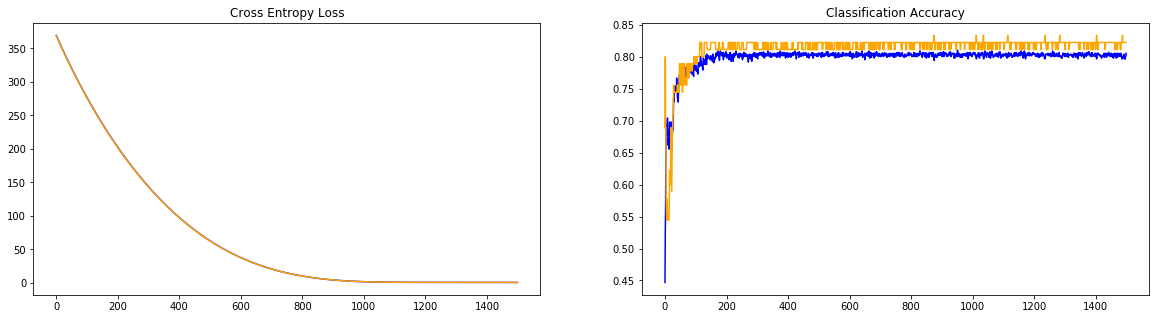

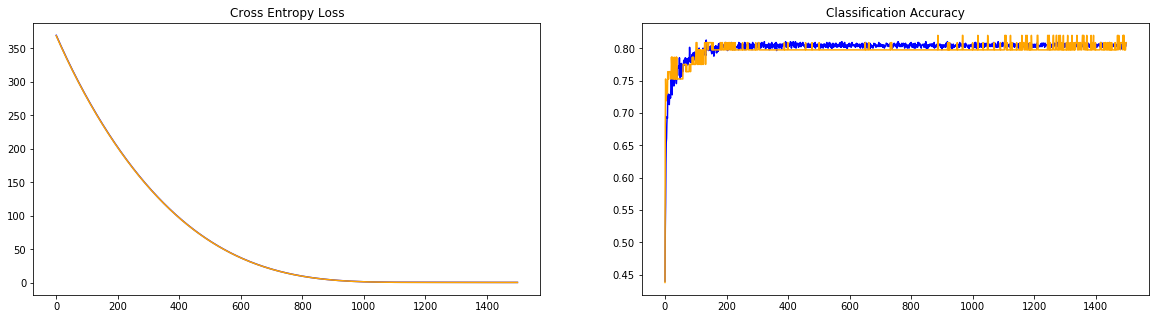

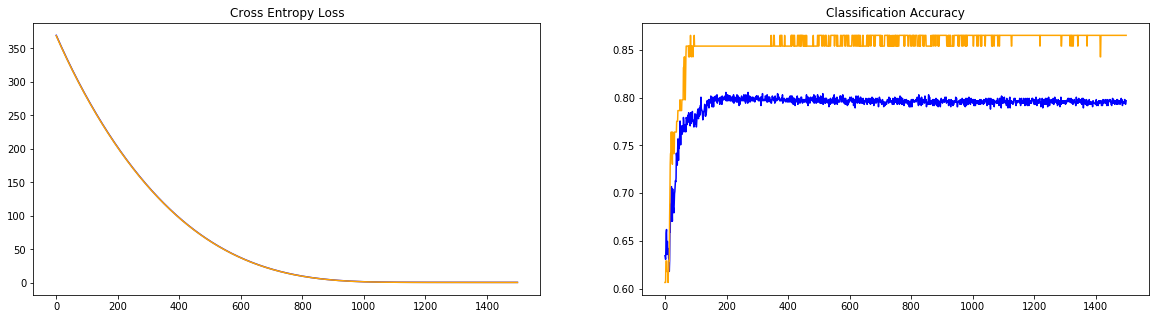

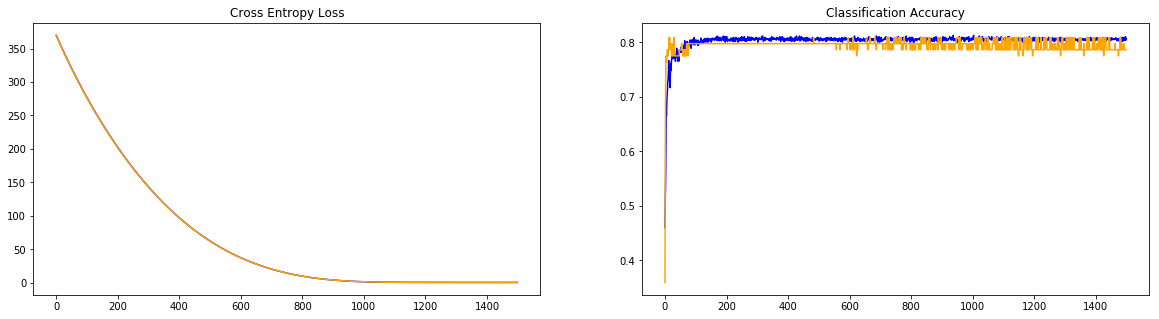

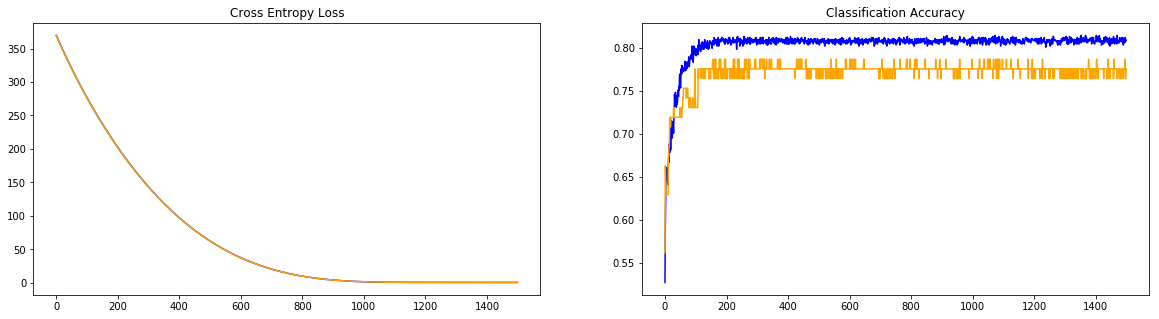

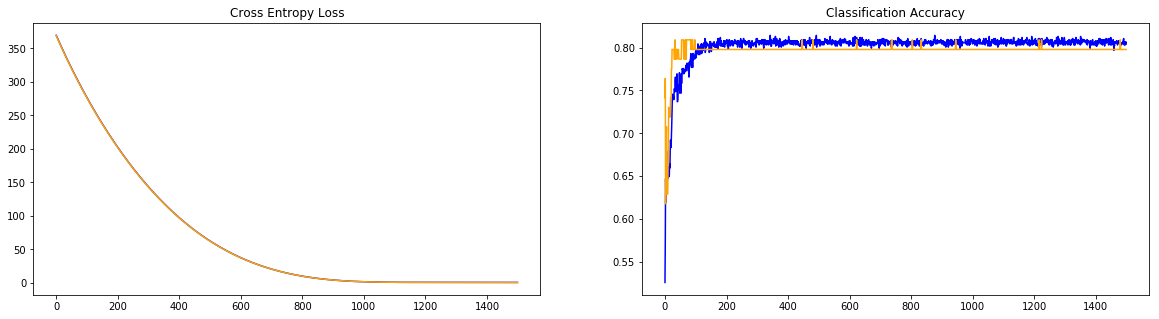

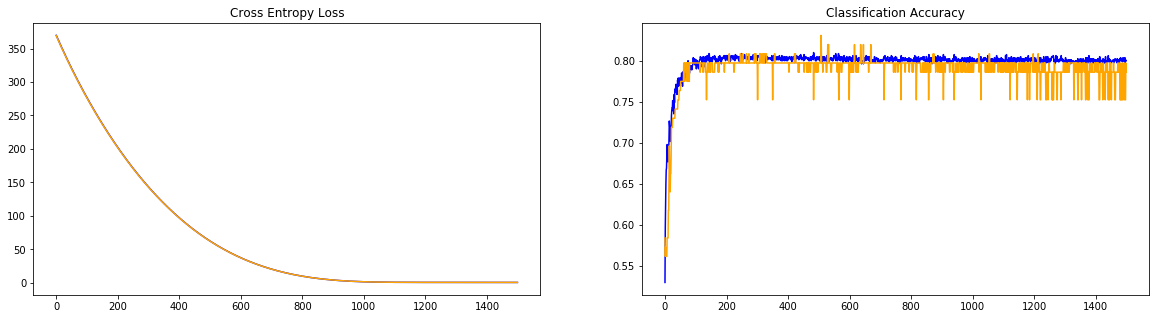

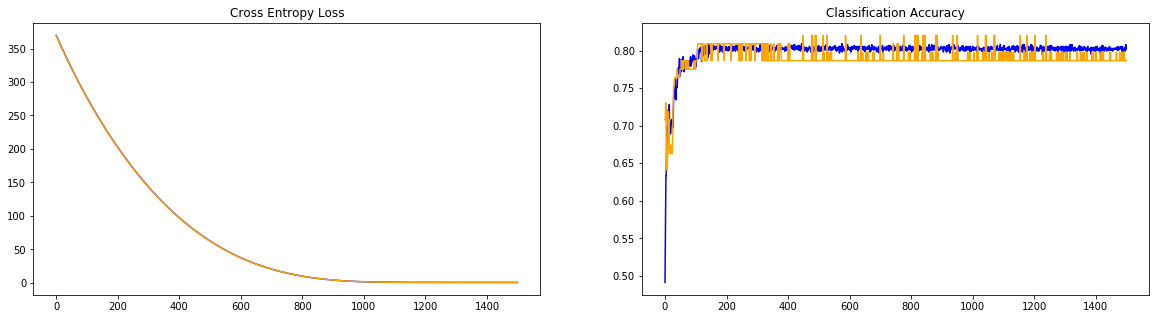

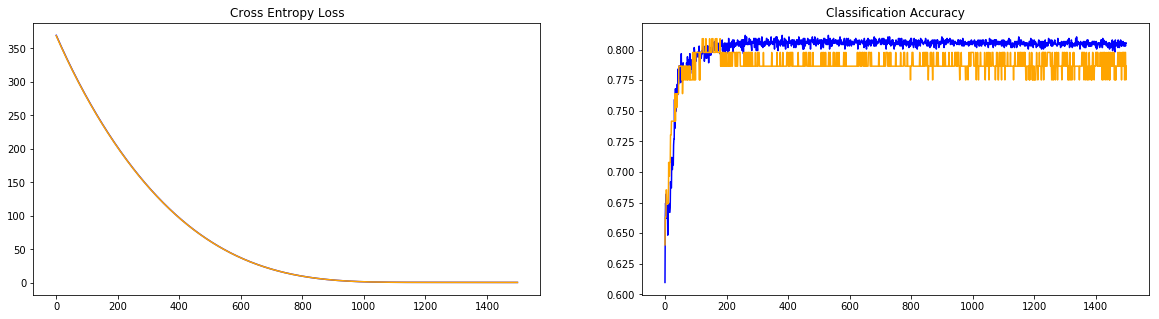

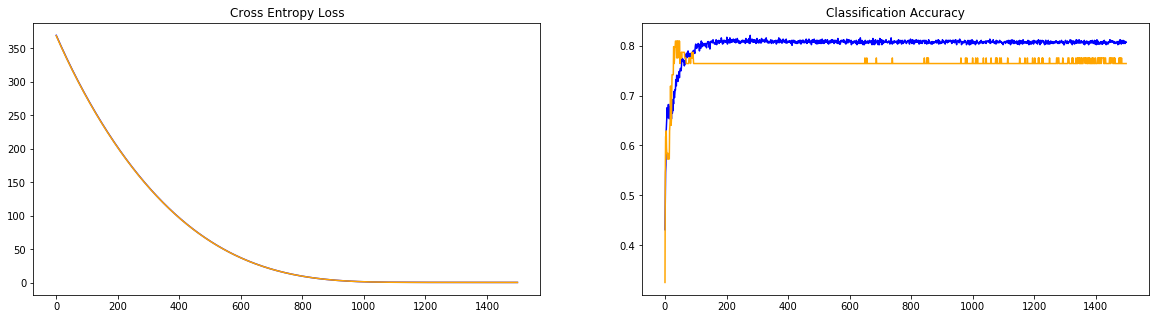

In [20]:
# evaluate
kf = KFold(n_splits=10, shuffle = True)
fold_accuracy = []
fold_loss = []
for train_index, test_index in kf.split(trainData):        
    model = CreateModel()
    model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.000001),
             metrics = ['accuracy'])
    history = model.fit(  x = trainX[train_index],
                          y = trainY[train_index],
                          epochs = 1500,
                          verbose = 2,
                          validation_data = (trainX[test_index],trainY[test_index]),
                          callbacks=[cp_callback],
                     )
    # evaluate
    test_loss, test_acc = model.evaluate(trainX[test_index],trainY[test_index],verbose = 0)    
    print('test accuracy: {}, test loss: {}'.format(test_acc,test_loss))
    fold_accuracy.append(test_acc)
    fold_loss.append(test_loss)
    # plot lose
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
#model.load_weights('./checkpoint.ckpt')          
avg_acc = sum(fold_accuracy)/len(fold_accuracy)
avg_loss = sum(fold_loss)/len(fold_loss)
print('avg accuracy: {}, avg loss: {}'.format(avg_acc,avg_loss))

In [21]:
# Training
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.000001),
             metrics = ['accuracy'])
history = model.fit(  x = trainX,
                      y = trainY,
                      epochs = 3000,
                      verbose = 2,

)        

Train on 891 samples
Epoch 1/3000
891/891 - 2s - loss: 369.5783 - accuracy: 0.3681
Epoch 2/3000
891/891 - 1s - loss: 368.4411 - accuracy: 0.4242
Epoch 3/3000
891/891 - 1s - loss: 367.3073 - accuracy: 0.4736
Epoch 4/3000
891/891 - 1s - loss: 366.1790 - accuracy: 0.4983
Epoch 5/3000
891/891 - 1s - loss: 365.0509 - accuracy: 0.5746
Epoch 6/3000
891/891 - 1s - loss: 363.9284 - accuracy: 0.6083
Epoch 7/3000
891/891 - 1s - loss: 362.8073 - accuracy: 0.6779
Epoch 8/3000
891/891 - 1s - loss: 361.6900 - accuracy: 0.6846
Epoch 9/3000
891/891 - 1s - loss: 360.5771 - accuracy: 0.6936
Epoch 10/3000
891/891 - 1s - loss: 359.4680 - accuracy: 0.6981
Epoch 11/3000
891/891 - 1s - loss: 358.3583 - accuracy: 0.7273
Epoch 12/3000
891/891 - 1s - loss: 357.2553 - accuracy: 0.7183
Epoch 13/3000
891/891 - 1s - loss: 356.1539 - accuracy: 0.7262
Epoch 14/3000
891/891 - 1s - loss: 355.0562 - accuracy: 0.7239
Epoch 15/3000
891/891 - 1s - loss: 353.9619 - accuracy: 0.7116
Epoch 16/3000
891/891 - 1s - loss: 352.8696

Epoch 131/3000
891/891 - 1s - loss: 244.4735 - accuracy: 0.8047
Epoch 132/3000
891/891 - 1s - loss: 243.6570 - accuracy: 0.7991
Epoch 133/3000
891/891 - 1s - loss: 242.8463 - accuracy: 0.7991
Epoch 134/3000
891/891 - 1s - loss: 242.0337 - accuracy: 0.8070
Epoch 135/3000
891/891 - 1s - loss: 241.2253 - accuracy: 0.8036
Epoch 136/3000
891/891 - 1s - loss: 240.4186 - accuracy: 0.8047
Epoch 137/3000
891/891 - 1s - loss: 239.6135 - accuracy: 0.8002
Epoch 138/3000
891/891 - 1s - loss: 238.8094 - accuracy: 0.8036
Epoch 139/3000
891/891 - 1s - loss: 238.0092 - accuracy: 0.8002
Epoch 140/3000
891/891 - 1s - loss: 237.2087 - accuracy: 0.8036
Epoch 141/3000
891/891 - 1s - loss: 236.4116 - accuracy: 0.8047
Epoch 142/3000
891/891 - 1s - loss: 235.6156 - accuracy: 0.8058
Epoch 143/3000
891/891 - 1s - loss: 234.8221 - accuracy: 0.8047
Epoch 144/3000
891/891 - 1s - loss: 234.0295 - accuracy: 0.8025
Epoch 145/3000
891/891 - 1s - loss: 233.2409 - accuracy: 0.8058
Epoch 146/3000
891/891 - 1s - loss: 232.

891/891 - 1s - loss: 154.6894 - accuracy: 0.8058
Epoch 260/3000
891/891 - 1s - loss: 154.0973 - accuracy: 0.8025
Epoch 261/3000
891/891 - 1s - loss: 153.5022 - accuracy: 0.8081
Epoch 262/3000
891/891 - 1s - loss: 152.9119 - accuracy: 0.8058
Epoch 263/3000
891/891 - 1s - loss: 152.3225 - accuracy: 0.8036
Epoch 264/3000
891/891 - 1s - loss: 151.7346 - accuracy: 0.8047
Epoch 265/3000
891/891 - 1s - loss: 151.1491 - accuracy: 0.8081
Epoch 266/3000
891/891 - 1s - loss: 150.5623 - accuracy: 0.8036
Epoch 267/3000
891/891 - 1s - loss: 149.9810 - accuracy: 0.8047
Epoch 268/3000
891/891 - 1s - loss: 149.3990 - accuracy: 0.8047
Epoch 269/3000
891/891 - 1s - loss: 148.8181 - accuracy: 0.8070
Epoch 270/3000
891/891 - 1s - loss: 148.2389 - accuracy: 0.8081
Epoch 271/3000
891/891 - 1s - loss: 147.6613 - accuracy: 0.8070
Epoch 272/3000
891/891 - 1s - loss: 147.0858 - accuracy: 0.8081
Epoch 273/3000
891/891 - 1s - loss: 146.5132 - accuracy: 0.8036
Epoch 274/3000
891/891 - 1s - loss: 145.9393 - accuracy

Epoch 388/3000
891/891 - 1s - loss: 90.1393 - accuracy: 0.8025
Epoch 389/3000
891/891 - 1s - loss: 89.7293 - accuracy: 0.8036
Epoch 390/3000
891/891 - 1s - loss: 89.3183 - accuracy: 0.8092
Epoch 391/3000
891/891 - 1s - loss: 88.9121 - accuracy: 0.8025
Epoch 392/3000
891/891 - 1s - loss: 88.5047 - accuracy: 0.8025
Epoch 393/3000
891/891 - 1s - loss: 88.0988 - accuracy: 0.8036
Epoch 394/3000
891/891 - 1s - loss: 87.6937 - accuracy: 0.8047
Epoch 395/3000
891/891 - 1s - loss: 87.2905 - accuracy: 0.8013
Epoch 396/3000
891/891 - 1s - loss: 86.8898 - accuracy: 0.8025
Epoch 397/3000
891/891 - 1s - loss: 86.4875 - accuracy: 0.8070
Epoch 398/3000
891/891 - 1s - loss: 86.0874 - accuracy: 0.8058
Epoch 399/3000
891/891 - 1s - loss: 85.6906 - accuracy: 0.8047
Epoch 400/3000
891/891 - 1s - loss: 85.2950 - accuracy: 0.8058
Epoch 401/3000
891/891 - 1s - loss: 84.8981 - accuracy: 0.8047
Epoch 402/3000
891/891 - 1s - loss: 84.5043 - accuracy: 0.8013
Epoch 403/3000
891/891 - 1s - loss: 84.1093 - accuracy:

891/891 - 1s - loss: 46.7818 - accuracy: 0.8013
Epoch 519/3000
891/891 - 1s - loss: 46.5194 - accuracy: 0.8058
Epoch 520/3000
891/891 - 1s - loss: 46.2593 - accuracy: 0.8036
Epoch 521/3000
891/891 - 1s - loss: 46.0013 - accuracy: 0.8047
Epoch 522/3000
891/891 - 1s - loss: 45.7434 - accuracy: 0.8013
Epoch 523/3000
891/891 - 1s - loss: 45.4856 - accuracy: 0.8070
Epoch 524/3000
891/891 - 1s - loss: 45.2299 - accuracy: 0.8025
Epoch 525/3000
891/891 - 1s - loss: 44.9752 - accuracy: 0.8047
Epoch 526/3000
891/891 - 1s - loss: 44.7222 - accuracy: 0.8070
Epoch 527/3000
891/891 - 1s - loss: 44.4689 - accuracy: 0.8047
Epoch 528/3000
891/891 - 1s - loss: 44.2171 - accuracy: 0.8013
Epoch 529/3000
891/891 - 1s - loss: 43.9656 - accuracy: 0.8036
Epoch 530/3000
891/891 - 1s - loss: 43.7174 - accuracy: 0.8047
Epoch 531/3000
891/891 - 1s - loss: 43.4680 - accuracy: 0.8036
Epoch 532/3000
891/891 - 1s - loss: 43.2197 - accuracy: 0.8025
Epoch 533/3000
891/891 - 1s - loss: 42.9732 - accuracy: 0.8002
Epoch 5

Epoch 649/3000
891/891 - 1s - loss: 20.4919 - accuracy: 0.8025
Epoch 650/3000
891/891 - 1s - loss: 20.3459 - accuracy: 0.8036
Epoch 651/3000
891/891 - 1s - loss: 20.2008 - accuracy: 0.8036
Epoch 652/3000
891/891 - 1s - loss: 20.0562 - accuracy: 0.8058
Epoch 653/3000
891/891 - 1s - loss: 19.9144 - accuracy: 0.7991
Epoch 654/3000
891/891 - 1s - loss: 19.7713 - accuracy: 0.8013
Epoch 655/3000
891/891 - 1s - loss: 19.6293 - accuracy: 0.8058
Epoch 656/3000
891/891 - 1s - loss: 19.4889 - accuracy: 0.8036
Epoch 657/3000
891/891 - 1s - loss: 19.3483 - accuracy: 0.8047
Epoch 658/3000
891/891 - 1s - loss: 19.2096 - accuracy: 0.8013
Epoch 659/3000
891/891 - 1s - loss: 19.0698 - accuracy: 0.8025
Epoch 660/3000
891/891 - 1s - loss: 18.9307 - accuracy: 0.8047
Epoch 661/3000
891/891 - 1s - loss: 18.7940 - accuracy: 0.8047
Epoch 662/3000
891/891 - 1s - loss: 18.6583 - accuracy: 0.8036
Epoch 663/3000
891/891 - 1s - loss: 18.5215 - accuracy: 0.8025
Epoch 664/3000
891/891 - 1s - loss: 18.3868 - accuracy:

Epoch 780/3000
891/891 - 1s - loss: 7.0205 - accuracy: 0.8013
Epoch 781/3000
891/891 - 1s - loss: 6.9557 - accuracy: 0.8058
Epoch 782/3000
891/891 - 1s - loss: 6.8900 - accuracy: 0.8058
Epoch 783/3000
891/891 - 1s - loss: 6.8269 - accuracy: 0.8070
Epoch 784/3000
891/891 - 1s - loss: 6.7619 - accuracy: 0.8058
Epoch 785/3000
891/891 - 1s - loss: 6.6986 - accuracy: 0.8036
Epoch 786/3000
891/891 - 1s - loss: 6.6357 - accuracy: 0.8025
Epoch 787/3000
891/891 - 1s - loss: 6.5746 - accuracy: 0.8036
Epoch 788/3000
891/891 - 1s - loss: 6.5113 - accuracy: 0.8002
Epoch 789/3000
891/891 - 1s - loss: 6.4492 - accuracy: 0.8058
Epoch 790/3000
891/891 - 1s - loss: 6.3887 - accuracy: 0.8047
Epoch 791/3000
891/891 - 1s - loss: 6.3288 - accuracy: 0.8025
Epoch 792/3000
891/891 - 1s - loss: 6.2671 - accuracy: 0.8025
Epoch 793/3000
891/891 - 1s - loss: 6.2070 - accuracy: 0.8036
Epoch 794/3000
891/891 - 1s - loss: 6.1476 - accuracy: 0.8013
Epoch 795/3000
891/891 - 1s - loss: 6.0885 - accuracy: 0.8047
Epoch 79

891/891 - 1s - loss: 1.8003 - accuracy: 0.8070
Epoch 913/3000
891/891 - 1s - loss: 1.7827 - accuracy: 0.8013
Epoch 914/3000
891/891 - 1s - loss: 1.7631 - accuracy: 0.8036
Epoch 915/3000
891/891 - 1s - loss: 1.7458 - accuracy: 0.8013
Epoch 916/3000
891/891 - 1s - loss: 1.7260 - accuracy: 0.8047
Epoch 917/3000
891/891 - 1s - loss: 1.7086 - accuracy: 0.8013
Epoch 918/3000
891/891 - 1s - loss: 1.6923 - accuracy: 0.8025
Epoch 919/3000
891/891 - 1s - loss: 1.6740 - accuracy: 0.8047
Epoch 920/3000
891/891 - 1s - loss: 1.6572 - accuracy: 0.8013
Epoch 921/3000
891/891 - 1s - loss: 1.6395 - accuracy: 0.8047
Epoch 922/3000
891/891 - 1s - loss: 1.6233 - accuracy: 0.8025
Epoch 923/3000
891/891 - 1s - loss: 1.6058 - accuracy: 0.8058
Epoch 924/3000
891/891 - 1s - loss: 1.5899 - accuracy: 0.8025
Epoch 925/3000
891/891 - 1s - loss: 1.5739 - accuracy: 0.8047
Epoch 926/3000
891/891 - 1s - loss: 1.5577 - accuracy: 0.8047
Epoch 927/3000
891/891 - 1s - loss: 1.5420 - accuracy: 0.8002
Epoch 928/3000
891/891 

Epoch 1044/3000
891/891 - 1s - loss: 0.7005 - accuracy: 0.8036
Epoch 1045/3000
891/891 - 1s - loss: 0.6993 - accuracy: 0.8025
Epoch 1046/3000
891/891 - 1s - loss: 0.6979 - accuracy: 0.8013
Epoch 1047/3000
891/891 - 1s - loss: 0.6948 - accuracy: 0.8025
Epoch 1048/3000
891/891 - 1s - loss: 0.6950 - accuracy: 0.8036
Epoch 1049/3000
891/891 - 1s - loss: 0.6919 - accuracy: 0.8013
Epoch 1050/3000
891/891 - 1s - loss: 0.6913 - accuracy: 0.8025
Epoch 1051/3000
891/891 - 1s - loss: 0.6896 - accuracy: 0.8036
Epoch 1052/3000
891/891 - 1s - loss: 0.6874 - accuracy: 0.7991
Epoch 1053/3000
891/891 - 1s - loss: 0.6859 - accuracy: 0.8002
Epoch 1054/3000
891/891 - 1s - loss: 0.6838 - accuracy: 0.8025
Epoch 1055/3000
891/891 - 1s - loss: 0.6826 - accuracy: 0.7991
Epoch 1056/3000
891/891 - 1s - loss: 0.6811 - accuracy: 0.7991
Epoch 1057/3000
891/891 - 1s - loss: 0.6806 - accuracy: 0.8025
Epoch 1058/3000
891/891 - 1s - loss: 0.6791 - accuracy: 0.8081
Epoch 1059/3000
891/891 - 1s - loss: 0.6766 - accuracy:

891/891 - 1s - loss: 0.6189 - accuracy: 0.8013
Epoch 1175/3000
891/891 - 1s - loss: 0.6174 - accuracy: 0.8036
Epoch 1176/3000
891/891 - 1s - loss: 0.6178 - accuracy: 0.8058
Epoch 1177/3000
891/891 - 1s - loss: 0.6173 - accuracy: 0.8025
Epoch 1178/3000
891/891 - 1s - loss: 0.6173 - accuracy: 0.8070
Epoch 1179/3000
891/891 - 1s - loss: 0.6165 - accuracy: 0.8002
Epoch 1180/3000
891/891 - 1s - loss: 0.6157 - accuracy: 0.8036
Epoch 1181/3000
891/891 - 1s - loss: 0.6161 - accuracy: 0.8013
Epoch 1182/3000
891/891 - 1s - loss: 0.6156 - accuracy: 0.7991
Epoch 1183/3000
891/891 - 1s - loss: 0.6157 - accuracy: 0.8036
Epoch 1184/3000
891/891 - 1s - loss: 0.6159 - accuracy: 0.8013
Epoch 1185/3000
891/891 - 1s - loss: 0.6171 - accuracy: 0.8002
Epoch 1186/3000
891/891 - 1s - loss: 0.6139 - accuracy: 0.8047
Epoch 1187/3000
891/891 - 1s - loss: 0.6140 - accuracy: 0.8047
Epoch 1188/3000
891/891 - 1s - loss: 0.6138 - accuracy: 0.8025
Epoch 1189/3000
891/891 - 1s - loss: 0.6142 - accuracy: 0.8070
Epoch 11

Epoch 1305/3000
891/891 - 1s - loss: 0.5973 - accuracy: 0.8036
Epoch 1306/3000
891/891 - 1s - loss: 0.5967 - accuracy: 0.8047
Epoch 1307/3000
891/891 - 1s - loss: 0.5960 - accuracy: 0.8002
Epoch 1308/3000
891/891 - 1s - loss: 0.5959 - accuracy: 0.8025
Epoch 1309/3000
891/891 - 1s - loss: 0.5976 - accuracy: 0.8025
Epoch 1310/3000
891/891 - 1s - loss: 0.5964 - accuracy: 0.8013
Epoch 1311/3000
891/891 - 1s - loss: 0.5966 - accuracy: 0.7991
Epoch 1312/3000
891/891 - 1s - loss: 0.5960 - accuracy: 0.8002
Epoch 1313/3000
891/891 - 1s - loss: 0.5955 - accuracy: 0.8013
Epoch 1314/3000
891/891 - 1s - loss: 0.5955 - accuracy: 0.8013
Epoch 1315/3000
891/891 - 1s - loss: 0.5960 - accuracy: 0.7991
Epoch 1316/3000
891/891 - 1s - loss: 0.5949 - accuracy: 0.8036
Epoch 1317/3000
891/891 - 1s - loss: 0.5958 - accuracy: 0.7991
Epoch 1318/3000
891/891 - 1s - loss: 0.5941 - accuracy: 0.8025
Epoch 1319/3000
891/891 - 1s - loss: 0.5955 - accuracy: 0.8013
Epoch 1320/3000
891/891 - 1s - loss: 0.5950 - accuracy:

891/891 - 1s - loss: 0.5851 - accuracy: 0.8013
Epoch 1436/3000
891/891 - 1s - loss: 0.5851 - accuracy: 0.7980
Epoch 1437/3000
891/891 - 1s - loss: 0.5854 - accuracy: 0.8002
Epoch 1438/3000
891/891 - 1s - loss: 0.5848 - accuracy: 0.8047
Epoch 1439/3000
891/891 - 1s - loss: 0.5843 - accuracy: 0.7980
Epoch 1440/3000
891/891 - 1s - loss: 0.5848 - accuracy: 0.8013
Epoch 1441/3000
891/891 - 1s - loss: 0.5845 - accuracy: 0.7991
Epoch 1442/3000
891/891 - 1s - loss: 0.5846 - accuracy: 0.8002
Epoch 1443/3000
891/891 - 1s - loss: 0.5849 - accuracy: 0.8002
Epoch 1444/3000
891/891 - 1s - loss: 0.5840 - accuracy: 0.7991
Epoch 1445/3000
891/891 - 1s - loss: 0.5846 - accuracy: 0.8013
Epoch 1446/3000
891/891 - 1s - loss: 0.5847 - accuracy: 0.8025
Epoch 1447/3000
891/891 - 1s - loss: 0.5840 - accuracy: 0.8025
Epoch 1448/3000
891/891 - 1s - loss: 0.5850 - accuracy: 0.8036
Epoch 1449/3000
891/891 - 1s - loss: 0.5844 - accuracy: 0.8002
Epoch 1450/3000
891/891 - 1s - loss: 0.5839 - accuracy: 0.8002
Epoch 14

Epoch 1566/3000
891/891 - 1s - loss: 0.5765 - accuracy: 0.8025
Epoch 1567/3000
891/891 - 1s - loss: 0.5761 - accuracy: 0.8013
Epoch 1568/3000
891/891 - 1s - loss: 0.5771 - accuracy: 0.8058
Epoch 1569/3000
891/891 - 1s - loss: 0.5766 - accuracy: 0.7991
Epoch 1570/3000
891/891 - 1s - loss: 0.5767 - accuracy: 0.8036
Epoch 1571/3000
891/891 - 1s - loss: 0.5774 - accuracy: 0.7991
Epoch 1572/3000
891/891 - 1s - loss: 0.5770 - accuracy: 0.8036
Epoch 1573/3000
891/891 - 1s - loss: 0.5766 - accuracy: 0.8013
Epoch 1574/3000
891/891 - 1s - loss: 0.5751 - accuracy: 0.8025
Epoch 1575/3000
891/891 - 1s - loss: 0.5758 - accuracy: 0.8025
Epoch 1576/3000
891/891 - 1s - loss: 0.5766 - accuracy: 0.8025
Epoch 1577/3000
891/891 - 1s - loss: 0.5770 - accuracy: 0.7980
Epoch 1578/3000
891/891 - 1s - loss: 0.5761 - accuracy: 0.8025
Epoch 1579/3000
891/891 - 1s - loss: 0.5766 - accuracy: 0.8013
Epoch 1580/3000
891/891 - 1s - loss: 0.5747 - accuracy: 0.8036
Epoch 1581/3000
891/891 - 1s - loss: 0.5743 - accuracy:

891/891 - 1s - loss: 0.5707 - accuracy: 0.7980
Epoch 1697/3000
891/891 - 1s - loss: 0.5712 - accuracy: 0.8036
Epoch 1698/3000
891/891 - 1s - loss: 0.5696 - accuracy: 0.7991
Epoch 1699/3000
891/891 - 1s - loss: 0.5704 - accuracy: 0.8002
Epoch 1700/3000
891/891 - 1s - loss: 0.5712 - accuracy: 0.8025
Epoch 1701/3000
891/891 - 1s - loss: 0.5697 - accuracy: 0.8025
Epoch 1702/3000
891/891 - 1s - loss: 0.5704 - accuracy: 0.8036
Epoch 1703/3000
891/891 - 1s - loss: 0.5706 - accuracy: 0.8036
Epoch 1704/3000
891/891 - 1s - loss: 0.5696 - accuracy: 0.7980
Epoch 1705/3000
891/891 - 1s - loss: 0.5697 - accuracy: 0.8025
Epoch 1706/3000
891/891 - 1s - loss: 0.5702 - accuracy: 0.8002
Epoch 1707/3000
891/891 - 1s - loss: 0.5703 - accuracy: 0.8070
Epoch 1708/3000
891/891 - 1s - loss: 0.5697 - accuracy: 0.8025
Epoch 1709/3000
891/891 - 1s - loss: 0.5695 - accuracy: 0.8013
Epoch 1710/3000
891/891 - 1s - loss: 0.5694 - accuracy: 0.8013
Epoch 1711/3000
891/891 - 1s - loss: 0.5692 - accuracy: 0.8002
Epoch 17

Epoch 1827/3000
891/891 - 1s - loss: 0.5646 - accuracy: 0.8025
Epoch 1828/3000
891/891 - 1s - loss: 0.5652 - accuracy: 0.7991
Epoch 1829/3000
891/891 - 1s - loss: 0.5647 - accuracy: 0.8036
Epoch 1830/3000
891/891 - 1s - loss: 0.5645 - accuracy: 0.7991
Epoch 1831/3000
891/891 - 1s - loss: 0.5640 - accuracy: 0.7980
Epoch 1832/3000
891/891 - 1s - loss: 0.5663 - accuracy: 0.7991
Epoch 1833/3000
891/891 - 1s - loss: 0.5638 - accuracy: 0.7969
Epoch 1834/3000
891/891 - 1s - loss: 0.5641 - accuracy: 0.8002
Epoch 1835/3000
891/891 - 1s - loss: 0.5650 - accuracy: 0.8002
Epoch 1836/3000
891/891 - 1s - loss: 0.5648 - accuracy: 0.8036
Epoch 1837/3000
891/891 - 1s - loss: 0.5647 - accuracy: 0.8013
Epoch 1838/3000
891/891 - 1s - loss: 0.5643 - accuracy: 0.8025
Epoch 1839/3000
891/891 - 1s - loss: 0.5641 - accuracy: 0.8047
Epoch 1840/3000
891/891 - 1s - loss: 0.5657 - accuracy: 0.7980
Epoch 1841/3000
891/891 - 1s - loss: 0.5640 - accuracy: 0.7991
Epoch 1842/3000
891/891 - 1s - loss: 0.5652 - accuracy:

891/891 - 1s - loss: 0.5609 - accuracy: 0.7980
Epoch 1958/3000
891/891 - 1s - loss: 0.5617 - accuracy: 0.8002
Epoch 1959/3000
891/891 - 1s - loss: 0.5604 - accuracy: 0.8025
Epoch 1960/3000
891/891 - 1s - loss: 0.5605 - accuracy: 0.7991
Epoch 1961/3000
891/891 - 1s - loss: 0.5607 - accuracy: 0.8013
Epoch 1962/3000
891/891 - 1s - loss: 0.5609 - accuracy: 0.7991
Epoch 1963/3000
891/891 - 1s - loss: 0.5610 - accuracy: 0.8025
Epoch 1964/3000
891/891 - 1s - loss: 0.5603 - accuracy: 0.8025
Epoch 1965/3000
891/891 - 1s - loss: 0.5601 - accuracy: 0.8013
Epoch 1966/3000
891/891 - 1s - loss: 0.5617 - accuracy: 0.8013
Epoch 1967/3000
891/891 - 1s - loss: 0.5605 - accuracy: 0.8002
Epoch 1968/3000
891/891 - 1s - loss: 0.5603 - accuracy: 0.7980
Epoch 1969/3000
891/891 - 1s - loss: 0.5603 - accuracy: 0.8002
Epoch 1970/3000
891/891 - 1s - loss: 0.5600 - accuracy: 0.7991
Epoch 1971/3000
891/891 - 1s - loss: 0.5601 - accuracy: 0.8002
Epoch 1972/3000
891/891 - 1s - loss: 0.5617 - accuracy: 0.8025
Epoch 19

Epoch 2088/3000
891/891 - 1s - loss: 0.5565 - accuracy: 0.8002
Epoch 2089/3000
891/891 - 1s - loss: 0.5562 - accuracy: 0.8025
Epoch 2090/3000
891/891 - 1s - loss: 0.5563 - accuracy: 0.8002
Epoch 2091/3000
891/891 - 1s - loss: 0.5565 - accuracy: 0.8002
Epoch 2092/3000
891/891 - 1s - loss: 0.5558 - accuracy: 0.8002
Epoch 2093/3000
891/891 - 1s - loss: 0.5566 - accuracy: 0.8002
Epoch 2094/3000
891/891 - 1s - loss: 0.5566 - accuracy: 0.8013
Epoch 2095/3000
891/891 - 1s - loss: 0.5567 - accuracy: 0.8036
Epoch 2096/3000
891/891 - 1s - loss: 0.5568 - accuracy: 0.8013
Epoch 2097/3000
891/891 - 1s - loss: 0.5564 - accuracy: 0.8013
Epoch 2098/3000
891/891 - 1s - loss: 0.5554 - accuracy: 0.8036
Epoch 2099/3000
891/891 - 1s - loss: 0.5564 - accuracy: 0.8002
Epoch 2100/3000
891/891 - 1s - loss: 0.5571 - accuracy: 0.8025
Epoch 2101/3000
891/891 - 1s - loss: 0.5566 - accuracy: 0.7991
Epoch 2102/3000
891/891 - 1s - loss: 0.5556 - accuracy: 0.8013
Epoch 2103/3000
891/891 - 1s - loss: 0.5560 - accuracy:

891/891 - 1s - loss: 0.5537 - accuracy: 0.7980
Epoch 2219/3000
891/891 - 1s - loss: 0.5530 - accuracy: 0.8036
Epoch 2220/3000
891/891 - 1s - loss: 0.5525 - accuracy: 0.8002
Epoch 2221/3000
891/891 - 1s - loss: 0.5528 - accuracy: 0.8002
Epoch 2222/3000
891/891 - 1s - loss: 0.5535 - accuracy: 0.8002
Epoch 2223/3000
891/891 - 1s - loss: 0.5535 - accuracy: 0.8002
Epoch 2224/3000
891/891 - 1s - loss: 0.5522 - accuracy: 0.8013
Epoch 2225/3000
891/891 - 1s - loss: 0.5529 - accuracy: 0.8013
Epoch 2226/3000
891/891 - 1s - loss: 0.5532 - accuracy: 0.8013
Epoch 2227/3000
891/891 - 1s - loss: 0.5527 - accuracy: 0.8013
Epoch 2228/3000
891/891 - 1s - loss: 0.5534 - accuracy: 0.7991
Epoch 2229/3000
891/891 - 1s - loss: 0.5526 - accuracy: 0.8025
Epoch 2230/3000
891/891 - 1s - loss: 0.5533 - accuracy: 0.8013
Epoch 2231/3000
891/891 - 1s - loss: 0.5532 - accuracy: 0.8025
Epoch 2232/3000
891/891 - 1s - loss: 0.5527 - accuracy: 0.7991
Epoch 2233/3000
891/891 - 1s - loss: 0.5527 - accuracy: 0.8025
Epoch 22

Epoch 2349/3000
891/891 - 1s - loss: 0.5500 - accuracy: 0.8002
Epoch 2350/3000
891/891 - 1s - loss: 0.5499 - accuracy: 0.8013
Epoch 2351/3000
891/891 - 1s - loss: 0.5506 - accuracy: 0.7980
Epoch 2352/3000
891/891 - 1s - loss: 0.5495 - accuracy: 0.8025
Epoch 2353/3000
891/891 - 1s - loss: 0.5501 - accuracy: 0.7991
Epoch 2354/3000
891/891 - 1s - loss: 0.5502 - accuracy: 0.8025
Epoch 2355/3000
891/891 - 1s - loss: 0.5501 - accuracy: 0.8025
Epoch 2356/3000
891/891 - 1s - loss: 0.5495 - accuracy: 0.8058
Epoch 2357/3000
891/891 - 1s - loss: 0.5502 - accuracy: 0.7935
Epoch 2358/3000
891/891 - 1s - loss: 0.5503 - accuracy: 0.8002
Epoch 2359/3000
891/891 - 1s - loss: 0.5500 - accuracy: 0.8013
Epoch 2360/3000
891/891 - 1s - loss: 0.5491 - accuracy: 0.8013
Epoch 2361/3000
891/891 - 1s - loss: 0.5503 - accuracy: 0.8013
Epoch 2362/3000
891/891 - 1s - loss: 0.5502 - accuracy: 0.8025
Epoch 2363/3000
891/891 - 1s - loss: 0.5489 - accuracy: 0.8058
Epoch 2364/3000
891/891 - 1s - loss: 0.5489 - accuracy:

891/891 - 1s - loss: 0.5479 - accuracy: 0.8013
Epoch 2480/3000
891/891 - 1s - loss: 0.5476 - accuracy: 0.7991
Epoch 2481/3000
891/891 - 1s - loss: 0.5475 - accuracy: 0.8013
Epoch 2482/3000
891/891 - 1s - loss: 0.5470 - accuracy: 0.8013
Epoch 2483/3000
891/891 - 1s - loss: 0.5468 - accuracy: 0.8002
Epoch 2484/3000
891/891 - 1s - loss: 0.5464 - accuracy: 0.8002
Epoch 2485/3000
891/891 - 1s - loss: 0.5473 - accuracy: 0.8002
Epoch 2486/3000
891/891 - 1s - loss: 0.5468 - accuracy: 0.7969
Epoch 2487/3000
891/891 - 1s - loss: 0.5476 - accuracy: 0.7991
Epoch 2488/3000
891/891 - 1s - loss: 0.5475 - accuracy: 0.8002
Epoch 2489/3000
891/891 - 1s - loss: 0.5483 - accuracy: 0.7991
Epoch 2490/3000
891/891 - 1s - loss: 0.5473 - accuracy: 0.8047
Epoch 2491/3000
891/891 - 1s - loss: 0.5472 - accuracy: 0.8070
Epoch 2492/3000
891/891 - 1s - loss: 0.5471 - accuracy: 0.7991
Epoch 2493/3000
891/891 - 1s - loss: 0.5479 - accuracy: 0.7980
Epoch 2494/3000
891/891 - 1s - loss: 0.5469 - accuracy: 0.7957
Epoch 24

Epoch 2610/3000
891/891 - 1s - loss: 0.5447 - accuracy: 0.8025
Epoch 2611/3000
891/891 - 1s - loss: 0.5455 - accuracy: 0.8047
Epoch 2612/3000
891/891 - 1s - loss: 0.5456 - accuracy: 0.8013
Epoch 2613/3000
891/891 - 1s - loss: 0.5458 - accuracy: 0.8013
Epoch 2614/3000
891/891 - 1s - loss: 0.5451 - accuracy: 0.8013
Epoch 2615/3000
891/891 - 1s - loss: 0.5451 - accuracy: 0.8002
Epoch 2616/3000
891/891 - 1s - loss: 0.5449 - accuracy: 0.7991
Epoch 2617/3000
891/891 - 1s - loss: 0.5439 - accuracy: 0.7991
Epoch 2618/3000
891/891 - 1s - loss: 0.5452 - accuracy: 0.7969
Epoch 2619/3000
891/891 - 1s - loss: 0.5450 - accuracy: 0.8002
Epoch 2620/3000
891/891 - 1s - loss: 0.5450 - accuracy: 0.8013
Epoch 2621/3000
891/891 - 1s - loss: 0.5448 - accuracy: 0.7991
Epoch 2622/3000
891/891 - 1s - loss: 0.5453 - accuracy: 0.8036
Epoch 2623/3000
891/891 - 1s - loss: 0.5453 - accuracy: 0.8013
Epoch 2624/3000
891/891 - 1s - loss: 0.5461 - accuracy: 0.7991
Epoch 2625/3000
891/891 - 1s - loss: 0.5457 - accuracy:

891/891 - 1s - loss: 0.5432 - accuracy: 0.7980
Epoch 2741/3000
891/891 - 1s - loss: 0.5432 - accuracy: 0.8025
Epoch 2742/3000
891/891 - 1s - loss: 0.5437 - accuracy: 0.8070
Epoch 2743/3000
891/891 - 1s - loss: 0.5427 - accuracy: 0.8002
Epoch 2744/3000
891/891 - 1s - loss: 0.5422 - accuracy: 0.8002
Epoch 2745/3000
891/891 - 1s - loss: 0.5436 - accuracy: 0.8025
Epoch 2746/3000
891/891 - 1s - loss: 0.5429 - accuracy: 0.8002
Epoch 2747/3000
891/891 - 1s - loss: 0.5426 - accuracy: 0.8036
Epoch 2748/3000
891/891 - 1s - loss: 0.5426 - accuracy: 0.8002
Epoch 2749/3000
891/891 - 1s - loss: 0.5433 - accuracy: 0.8013
Epoch 2750/3000
891/891 - 1s - loss: 0.5429 - accuracy: 0.7991
Epoch 2751/3000
891/891 - 1s - loss: 0.5438 - accuracy: 0.8013
Epoch 2752/3000
891/891 - 1s - loss: 0.5433 - accuracy: 0.8025
Epoch 2753/3000
891/891 - 1s - loss: 0.5433 - accuracy: 0.8070
Epoch 2754/3000
891/891 - 1s - loss: 0.5431 - accuracy: 0.8002
Epoch 2755/3000
891/891 - 1s - loss: 0.5426 - accuracy: 0.7991
Epoch 27

Epoch 2871/3000
891/891 - 1s - loss: 0.5416 - accuracy: 0.8002
Epoch 2872/3000
891/891 - 1s - loss: 0.5408 - accuracy: 0.8002
Epoch 2873/3000
891/891 - 1s - loss: 0.5411 - accuracy: 0.8013
Epoch 2874/3000
891/891 - 1s - loss: 0.5410 - accuracy: 0.8025
Epoch 2875/3000
891/891 - 1s - loss: 0.5408 - accuracy: 0.7991
Epoch 2876/3000
891/891 - 1s - loss: 0.5414 - accuracy: 0.8013
Epoch 2877/3000
891/891 - 1s - loss: 0.5419 - accuracy: 0.7980
Epoch 2878/3000
891/891 - 1s - loss: 0.5416 - accuracy: 0.7969
Epoch 2879/3000
891/891 - 1s - loss: 0.5403 - accuracy: 0.8025
Epoch 2880/3000
891/891 - 1s - loss: 0.5411 - accuracy: 0.8002
Epoch 2881/3000
891/891 - 1s - loss: 0.5409 - accuracy: 0.8002
Epoch 2882/3000
891/891 - 1s - loss: 0.5407 - accuracy: 0.8058
Epoch 2883/3000
891/891 - 1s - loss: 0.5414 - accuracy: 0.8002
Epoch 2884/3000
891/891 - 1s - loss: 0.5421 - accuracy: 0.7991
Epoch 2885/3000
891/891 - 1s - loss: 0.5407 - accuracy: 0.7980
Epoch 2886/3000
891/891 - 1s - loss: 0.5415 - accuracy:

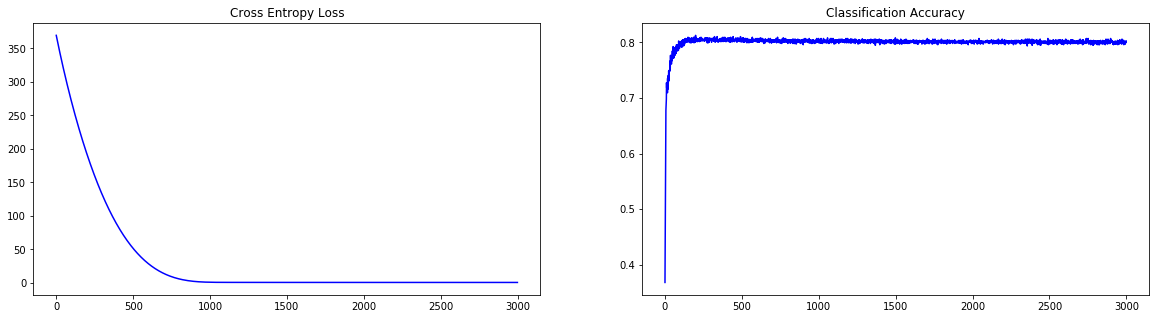

In [22]:

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')


In [23]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions.csv',index = False)